# Final Group Project (GROUP_4) - QF627

### **`Instruction`**

The take-home group assignment is yet another intriguing task in computational finance — building your trading strategy to beat the market. Yes, this is not an easy task given the stage of your learning for now. Thus, rather than trying to predict the future, the take-home group project asks you to employ backtesting to test your strategies.

> *Note that this is for assignment purposes, and you are running backtesting here. Recall that even if you could beat the market in the past, that does not mean that you will be able to do so in the future.*

- You will build your trading strategy using the past 20 years (`November 2005 through October 2024`) of S&P 500 data, extracting the data from Yahoo Finance. Your `starting capital` is set at `$100,000`.

## `GROUP MEMBERS`:
- **KEVIN MONTANA WONGSO**
- **TAN WEI HAO**
- **LIM FANG YI**
- **RAHUL SREERAM**

## *How to Submit*
All the work must be done on Jupyter Notebook, and your group’s `.ipynb` should be submitted via eLearn by `11:59 pm, November 23`. The filename should be `Group_4.ipynb`.

## *NOTE*
- Please use the `SPY` ticker for your market baseline return and your strategy return for the period of November 2005 through October 2024. Your only asset is `SPY` itself — no composites, no sub-index, no sub-components.
- The starting capital of `$100,000` is the only capital you have, and the capital is for each strategy. You are not allowed to borrow any more money.
- Our operational definition of a better strategy, for the purpose of this assignment, is to `maximize your cumulative return`.
- For this assignment, use the most recent 20% of the data’s time period for your backtesting.
- In order to be fair, your work will be assessed based on `what you have learned in the module`. The question did not ask about anything outside the scripts of the course.
- For this take-home assignment, please remember that you are supposed to be `comparing` model strategy cumulative returns from different approaches (i.e., momentum, mean-reversion, machine learning).
- As mentioned in the question, and in the previous guideline note, this is for assessment of your mastery of knowledge learned in the course itself. This assignment assesses strategy, and nothing else (e.g., implementing `stop-loss` is `not` a part of it).

To reiterate, your submission will be assessed on:
1. the quality and validity of your programming (lines of codes);
2. your analysis of strategies (why certain strategies are better than others, and importantly, why they are better) and your recommendations (this is what quants do), and;
3. your group’s cumulative return relative to the other groups’ cumulative returns.

- Again, I wish you the best, Team 👍

**💯 “Thank you for putting your efforts into the take-home assessment questions” 😊**

# `PART 1` 

> In total 16 strategies presented:

In [6]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import re
import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(240911)

In [7]:
stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)
df = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


## 1.1. Strategies by Kevin Montana Wongso:

### 1.1.1. SMA strategy (Kevin)
- Long Signal: Generated when the shorter SMA crosses above the longer SMA (indicating an upward trend).
- Short Signal: Generated when the shorter SMA crosses below the longer SMA (indicating a downward trend).
- Hyperparameters:
  - short_window (faster-moving average).
  - long_window (slower-moving average).

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sma_strategy_with_tuning(data, short_range, long_range, capital, position_size):
    
    best_params = {'short_window': None, 'long_window': None, 'cumulative_return': -np.inf}
    results = pd.DataFrame()

    for short_window in short_range:
        for long_window in long_range:
            if short_window >= long_window:
                continue

            # Calculate SMA signals
            data['shorter_SMA'] = data['Adj Close'].rolling(window=short_window, min_periods=short_window).mean()
            data['longer_SMA'] = data['Adj Close'].rolling(window=long_window, min_periods=long_window).mean()
            data['BUY_or_SELL'] = np.where(data['shorter_SMA'] > data['longer_SMA'], 1.0, 0.0)
            data['Positions'] = data['BUY_or_SELL'].diff()

            # Portfolio management
            data['shares_bought'] = position_size * data['BUY_or_SELL']
            data['holdings'] = data['shares_bought'] * data['Adj Close']
            data['cash'] = (
                capital - (data['shares_bought'].diff() * data['Adj Close']).cumsum().fillna(0)
            )
            data['total'] = data['cash'] + data['holdings']
            data['strategy_returns'] = np.log(data['total'] / data['total'].shift(1))
            data['cum_strategy_return'] = data['strategy_returns'].cumsum().apply(np.exp)

            # Evaluate cumulative return
            cumulative_return = data['cum_strategy_return'].iloc[-1]
            if cumulative_return > best_params['cumulative_return']:
                best_params.update({
                    'short_window': short_window,
                    'long_window': long_window,
                    'cumulative_return': cumulative_return
                })
                results = data.copy()

    # Add SPY (Buy & Hold) returns to results
    results['SPY_return'] = np.log(results['Adj Close'] / results['Adj Close'].shift(1))
    results['SPY_cum_return'] = results['SPY_return'].cumsum().apply(np.exp)
    results['gross_max_performance'] = results['cum_strategy_return'].cummax()

    # Plot results
    plt.figure(figsize=(18, 7))
    plt.plot(results['SPY_cum_return'], label='SPY Cum Return')
    plt.plot(results['cum_strategy_return'], label='SMA Cum Strategy')
    plt.plot(results['gross_max_performance'], label='SMA Strategy Max Performance')
    plt.legend()
    plt.grid()
    plt.title('SMA Trading Strategy Performance')
    plt.show()

    return best_params, results


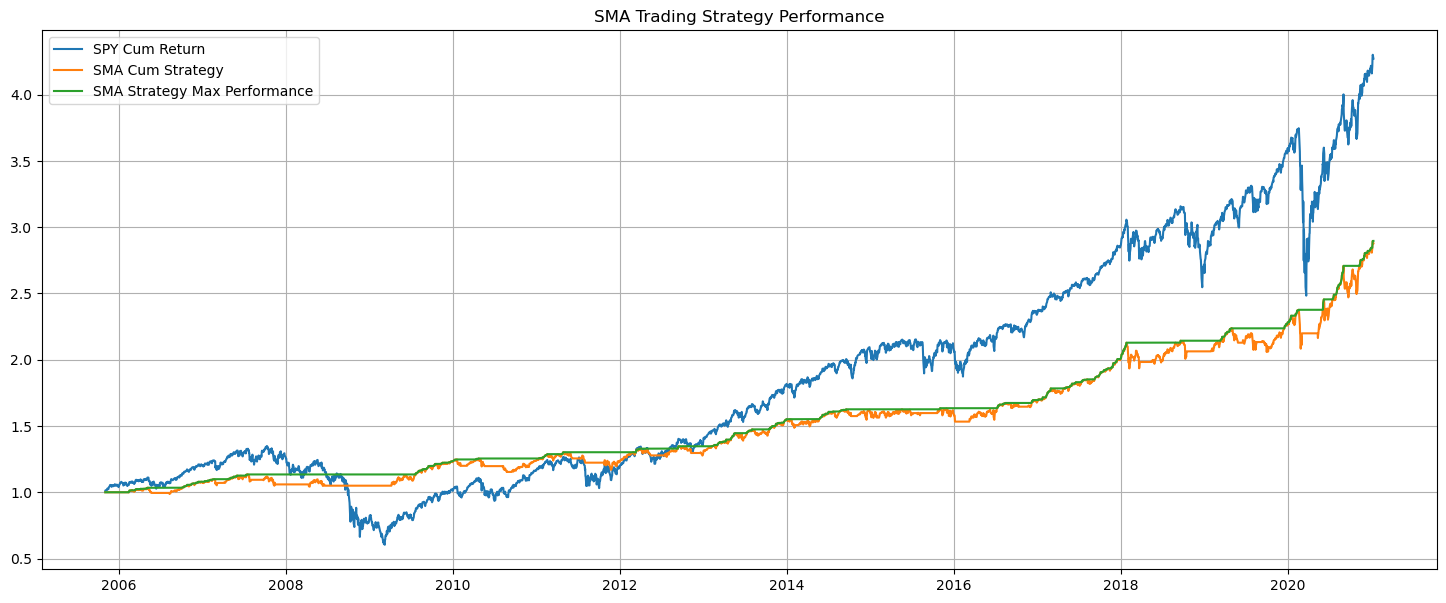

Best Parameters: {'short_window': 14, 'long_window': 70, 'cumulative_return': 2.87847251560211}


strategy_returns  cum_strategy_return  SPY_return  SPY_cum_return
Date                                                                         
2021-01-05          0.006403             2.826199    0.006864        4.189472
2021-01-06          0.005563             2.841966    0.005961        4.214519
2021-01-07          0.013775             2.881385    0.014748        4.277137
2021-01-08          0.005310             2.896726    0.005682        4.301507
2021-01-11         -0.006321             2.878473   -0.006764        4.272511

In [11]:
#TRAIN
data = df[:int(0.8*len(df))]

# Run the strategy with hyperparameter tuning
best_params, results = sma_strategy_with_tuning(
    data,
    short_range=range(5, 20),  # Tuning range for short window
    long_range=range(50, 200),  # Tuning range for long window
    capital=100000,
    position_size=749.5
)

print("Best Parameters:", best_params)

results[['strategy_returns','cum_strategy_return','SPY_return','SPY_cum_return']].tail()



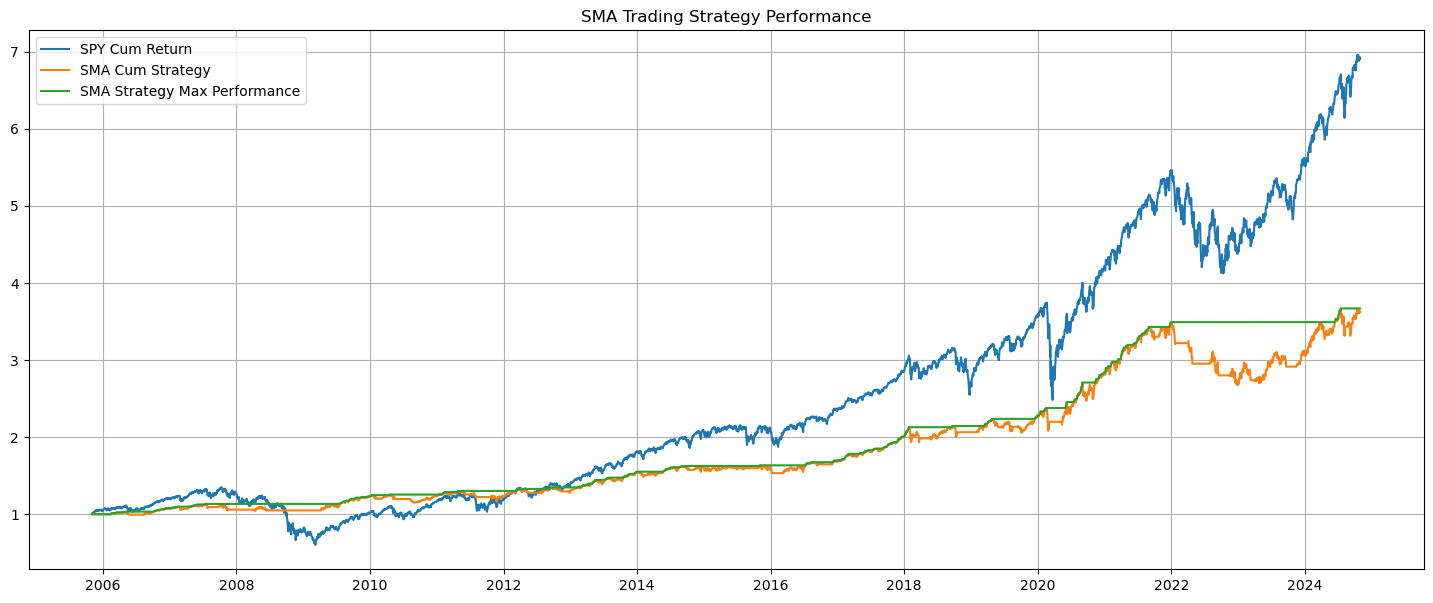

strategy_returns  cum_strategy_return  SPY_return  SPY_cum_return
Date                                                                         
2024-10-24          0.002592             3.619059    0.002160        6.896442
2024-10-25         -0.000414             3.617560   -0.000345        6.894061
2024-10-28          0.003702             3.630976    0.003087        6.915373
2024-10-29          0.001938             3.638021    0.001617        6.926565
2024-10-30         -0.003633             3.624830   -0.003030        6.905610

In [12]:
#Combined TRAIN and TEST

data = df

# Run the strategy from TRAINING DATASET
best_params, results = sma_strategy_with_tuning(
    data,
    short_range=[14],  # from TRAINING DATASET
    long_range=[70],  # from TRAINING DATASET
    capital=100000,
    position_size=749.5
)

# print("Best Parameters:", best_params)
sma_result_df = results.copy()
results[['strategy_returns','cum_strategy_return','SPY_return','SPY_cum_return']].tail()


### 1.1.2. EWMA strategy (Kevin)
- Long Signal: Generated when the shorter EWMA crosses above the longer EWMA (indicating an upward trend).
- Short Signal: Generated when the shorter EWMA crosses below the longer EWMA (indicating a downward trend).
- Hyperparameters:
  - short_window (faster-moving average).
  - long_window (slower-moving average).

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ewma_strategy_with_tuning(data, short_range, long_range, capital=100000, position_size=750):
    best_params = {'short_window': None, 'long_window': None, 'cumulative_return': -np.inf}
    results = pd.DataFrame()

    for short_window in short_range:
        for long_window in long_range:
            if short_window >= long_window:
                continue

            # Calculate EWMAs
            data['shorter_EWMA'] = data['Adj Close'].ewm(span=short_window, min_periods=short_window).mean()
            data['longer_EWMA'] = data['Adj Close'].ewm(span=long_window, min_periods=long_window).mean()
            data['BUY_or_SELL'] = np.where(data['shorter_EWMA'] > data['longer_EWMA'], 1.0, 0.0)
            data['Positions'] = data['BUY_or_SELL'].diff()

            # Portfolio management
            data['shares_bought'] = position_size * data['BUY_or_SELL']
            data['holdings'] = data['shares_bought'] * data['Adj Close']
            data['cash'] = (
                capital - (data['shares_bought'].diff() * data['Adj Close']).cumsum().fillna(0)
            )
            data['total'] = data['cash'] + data['holdings']
            data['strategy_returns'] = np.log(data['total'] / data['total'].shift(1))
            data['cum_strategy_return'] = data['strategy_returns'].cumsum().apply(np.exp)

            # Evaluate cumulative return
            cumulative_return = data['cum_strategy_return'].iloc[-1]
            if cumulative_return > best_params['cumulative_return']:
                best_params.update({
                    'short_window': short_window,
                    'long_window': long_window,
                    'cumulative_return': cumulative_return
                })
                results = data.copy()

    # Add SPY (Buy & Hold) returns to results
    results['SPY_return'] = np.log(results['Adj Close'] / results['Adj Close'].shift(1))
    results['SPY_cum_return'] = results['SPY_return'].cumsum().apply(np.exp)
    results['gross_max_performance'] = results['cum_strategy_return'].cummax()

    # Plot results
    plt.figure(figsize=(18, 7))
    plt.plot(results['SPY_cum_return'], label='SPY Cum Return')
    plt.plot(results['cum_strategy_return'], label='EWMA Cum Strategy')
    plt.plot(results['gross_max_performance'], label='EWMA Strategy Max Performance')
    plt.legend()
    plt.grid()
    plt.title('EWMA Trading Strategy Performance')
    plt.show()

    return best_params, results


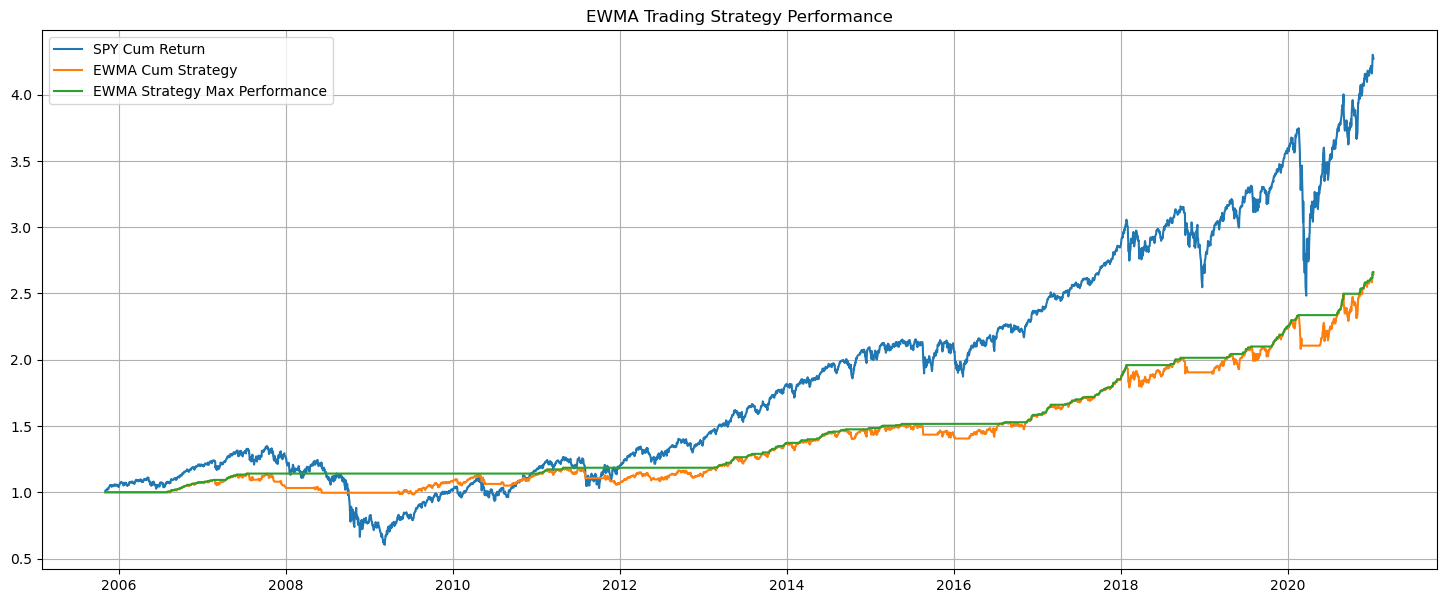

Best Parameters: {'short_window': 8, 'long_window': 148, 'cumulative_return': 2.6454557189941372}


strategy_returns  cum_strategy_return  SPY_return  SPY_cum_return
Date                                                                         
2021-01-05          0.006035             2.600122    0.006864        4.189472
2021-01-06          0.005245             2.613796    0.005961        4.214519
2021-01-07          0.012994             2.647981    0.014748        4.277137
2021-01-08          0.005012             2.661286    0.005682        4.301507
2021-01-11         -0.005966             2.645456   -0.006764        4.272511

In [15]:
#TRAIN
data = df[:int(0.8*len(df))]

# Run the EWMA strategy with hyperparameter tuning
best_params, results = ewma_strategy_with_tuning(
    data,
    short_range=range(5, 20),  # Tuning range for short window
    long_range=range(50, 200),  # Tuning range for long window
    capital=100000,
    position_size=650
)

print("Best Parameters:", best_params)
results[['strategy_returns','cum_strategy_return','SPY_return','SPY_cum_return']].tail()

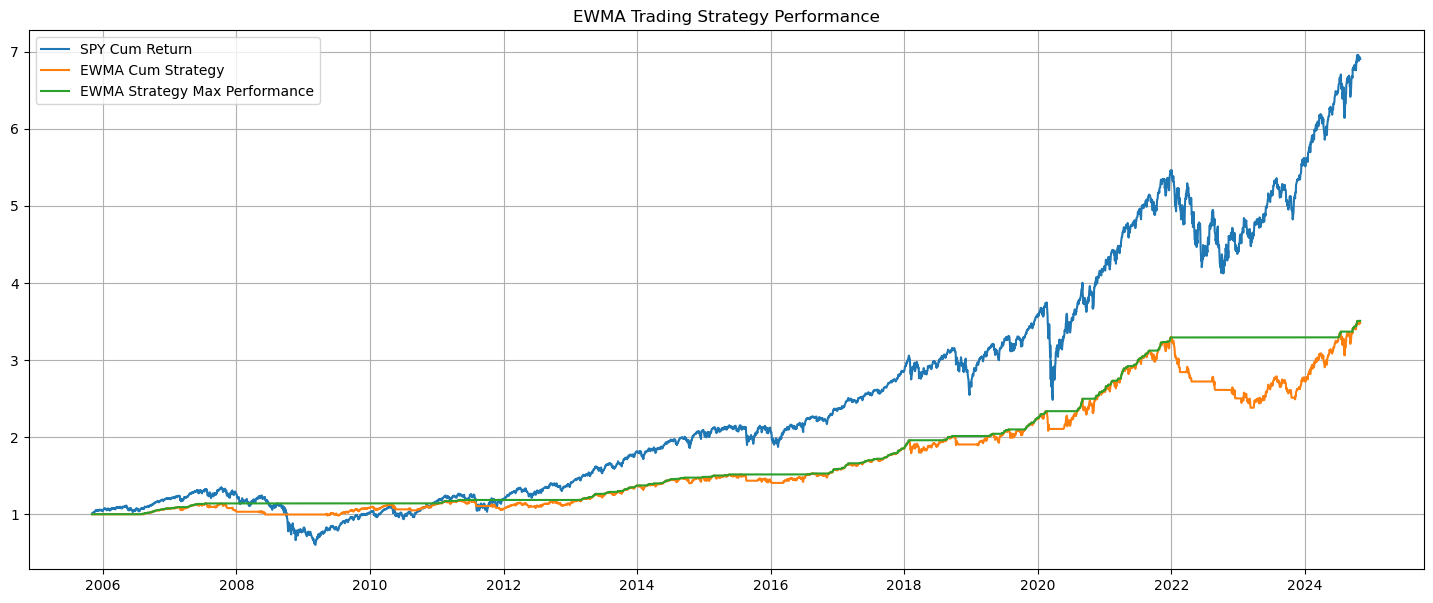

strategy_returns  cum_strategy_return  SPY_return  SPY_cum_return
Date                                                                         
2024-10-24          0.002342             3.473433    0.002160        6.896442
2024-10-25         -0.000374             3.472133   -0.000345        6.894061
2024-10-28          0.003345             3.483768    0.003087        6.915373
2024-10-29          0.001752             3.489878    0.001617        6.926565
2024-10-30         -0.003283             3.478438   -0.003030        6.905610

In [16]:
#Combined TEST and TRAIN

data = df

# Run the EWMA strategy with hyperparameter tuning
best_params, results = ewma_strategy_with_tuning(
    data,
    short_range=[8],  # from TRAINING DATASET
    long_range=[148],  # from TRAINING DATASET
    capital=100000,
    position_size=650
)

# print("Best Parameters:", best_params)
ewma_result_df = results.copy()
results[['strategy_returns','cum_strategy_return','SPY_return','SPY_cum_return']].tail()

### 1.1.3. Time Series Momentum (1 PARAMETER) (Kevin)

> Time-series momentum strategies buy those instruments that have recently performed well and sell those instruments that have recently performed poorly. Here, the benchmark is the past returns of the instrument itself.

> The most simple time series momentum strategy is to buy the stock if the last return was positive and to sell it if it was negative. With NumPy and pandas, this is easy to formalize; just take the sign of the last available return as the market position.
>
- Long Signal: Generated when the log return is positive (Return > 0).
- Short Signal: Generated when the log return is negative (Return < 0).
- Hyperparameter:
  - The lookback_period determines the timeframe for assessing momentum, and it is tuned to maximize strategy performance.

In [18]:
def tsmom_strategy_with_tuning(data, lookback_range):

    best_params = {
        'lookback_period': None,
        'cumulative_return': -np.inf
    }
    results = pd.DataFrame()

    for lookback_period in lookback_range:
        # Calculate momentum signals
        data['Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
        data['Positions'] = np.sign(data['Return'])

        # Calculate strategy returns
        data['strategy_returns'] = data['Positions'].shift(1) * data['Return']
        data['cum_strategy_return'] = data['strategy_returns'].cumsum().apply(np.exp)
        
        # Evaluate cumulative return
        cumulative_return = data['cum_strategy_return'].iloc[-1]
        if cumulative_return > best_params['cumulative_return']:
            best_params.update({
                'lookback_period': lookback_period,
                'cumulative_return': cumulative_return
            })
            results = data.copy()

    # Add SPY (Buy & Hold) returns to results
    results['SPY_return'] = data['Return']
    results['SPY_cum_return'] = data['Return'].cumsum().apply(np.exp)
    results['gross_max_performance'] = results['cum_strategy_return'].cummax()

    # Plot results
    plt.figure(figsize=(18, 7))
    plt.plot(results['SPY_cum_return'], label='SPY Cum Return')
    plt.plot(results['cum_strategy_return'], label='TSMOM Cum Strategy')
    plt.plot(results['gross_max_performance'], label='TSMOM Strategy Max Performance')
    plt.legend()
    plt.grid()
    plt.title('TSMOM Trading Strategy Performance')
    plt.show()

    return best_params, results


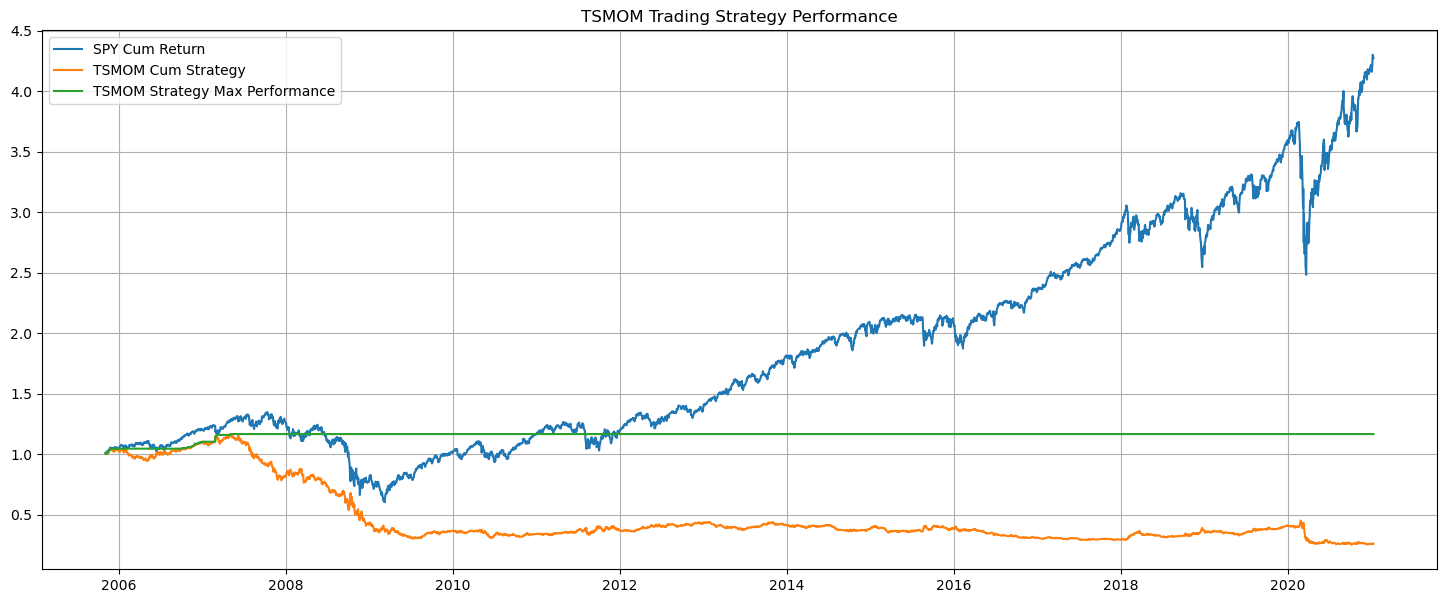

Best Parameters: {'lookback_period': 5, 'cumulative_return': 0.2612410041423652}


strategy_returns  cum_strategy_return  SPY_return  SPY_cum_return
Date                                                                         
2021-01-05         -0.006864             0.256164    0.006864        4.189472
2021-01-06          0.005961             0.257695    0.005961        4.214519
2021-01-07          0.014748             0.261524    0.014748        4.277137
2021-01-08          0.005682             0.263014    0.005682        4.301507
2021-01-11         -0.006764             0.261241   -0.006764        4.272511

In [19]:
# TRAINING DATA SET

data = df[:int(0.8*len(df))]

# Define ranges for tuning
lookback_range = range(5, 100)  # Range of momentum lookback periods

# Run the TSMOM strategy with hyperparameter tuning
best_params, results = tsmom_strategy_with_tuning(data, lookback_range=lookback_range)

print("Best Parameters:", best_params)
results[['strategy_returns','cum_strategy_return','SPY_return','SPY_cum_return']].tail()

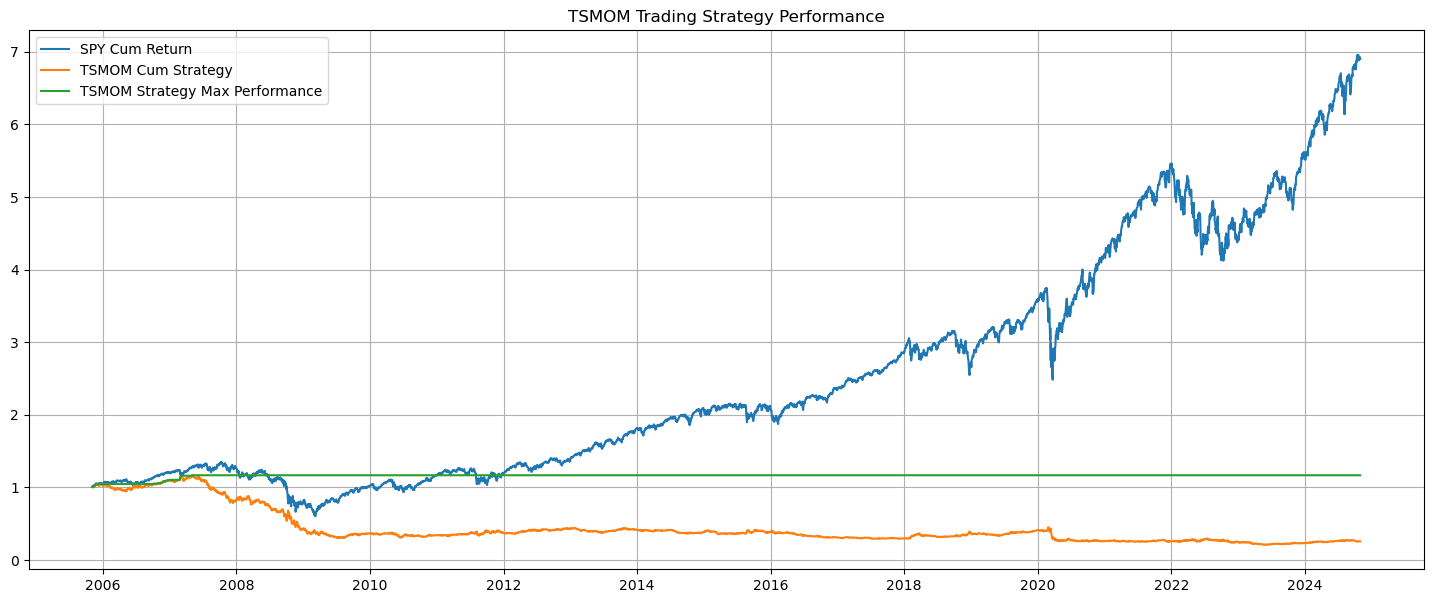

strategy_returns  cum_strategy_return  SPY_return  SPY_cum_return
Date                                                                         
2024-10-24         -0.002160             0.257250    0.002160        6.896442
2024-10-25         -0.000345             0.257161   -0.000345        6.894061
2024-10-28         -0.003087             0.256369    0.003087        6.915373
2024-10-29          0.001617             0.256784    0.001617        6.926565
2024-10-30         -0.003030             0.256007   -0.003030        6.905610

In [20]:
# Combined TEST and TRAIN DATA SET

data = df

# Define ranges for tuning
lookback_range = [5]  # Use from TRAINING DATA SET

best_params, results = tsmom_strategy_with_tuning(data, lookback_range=lookback_range)

# print("Best Parameters:", best_params)
time_series_result_df = results.copy()
results[['strategy_returns','cum_strategy_return','SPY_return','SPY_cum_return']].tail()

### 1.1.4. Time Series Momentum (2 PARAMETERS) (Kevin)
> Time-series momentum strategies buy those instruments that have recently performed well and sell those instruments that have recently performed poorly. Here, the benchmark is the past returns of the instrument itself.

> The most simple time series momentum strategy is to buy the stock if the last return was positive and to sell it if it was negative. With NumPy and pandas, this is easy to formalize; just take the sign of the last available return as the market position.
>
- Long Signal: Generated when the log return is positive (Return > 0).
- Short Signal: Generated when the log return is negative (Return < 0).
- Hyperparameter:
  - a: lookback_period
  - b: shift for positions to avoid lookahead bias

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf

def TSMOM_strategy(df, a, b):

    # Calculate rolling returns and positions
    df['ROLLING_RETURNS'] = df['Adj Close'].pct_change(periods=a)
    df['positions'] = np.sign(df['ROLLING_RETURNS'])
    
    # Calculate strategy returns with shifted positions
    df['RETURNS'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['STRATEGY'] = df['positions'].shift(b) * df['RETURNS']
    df['CUMULATIVE_SPY_RETURNS'] = df['RETURNS'].cumsum().apply(np.exp)
    df['CUMULATIVE_STRATEGY_RETURNS'] = df['STRATEGY'].cumsum().apply(np.exp)
    
    return df

def vectorized_TSMOM_strategy(df, a_values, b_values):

    best_params = {'a': None, 'b': None, 'cumulative_return': -np.inf}
    
    for a in a_values:
        for b in b_values:
            # Calculate cumulative return for current (a, b) combination
            cumulative_return = TSMOM_strategy(df.copy(), a, b)['CUMULATIVE_STRATEGY_RETURNS'].max()
            
            # Update best parameters if current return is better
            if cumulative_return > best_params['cumulative_return']:
                best_params.update({'a': a, 'b': b, 'cumulative_return': cumulative_return})
    
    return best_params


In [23]:
#TRAINING DATASET
df2 = df[:int(0.8*len(df))]

# Define ranges for tuning
a_values = range(5, 20)  # Lookback periods
b_values = range(1, 200)   # Signal shift periods

# Run the TSMOM strategy with hyperparameter tuning
best_params = vectorized_TSMOM_strategy(df2, a_values, b_values)

print(f"Best parameters (a, b): ({best_params['a']}, {best_params['b']})")
print(f"Maximum cumulative return: {best_params['cumulative_return']}")


Best parameters (a, b): (6, 149)
Maximum cumulative return: 17.400450145081177


In [24]:
df_new = TSMOM_strategy(df2.copy(), 6, 149)
df_new[['RETURNS','STRATEGY','CUMULATIVE_SPY_RETURNS','CUMULATIVE_STRATEGY_RETURNS']].tail()

RETURNS  STRATEGY  CUMULATIVE_SPY_RETURNS  \
Date                                                     
2021-01-05  0.006864  0.006864                4.189472   
2021-01-06  0.005961  0.005961                4.214519   
2021-01-07  0.014748  0.014748                4.277137   
2021-01-08  0.005682  0.005682                4.301507   
2021-01-11 -0.006764 -0.006764                4.272511   

            CUMULATIVE_STRATEGY_RETURNS  
Date                                     
2021-01-05                    16.947248  
2021-01-06                    17.048567  
2021-01-07                    17.301870  
2021-01-08                    17.400450  
2021-01-11                    17.283155

<Axes: xlabel='Date'>

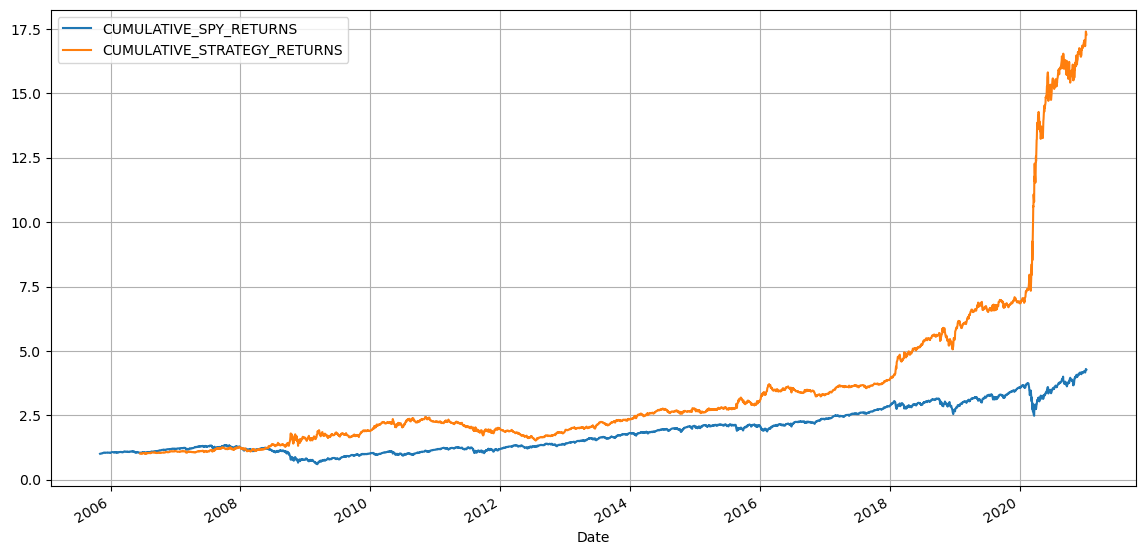

In [25]:
df_new[['CUMULATIVE_SPY_RETURNS','CUMULATIVE_STRATEGY_RETURNS']].plot(figsize = [14,7], grid = True)

In [26]:
#Combined TRAIN and TEST DATASET

# Define ranges for tuning
a_values = [6]  # from TRAINING DATASET
b_values = [149]   # from TRAINING DATASET

# Run the TSMOM strategy with hyperparameter tuning
best_params = vectorized_TSMOM_strategy(df, a_values, b_values)

print(f"Best parameters (a, b): ({best_params['a']}, {best_params['b']})")
print(f"Maximum cumulative return: {best_params['cumulative_return']}")


Best parameters (a, b): (6, 149)
Maximum cumulative return: 38.046293761648826


In [27]:
df2 = TSMOM_strategy(df.copy(), 6, 149)
time_series_2_result_df = df2.copy()
df2[['RETURNS','STRATEGY','CUMULATIVE_SPY_RETURNS','CUMULATIVE_STRATEGY_RETURNS']].tail()

RETURNS  STRATEGY  CUMULATIVE_SPY_RETURNS  \
Date                                                     
2024-10-24  0.002160  0.002160                6.896442   
2024-10-25 -0.000345 -0.000345                6.894061   
2024-10-28  0.003087  0.003087                6.915373   
2024-10-29  0.001617  0.001617                6.926565   
2024-10-30 -0.003030 -0.003030                6.905610   

            CUMULATIVE_STRATEGY_RETURNS  
Date                                     
2024-10-24                    34.883324  
2024-10-25                    34.871279  
2024-10-28                    34.979080  
2024-10-29                    35.035689  
2024-10-30                    34.929697

<Axes: xlabel='Date'>

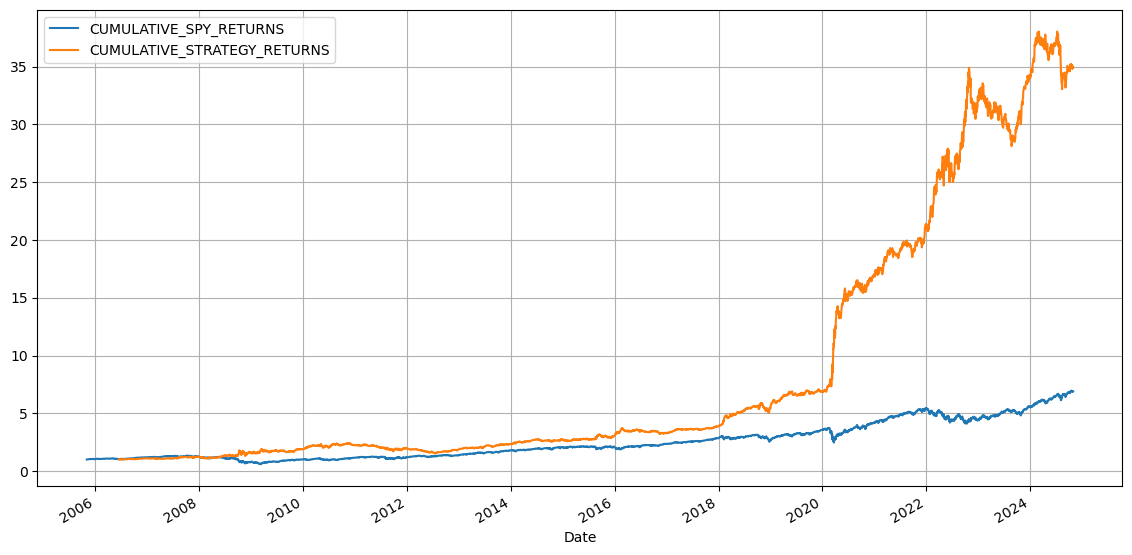

In [28]:
df2[['CUMULATIVE_SPY_RETURNS','CUMULATIVE_STRATEGY_RETURNS']].plot(figsize = [14,7], grid = True)

### 1.1.5. Logistic Regression (Supervised Machine Learning) (Kevin)
- Long Signal:
Prediction of future return by the model is positive.
- Short Signal:
Prediction of future return by the model is negative.
- Hyperparameter to Tune:
  - lags: The number of lagged returns used as features for prediction. The number of lags determines how much historical information is used by the logistic regression model to predict future returns.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score

def logistic_regression_with_lag(df, lags):
 
    # Calculate log returns
    df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df = df.dropna()

    cols = []

    # Create lagged features
    for lag in range(1, lags + 1):
        col = f"lag_{lag}"
        df[col] = df["return"].shift(lag)
        cols.append(col)

    df = df.dropna()

    # Logistic regression model
    M = linear_model.LogisticRegression(solver="lbfgs",
                                        C=1e7,
                                        multi_class="auto",
                                        max_iter=1000)
    M.fit(df[cols], np.sign(df["return"]))

    df['prediction'] = M.predict(df[cols])

    # Compute accuracy and strategy returns
    acc_score = accuracy_score(df["prediction"], np.sign(df["return"]))
    df["strategy"] = df["prediction"] * df["return"]  # Strategy log returns

    # Add cumulative returns and strategy returns
    df["cum_return"] = df["return"].cumsum().apply(np.exp)
    df["cum_strategy_return"] = df["strategy"].cumsum().apply(np.exp)

    return acc_score, df["cum_strategy_return"].iloc[-1], df

def tune_logistic_regression(df, lag_range):

    best_lag = None
    best_score = -np.inf
    best_df = None
    results = []

    for lags in lag_range:
        acc_score, cum_return, temp_df = logistic_regression_with_lag(df.copy(), lags)
        results.append((lags, acc_score, cum_return))

        # Update best parameters if current return is better
        if cum_return > best_score:
            best_score = cum_return
            best_lag = lags
            best_df = temp_df

    # Plot results for the best lag
    plt.figure(figsize=(18, 7))
    plt.plot(best_df.index, best_df["cum_strategy_return"], label='Strategy Cumulative Returns')
    plt.plot(best_df.index, best_df["cum_return"], label='SPY Buy & Hold Returns')
    plt.legend()
    plt.grid()
    plt.title(f"Logistic Regression Strategy Performance (Best Lag: {best_lag})")
    plt.show()

    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results, columns=["Lag", "Accuracy", "Cumulative Return"])

    return best_lag, best_score, best_df, results_df


[*********************100%%**********************]  1 of 1 completed


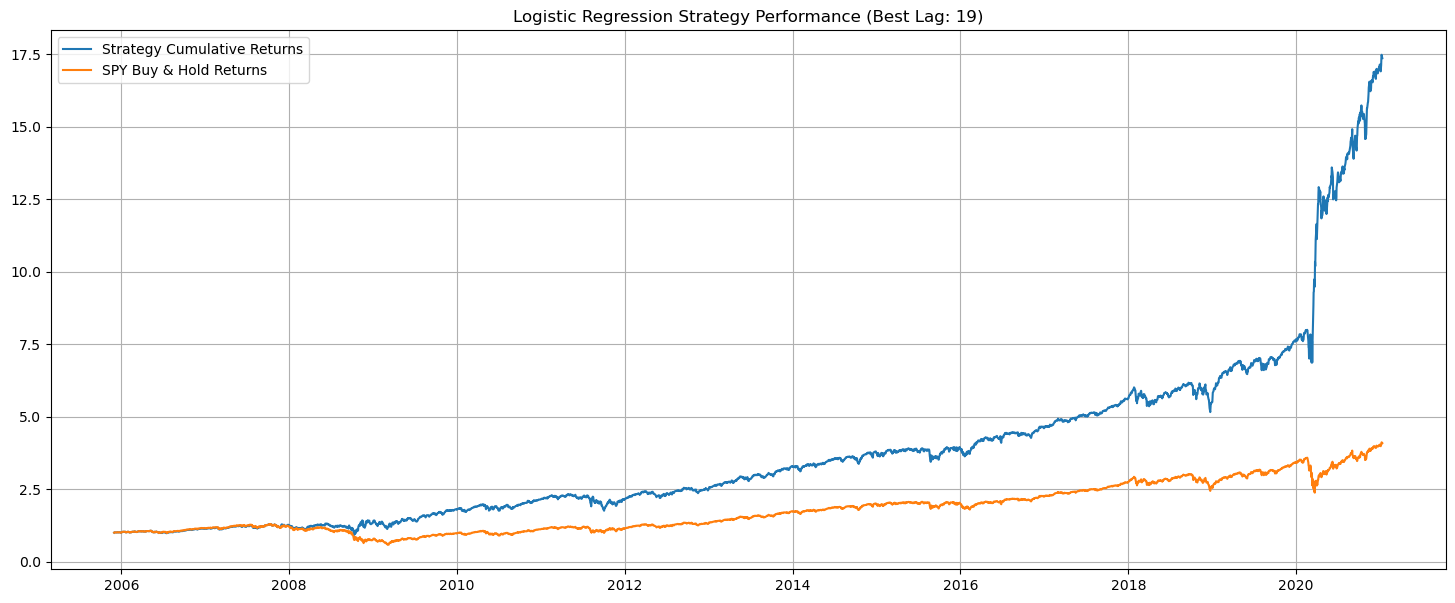

Best Lag: 19
Best Cumulative Return: 17.357874027329434


return  strategy  cum_return  cum_strategy_return
Date                                                           
2021-01-05  0.006864  0.006864    4.003406            17.020515
2021-01-06  0.005961  0.005961    4.027340            17.122272
2021-01-07  0.014748  0.014748    4.087177            17.376670
2021-01-08  0.005682  0.005682    4.110465            17.475677
2021-01-11 -0.006764 -0.006764    4.082756            17.357874

In [31]:
# Fetch SPY data from yfinance
df = yf.download("SPY", start="2005-11-01", end="2024-10-31")

df = df[:int(0.8*len(df))]

# Define range of lags to test
lag_range = range(1, 21)  # Test lags from 1 to 20

# Run the tuning function
best_lag, best_score, best_df, results_df = tune_logistic_regression(df, lag_range)

print(f"Best Lag: {best_lag}")
print(f"Best Cumulative Return: {best_score}")

# Display best DataFrame
best_df[["return", "strategy", "cum_return", "cum_strategy_return"]].tail()



[*********************100%%**********************]  1 of 1 completed


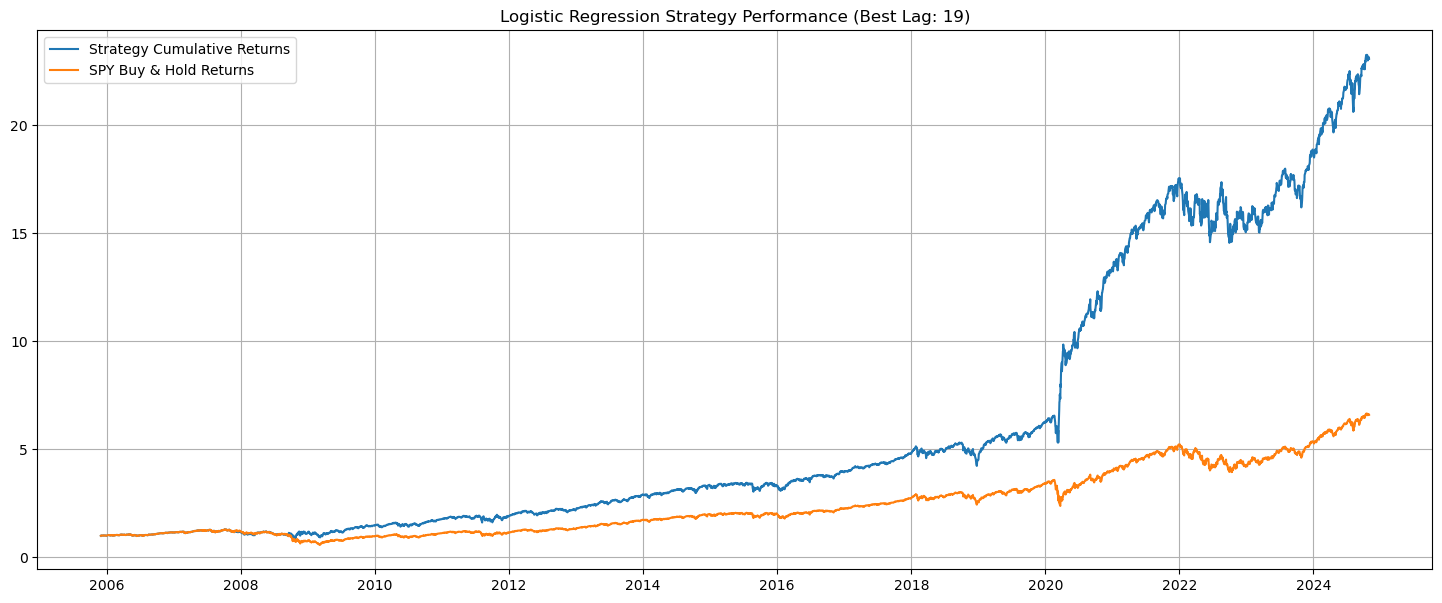

Best Lag: 19
Best Cumulative Return: 23.083696879247434


return  strategy  cum_return  cum_strategy_return
Date                                                           
2024-10-24  0.002160  0.002160    6.590151            23.053051
2024-10-25 -0.000345 -0.000345    6.587875            23.045091
2024-10-28  0.003087  0.003087    6.608241            23.116332
2024-10-29  0.001617  0.001617    6.618936            23.153743
2024-10-30 -0.003030 -0.003030    6.598912            23.083697

In [32]:
#Combined TEST and TRAIN dataset

df = yf.download("SPY", start="2005-11-01", end="2024-10-31")

# Define range of lags to test
lag_range = [19]  # from TRAIN DATASET

# Run the tuning function
best_lag, best_score, best_df, results_df = tune_logistic_regression(df, lag_range)

print(f"Best Lag: {best_lag}")
print(f"Best Cumulative Return: {best_score}")

# Display best DataFrame
logistic_regression_df = best_df.copy()
best_df[["return", "strategy", "cum_return", "cum_strategy_return"]].tail()



### 1.1.6. Mean Reversion Strategy (Kevin)
- Long Signal:
Generated when the price falls below the SMA by more than the threshold (distance < -threshold). Means buy when the price has fallen significantly below the moving average.
- Short Signal:
Generated when the price rises above the SMA by more than the threshold (distance > threshold). Means sell when the price has risen significantly below the moving average.
- Hyperparameters:
  - Window (SMA Window Size): Determines the sensitivity of the moving average.
  - Threshold: Defines the level of deviation from the SMA that triggers a trade.

In [34]:
from itertools import product

# Mean Reversion Strategy Function
def mean_reversion_strategy(data, window, threshold):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data
    signals['SMA'] = data.rolling(window=window, min_periods=window).mean()
    signals['distance'] = signals['price'] - signals['SMA']
    signals['position'] = np.nan
    signals['position'] = np.where(signals['distance'] > threshold, -1, signals['position'])
    signals['position'] = np.where(signals['distance'] < -threshold, 1, signals['position'])
    signals['position'] = signals['position'].ffill().fillna(0)
    return signals

# Backtest and evaluate strategy performance
def evaluate_strategy(signals):
    signals['SPY_return'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_return'] = signals['position'].shift(1) * signals['SPY_return']
    cum_strategy_return = signals['strategy_return'].cumsum()
    return cum_strategy_return.iloc[-1]  # Final cumulative return

# Hyperparameter Tuning
def tune_strategy(data, window_range, threshold_range):
    best_params = None
    best_return = -np.inf
    best_signals = None

    for window, threshold in product(window_range, threshold_range):
        signals = mean_reversion_strategy(data, window, threshold)
        if len(signals) < 1:  # Skip empty signals (e.g., no trades)
            continue
        cum_return = evaluate_strategy(signals)
        if cum_return > best_return:
            best_return = cum_return
            best_params = (window, threshold)
            best_signals = signals

    return best_params, best_return, best_signals

# Plot Results
def plot_best_strategy(data, best_signals, best_params):
    best_signals['cum_SPY_return'] = best_signals['SPY_return'].cumsum()
    best_signals['cum_strategy_return'] = best_signals['strategy_return'].cumsum()

    plt.figure(figsize=(18, 7))
    plt.plot(np.exp(best_signals['cum_SPY_return']), label='SPY Return')
    plt.plot(np.exp(best_signals['cum_strategy_return']), label='Strategy Return')
    plt.title(f"Best Mean Reversion Strategy (Window={best_params[0]}, Threshold={best_params[1]})")
    plt.legend()
    plt.show()




Best Parameters: (5, 2.5), Best Return: 0.6037


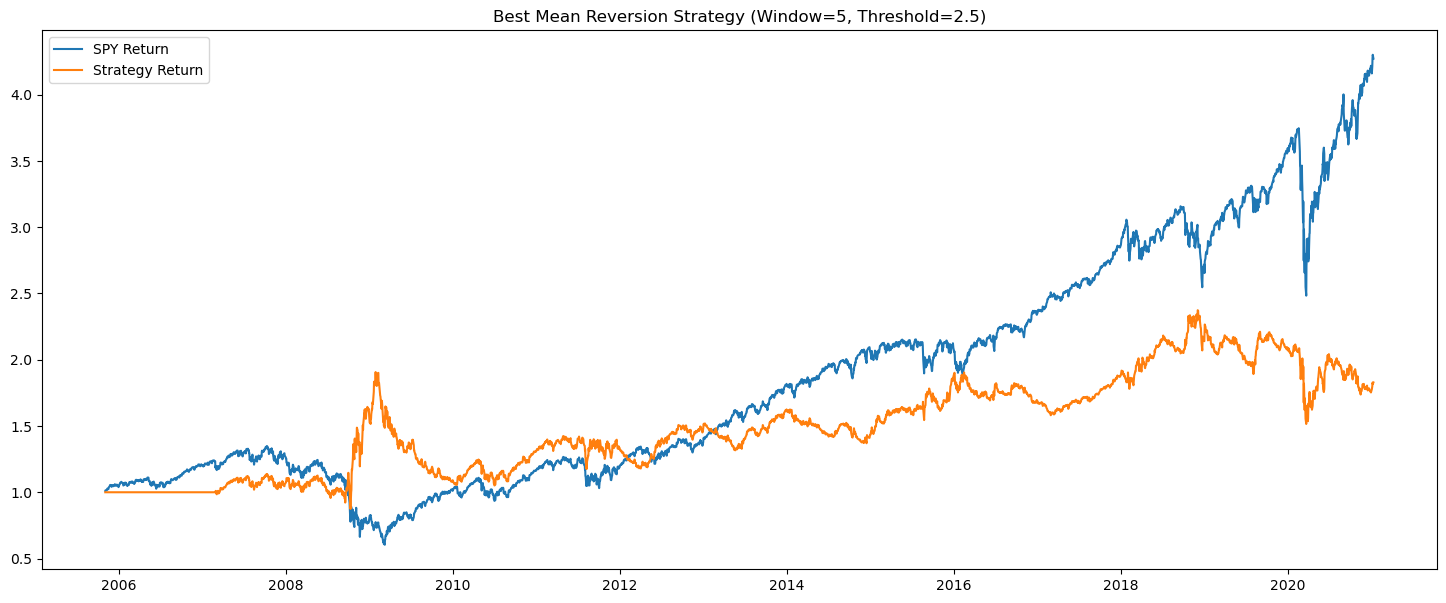

In [35]:
# TRAINING DATASET 

data = df[['Adj Close']][:int(0.8*len(df))]

window_range = range(5, 21, 5)  # Example: Windows from 5 to 20
threshold_range = np.arange(1.0, 3.1, 0.5)  # Example: Thresholds from 1.0 to 3.0


# Assuming 'data' is a Series of adjusted close prices
best_params, best_return, best_signals = tune_strategy(data, window_range, threshold_range)
print(f"Best Parameters: {best_params}, Best Return: {best_return:.4f}")

# Plot the best strategy
plot_best_strategy(data, best_signals, best_params)
mean_reversion_result_df = best_signals

Best Parameters: (5, 2.5), Best Return: 0.7946


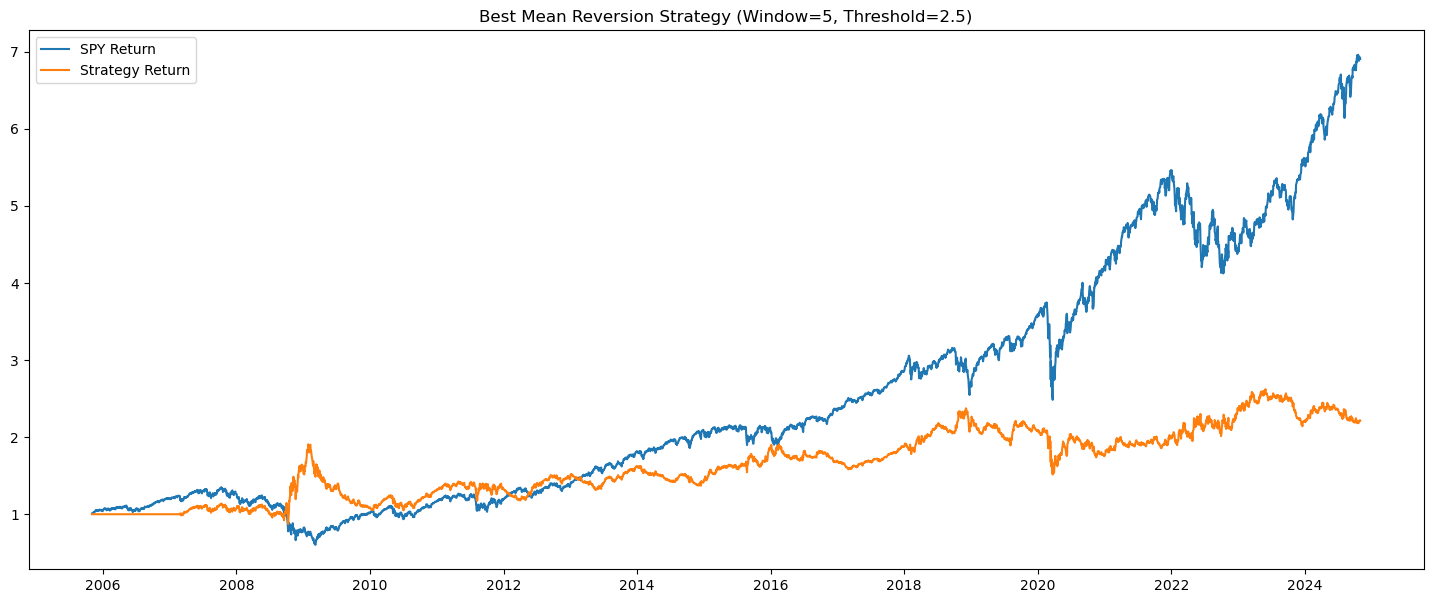

In [36]:
# Combined TEST and TRAINING DATASET 

data = df[['Adj Close']]

window_range = [5]
threshold_range = [2.5]


# Assuming 'data' is a Series of adjusted close prices
best_params, best_return, best_signals = tune_strategy(data, window_range, threshold_range)
print(f"Best Parameters: {best_params}, Best Return: {best_return:.4f}")

# Plot the best strategy
plot_best_strategy(data, best_signals, best_params)
mean_reversion_result_df = best_signals

In [37]:
mean_reversion_result_df['cum_strategy_return'] = mean_reversion_result_df['cum_strategy_return'].apply(np.exp)

In [38]:
mean_reversion_result_df['cum_SPY_return'] = mean_reversion_result_df['cum_SPY_return'].apply(np.exp)

In [39]:
mean_reversion_result_df

price         SMA  distance  position  SPY_return  \
Date                                                                 
2005-11-01   83.991135         NaN       NaN       0.0         NaN   
2005-11-02   84.869461         NaN       NaN       0.0    0.010403   
2005-11-03   85.231956         NaN       NaN       0.0    0.004262   
2005-11-04   85.120399         NaN       NaN       0.0   -0.001310   
2005-11-07   85.204063   84.883403  0.320660       0.0    0.000982   
...                ...         ...       ...       ...         ...   
2024-10-24  579.239990  581.754004 -2.514014       1.0    0.002160   
2024-10-25  579.039978  580.643994 -1.604016       1.0   -0.000345   
2024-10-28  580.830017  580.083997  0.746021       1.0    0.003087   
2024-10-29  581.770020  579.773999  1.996021       1.0    0.001617   
2024-10-30  580.010010  580.178003 -0.167993       1.0   -0.003030   

            strategy_return  cum_SPY_return  cum_strategy_return  
Date                                                              
2005-11-01              NaN             NaN                  NaN  
2005-11-02         0.000000        1.010457             1.000000  
2005-11-03         0.000000        1.014773             1.000000  
2005-11-04        -0.000000        1.013445             1.000000  
2005-11-07         0.000000        1.014441             1.000000  
...                     ...             ...                  ...  
2024-10-24         0.002160        6.896442             2.210533  
2024-10-25        -0.000345        6.894061             2.209770  
2024-10-28         0.003087        6.915373             2.216601  
2024-10-29         0.001617        6.926565             2.220188  
2024-10-30        -0.003030        6.905610             2.213472  

[4781 rows x 8 columns]

### 1.1.7. PCA (weight allocation strategy) (Kevin)
- Combinations of all the strategies that have been analysed in the previous sections
- PCA helped to assign weights to each strategies to find the best performance
- Compare and get the best portfolios

In [41]:
# sma_result_df[['strategy_returns']]                     #log_return
# ewma_result_df[['strategy_returns']]                   #log_return
# time_series_result_df[['strategy_returns']]          #log_return
# time_series_2_result_df[['STRATEGY']]            #log_return
# logistic_regression_df[['strategy']]           #log return
# mean_reversion_result_df[['strategy_return']]         #log return


In [42]:
#Import Data
data2 = pd.concat([
                  sma_result_df[['strategy_returns']],                     #log_return
    ewma_result_df[['strategy_returns']]            ,       #log_return
    time_series_result_df[['strategy_returns']]   ,       #log_return
    time_series_2_result_df[['STRATEGY']]        ,    #log_return
    # logistic_regression_df[['strategy']]         ,  #log return
    mean_reversion_result_df[['strategy_return']]]  ,         axis = 1)

data2 = data2.dropna()

In [43]:
data2.columns = ['sma_strategy',
                 'ewma_strategy',
                 'tsmom_strategy1',
                 'tsmom_strategy2',
                 # 'logistic_reg_strategy',
                 'mean_reversion_strategy']

data2

sma_strategy  ewma_strategy  tsmom_strategy1  tsmom_strategy2  \
Date                                                                        
2006-06-15      0.000000       0.000000         0.020993         0.020993   
2006-06-16      0.000000       0.000000        -0.007315        -0.007315   
2006-06-19      0.000000       0.000000         0.007893        -0.007893   
2006-06-20      0.000000       0.000000        -0.003390         0.003390   
2006-06-21      0.000000       0.000000         0.007387         0.007387   
...                  ...            ...              ...              ...   
2024-10-24      0.002592       0.002342        -0.002160         0.002160   
2024-10-25     -0.000414      -0.000374        -0.000345        -0.000345   
2024-10-28      0.003702       0.003345        -0.003087         0.003087   
2024-10-29      0.001938       0.001752         0.001617         0.001617   
2024-10-30     -0.003633      -0.003283        -0.003030        -0.003030   

            mean_reversion_strategy  
Date                                 
2006-06-15                 0.000000  
2006-06-16                -0.000000  
2006-06-19                -0.000000  
2006-06-20                 0.000000  
2006-06-21                 0.000000  
...                             ...  
2024-10-24                 0.002160  
2024-10-25                -0.000345  
2024-10-28                 0.003087  
2024-10-29                 0.001617  
2024-10-30                -0.003030  

[4626 rows x 5 columns]

In [44]:
data2.isnull().sum()

sma_strategy               0
ewma_strategy              0
tsmom_strategy1            0
tsmom_strategy2            0
mean_reversion_strategy    0
dtype: int64

In [45]:
Daily_Linear_Return = data2

Daily_Linear_Return.head()

sma_strategy  ewma_strategy  tsmom_strategy1  tsmom_strategy2  \
Date                                                                        
2006-06-15           0.0            0.0         0.020993         0.020993   
2006-06-16           0.0            0.0        -0.007315        -0.007315   
2006-06-19           0.0            0.0         0.007893        -0.007893   
2006-06-20           0.0            0.0        -0.003390         0.003390   
2006-06-21           0.0            0.0         0.007387         0.007387   

            mean_reversion_strategy  
Date                                 
2006-06-15                      0.0  
2006-06-16                     -0.0  
2006-06-19                     -0.0  
2006-06-20                      0.0  
2006-06-21                      0.0

In [46]:
Daily_Linear_Return =\
(
    Daily_Linear_Return[Daily_Linear_Return 
                        .apply(lambda x:(x - x.mean()
                                        ).abs() < (3 * x.std()
                                                  )
                              )
                        .all(1)
    ]
)

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scaler =\
(
    StandardScaler()
    .fit(Daily_Linear_Return)
)

In [49]:
scaler

StandardScaler()

In [50]:
scaled_data =\
(
    pd
    .DataFrame(scaler.fit_transform(Daily_Linear_Return),
               columns = Daily_Linear_Return.columns,
               index = Daily_Linear_Return.index)
)

scaled_data.describe()

sma_strategy  ewma_strategy  tsmom_strategy1  tsmom_strategy2  \
count  4.461000e+03   4.461000e+03     4.461000e+03     4.461000e+03   
mean  -1.274230e-17   3.504134e-17     3.265215e-17    -2.070624e-17   
std    1.000112e+00   1.000112e+00     1.000112e+00     1.000112e+00   
min   -3.584596e+00  -3.504968e+00    -3.901669e+00    -3.689646e+00   
25%   -3.157113e-01  -3.781121e-01    -5.215106e-01    -5.226703e-01   
50%   -9.566315e-02  -1.019178e-01     3.858646e-03    -2.785226e-02   
75%    3.966933e-01   4.588893e-01     5.154275e-01     5.183715e-01   
max    3.546718e+00   3.432563e+00     3.904658e+00     3.833317e+00   

       mean_reversion_strategy  
count             4.461000e+03  
mean             -1.274230e-17  
std               1.000112e+00  
min              -3.935127e+00  
25%              -5.059422e-01  
50%              -1.422387e-02  
75%               5.052321e-01  
max               3.911432e+00

In [51]:
#DATA TRAIN TEST SPLIT

In [52]:
prop =\
    int(len(scaled_data) * 0.80)

X_Train = scaled_data[    : prop] # First 80% of the data
X_Test  = scaled_data[prop:     ] # Remaining 20% of the data

X_Train_Raw = Daily_Linear_Return[    :prop]
X_Test_Raw  = Daily_Linear_Return[prop:    ]

In [53]:
strat_name =\
(
 scaled_data
 .columns
 .values
)

strat_name

array(['sma_strategy', 'ewma_strategy', 'tsmom_strategy1',
       'tsmom_strategy2', 'mean_reversion_strategy'], dtype=object)

In [54]:
from sklearn.decomposition import PCA

pca = PCA()

PrincipalComponent = pca.fit(X_Train) #calculate it using PCA

In [55]:
pca.components_

array([[ 0.67032436,  0.67421082, -0.04026309,  0.2807968 ,  0.12504824],
       [ 0.17633385,  0.16724691,  0.61340654, -0.47540382, -0.5819437 ],
       [-0.07783084, -0.04596695,  0.7421286 ,  0.11097916,  0.65479628],
       [-0.11733869, -0.12525462,  0.26689229,  0.82633231, -0.46528091],
       [ 0.70692689, -0.70687096,  0.01117835,  0.00170202,  0.02144689]])

In [56]:
NumEigenValues = 5

<Axes: title={'center': 'Cumulative Explained Variance by Each PC'}>

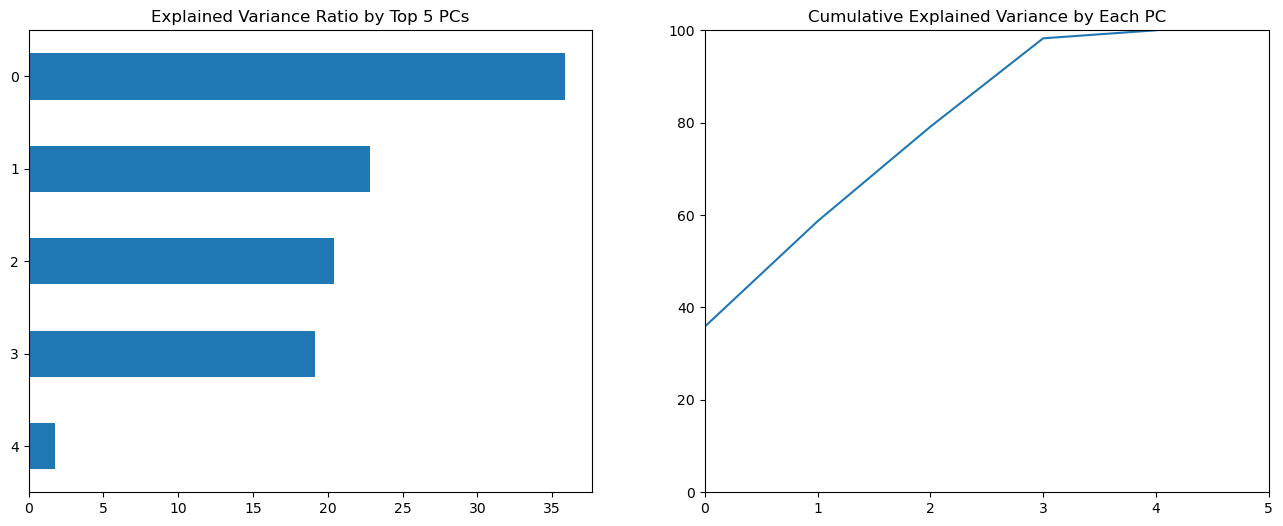

In [57]:
fig, axes =\
(
    plt
    .subplots(ncols = 2,
              figsize = [16, 6]
             )
)

# Plot on the left panel

Series1 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .sort_values()
    * 100
)

# Plot on the right panel

Series2 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .cumsum()
    * 100
)

(
    Series1
    .plot
    .barh(ylim = (0, 5),
          title = "Explained Variance Ratio by Top 5 PCs",
          ax = axes[0]
         )
)

(
    Series2
    .plot(ylim = (0, 100),
          xlim = (0, 5),
          title = "Cumulative Explained Variance by Each PC",
          ax = axes[1]
         )
)

In [58]:
(
    pd
    .Series(np
           .cumsum(pca
                   .explained_variance_ratio_)
           )
    .to_frame("Explained Variance")
    .head(NumEigenValues)
    .style
    .format("{:,.2%}".format)
)

In [59]:
#Portfolio Weights

In [60]:
def PCWeights():

    weights = pd.DataFrame()

    for i in range(len(pca.components_)
                  ):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i]
                                                                  )

    weights = weights.values.T
    return weights # Team, be careful with indentation

In [61]:
weights = PCWeights()

In [62]:
# Set the number of principal components to be considered
NumComponents = 5

# Extract the top principal components from the PCA object
# and create a DataFrame with columns named after the original features

topPortfolios =\
(
    pd
    .DataFrame(pca.components_[ : NumComponents],
               columns = data2.columns)
)

# Normalize the weights of the top portfolios such that the weights sum up to 1 for each portfolio
# This is done by dividing each weight by the sum of weights for the respective portfolio

eigen_portfolios =\
(
    topPortfolios
    .div(topPortfolios.sum(1),
         axis = 0)
)

# Rename the index of the eigen_portfolios DataFrame for better readability

eigen_portfolios.index = [f"Portfolio {i}" for i in range(NumComponents)
                         ]

# Calculate the square root of the explained variance for each component
# This provides the standard deviation of returns for each eigenportfolio

np.sqrt(pca.explained_variance_)

array([1.30438889, 1.03973351, 0.98458658, 0.95210627, 0.2872377 ])

In [63]:
eigen_portfolios

sma_strategy  ewma_strategy  tsmom_strategy1  tsmom_strategy2  \
Portfolio 0      0.391976       0.394248        -0.023544         0.164197   
Portfolio 1     -1.757009      -1.666466        -6.112048         4.736974   
Portfolio 2     -0.056232      -0.033211         0.536179         0.080181   
Portfolio 3     -0.304499      -0.325041         0.692596         2.144366   
Portfolio 4     20.560245     -20.558618         0.325111         0.049502   

             mean_reversion_strategy  
Portfolio 0                 0.073123  
Portfolio 1                 5.798549  
Portfolio 2                 0.473082  
Portfolio 3                -1.207423  
Portfolio 4                 0.623761

In [64]:
eigen_portfolios.iloc[0].sum()

0.9999999999999998

array([[<Axes: title={'center': 'Portfolio 0'}>],
       [<Axes: title={'center': 'Portfolio 1'}>],
       [<Axes: title={'center': 'Portfolio 2'}>],
       [<Axes: title={'center': 'Portfolio 3'}>],
       [<Axes: title={'center': 'Portfolio 4'}>]], dtype=object)

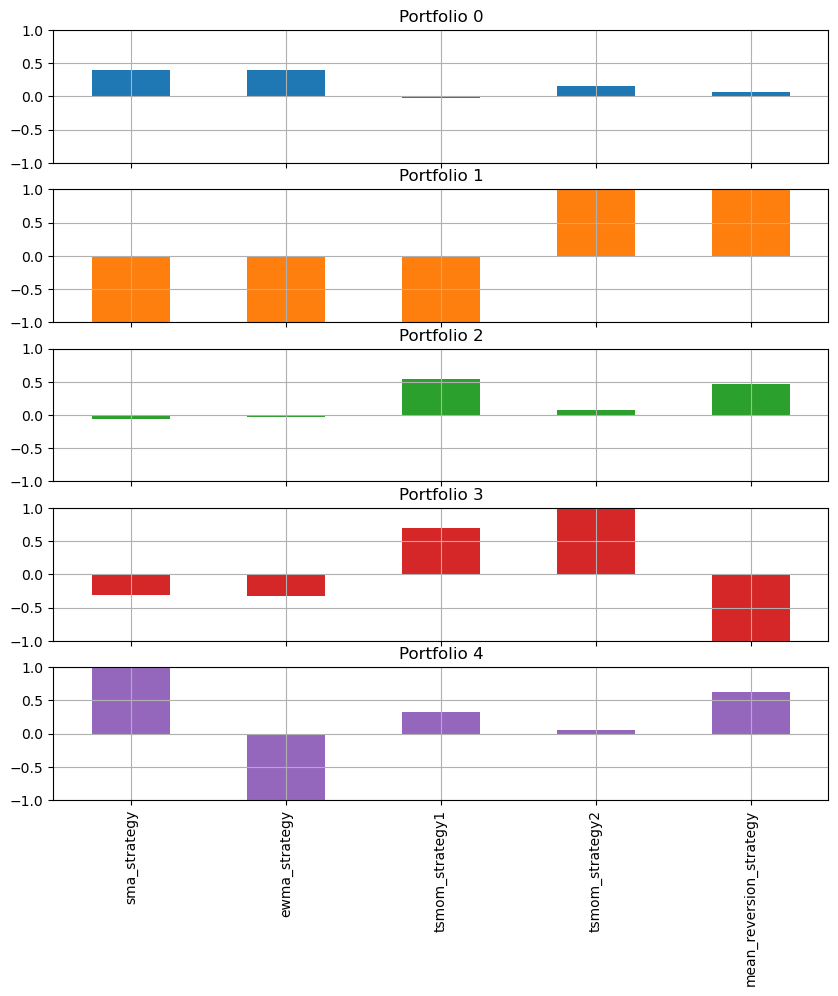

In [65]:
(
    eigen_portfolios
    .T  # Transpose the DataFrame to have portfolios as columns and assets as rows
    .plot
    .bar(subplots = True,
         layout = (int(NumComponents), 1),
         legend = False,
         sharey = True,
         figsize = [10, 10],
         ylim = [-1, 1],
         grid = True
        )
)

In [66]:
def calculate_sharpe_ratio(ts_returns, periods_per_year = 252):

    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)
                                ) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    return annualized_return, annualized_vol, annualized_sharpe


def valid_backtest_PCA_porfolios(eigen):
    eigen_prtfi =\
        (
            pd
            .DataFrame(data = {"weights": eigen.squeeze()
                              },
                       index = strat_name)
        )

    # Sanity Check: Ensure the order of tickers in X_Test_Raw matches the order in eigen
    if not list(eigen_prtfi.index) == list(X_Test_Raw.columns): 
        raise ValueError("Sanity check failed: Mismatch in number of tickers between X_Test_Raw and eigen.")
    else:
        print("Prof. Roh's Message: 'Sanity check succeeded :)' The order of tickers in X_Test_Raw matches the order in eigen.")
    
    # Let's directly compute the dot product without sorting
    eigen_prtfi_returns =\
    (
        np
        .dot(X_Test_Raw, eigen)
    )
    
    eigen_portfolio_returns =\
    (
        pd
        .Series(eigen_prtfi_returns.squeeze(),
                index = X_Test_Raw.index)
    )

    returns, vol, sharpe = calculate_sharpe_ratio(eigen_portfolio_returns)
    sharpe_ratios.append(sharpe)
    return_list.append(returns)
    portfolio_list.append(i)

    equal_weight_return =\
    (
        X_Test_Raw * (1 / len(pca.components_)
                     )
    ).sum(axis = 1)


In [67]:
sharpe_ratios = []
return_list = []
portfolio_list = []

for i in range(5):
    valid_backtest_PCA_porfolios(eigen = weights[i])   

df = pd.DataFrame({'Portfolio' : portfolio_list,
                   'Returns' : return_list,
                   'Sharpe Ratio' : sharpe_ratios})

df.sort_values(by = 'Sharpe Ratio', ascending = False)

Prof. Roh's Message: 'Sanity check succeeded :)' The order of tickers in X_Test_Raw matches the order in eigen.
Prof. Roh's Message: 'Sanity check succeeded :)' The order of tickers in X_Test_Raw matches the order in eigen.
Prof. Roh's Message: 'Sanity check succeeded :)' The order of tickers in X_Test_Raw matches the order in eigen.
Prof. Roh's Message: 'Sanity check succeeded :)' The order of tickers in X_Test_Raw matches the order in eigen.
Prof. Roh's Message: 'Sanity check succeeded :)' The order of tickers in X_Test_Raw matches the order in eigen.


Portfolio   Returns  Sharpe Ratio
0          0  0.171433      2.068124
3          3  0.458744      1.162065
2          2  0.044088      0.467112
1          1 -0.301432     -0.205829
4          4 -0.433168     -0.419663

In [68]:
def valid_backtest_PCA_porfolios_plot(eigen):
    eigen_prtfi =\
        (
            pd
            .DataFrame(data = {"weights": eigen.squeeze()
                              },
                       index = strat_name)
        )

    eigen_prtfi_returns = np.dot(X_Test_Raw, eigen)
    
    eigen_portfolio_returns = pd.Series(eigen_prtfi_returns.squeeze(),
                index = X_Test_Raw.index)

    returns, vol, sharpe = calculate_sharpe_ratio(eigen_portfolio_returns)

    print("Our PCA-based Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f"  %
          (returns * 100, vol * 100, sharpe))

    # Compared with Equal-weightage Portfolio
    equal_weight_return =\
    (
        X_Test_Raw * (1 / len(pca.components_))
    ).sum(axis = 1)

    df_plot =\
        (
            pd
            .DataFrame({"ML Portfolio Return": eigen_portfolio_returns,
                        "Equal Weight Index": equal_weight_return},
                      index = X_Test.index
                      )
        )

    (
        np
        .cumprod(df_plot + 1)
        .plot(title = "Returns of the equal weighted index vs. Eigen-Portfolio",
              figsize = [16, 8]
             )
    )

    plt.show()

PORTFOLIO_0
Our PCA-based Portfolio:
Return = 17.14%
Volatility = 8.29%
Sharpe = 2.07


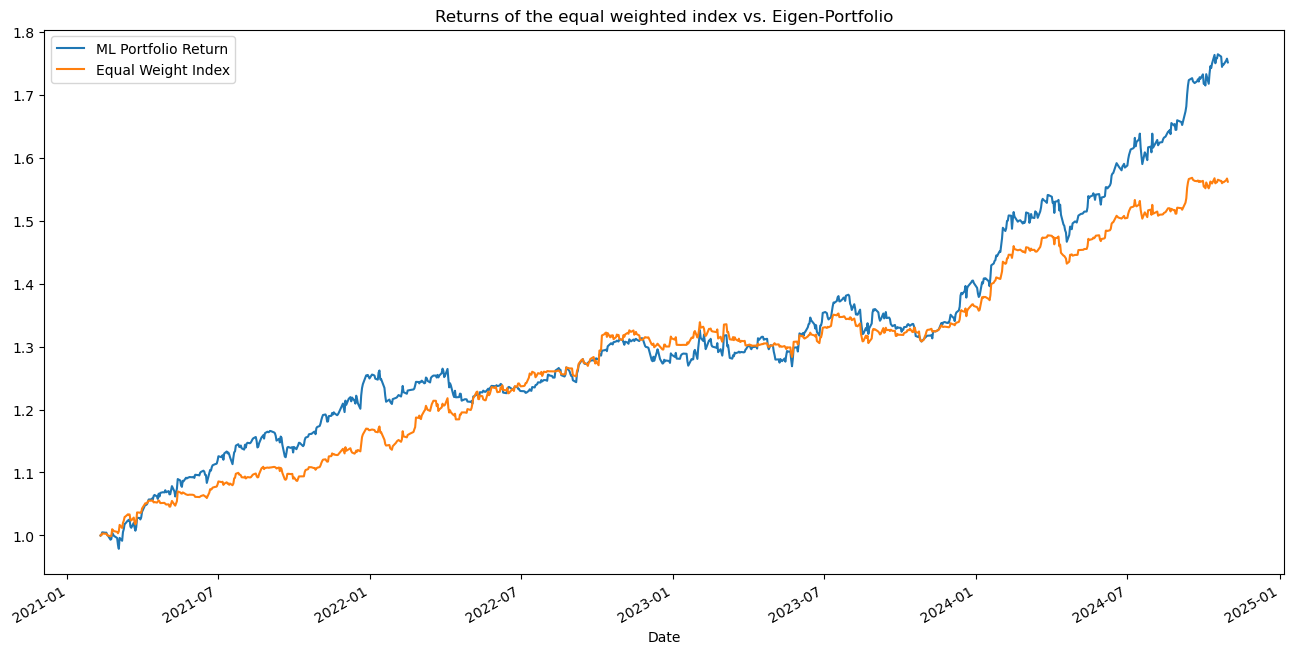

PORTFOLIO_1
Our PCA-based Portfolio:
Return = -30.14%
Volatility = 146.45%
Sharpe = -0.21


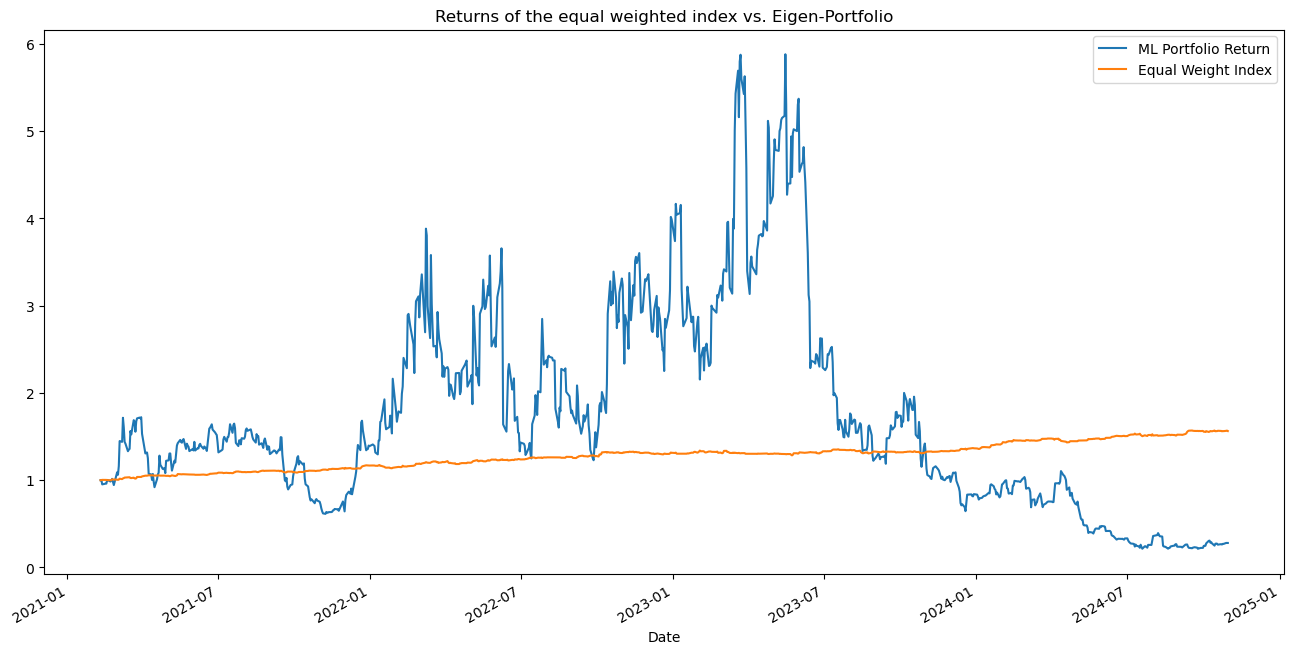

PORTFOLIO_2
Our PCA-based Portfolio:
Return = 4.41%
Volatility = 9.44%
Sharpe = 0.47


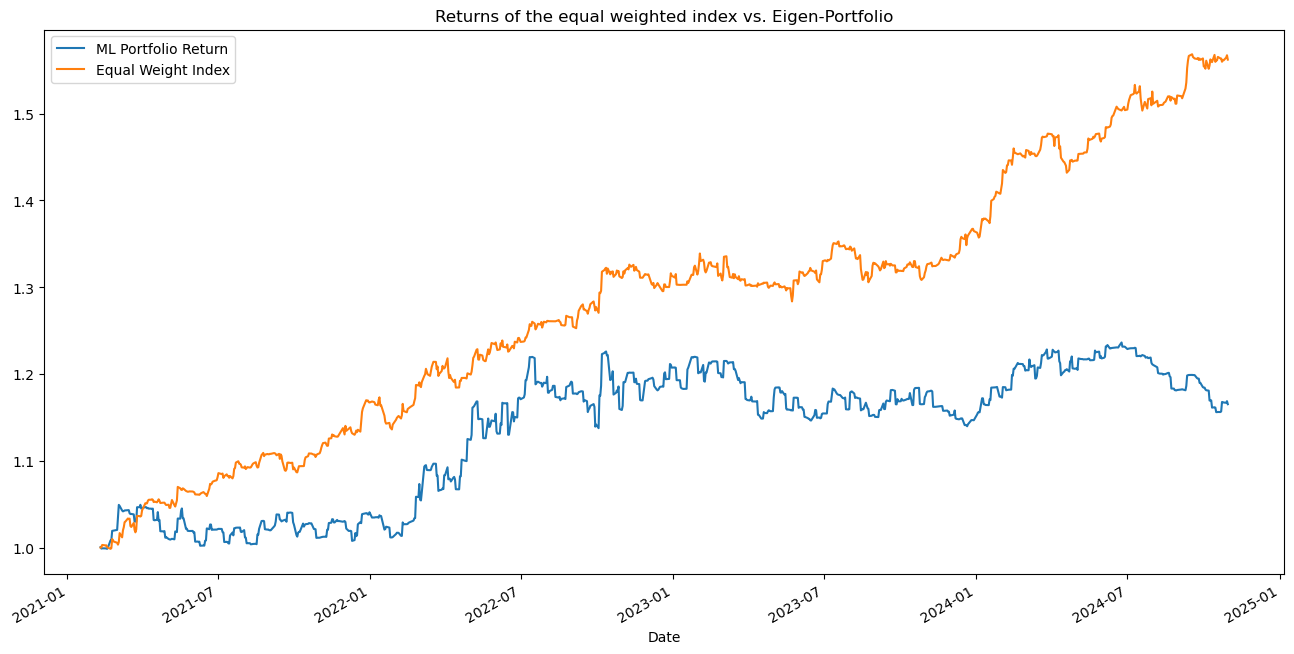

PORTFOLIO_3
Our PCA-based Portfolio:
Return = 45.87%
Volatility = 39.48%
Sharpe = 1.16


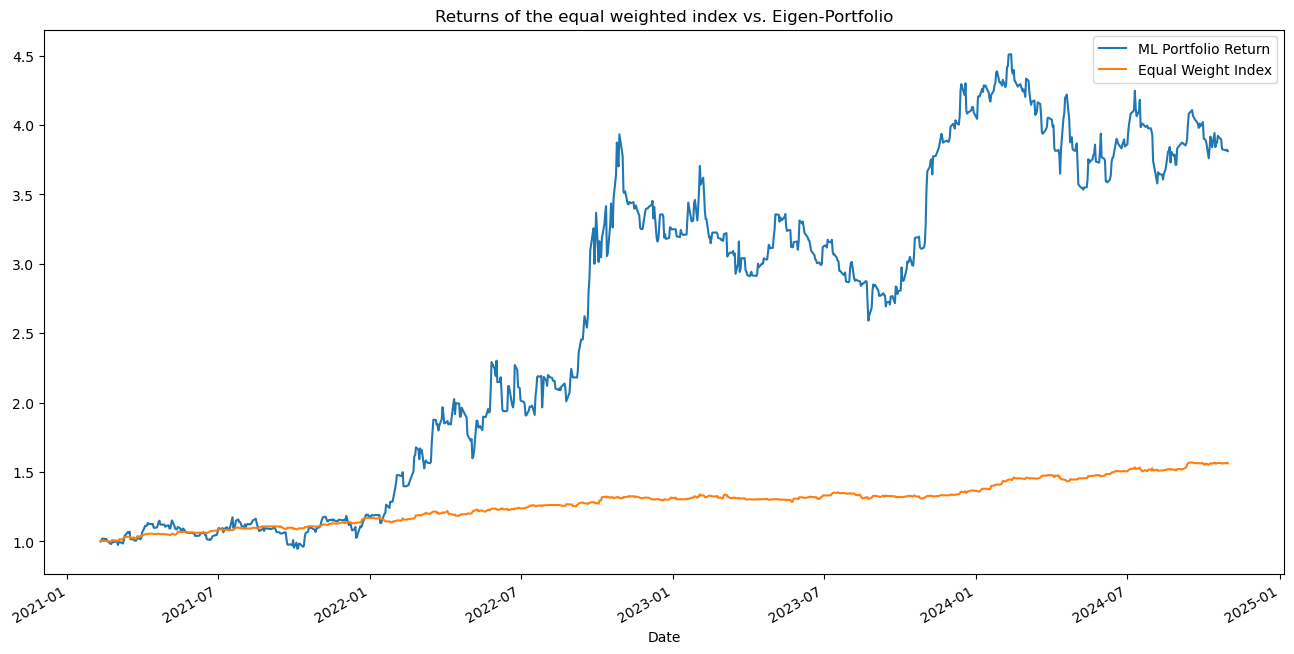

PORTFOLIO_4
Our PCA-based Portfolio:
Return = -43.32%
Volatility = 103.22%
Sharpe = -0.42


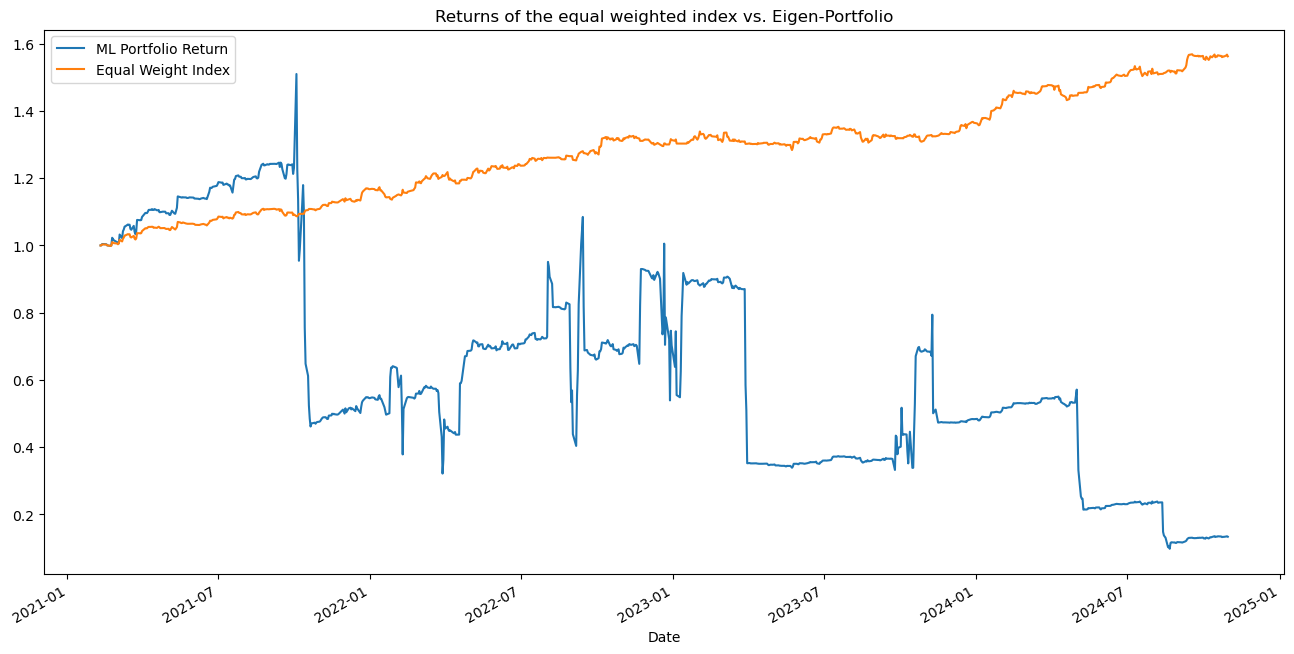

In [69]:
for i in range(5):
    print(f'PORTFOLIO_{i}')
    valid_backtest_PCA_porfolios_plot(eigen = weights[i])

In [70]:
#From the result above, looks like portfolio[3] has the best result

In [71]:
eigen_portfolios

sma_strategy  ewma_strategy  tsmom_strategy1  tsmom_strategy2  \
Portfolio 0      0.391976       0.394248        -0.023544         0.164197   
Portfolio 1     -1.757009      -1.666466        -6.112048         4.736974   
Portfolio 2     -0.056232      -0.033211         0.536179         0.080181   
Portfolio 3     -0.304499      -0.325041         0.692596         2.144366   
Portfolio 4     20.560245     -20.558618         0.325111         0.049502   

             mean_reversion_strategy  
Portfolio 0                 0.073123  
Portfolio 1                 5.798549  
Portfolio 2                 0.473082  
Portfolio 3                -1.207423  
Portfolio 4                 0.623761

In [72]:
eigen = weights[3]
eigen_prtfi_returns = np.dot(X_Test_Raw, eigen)
    
eigen_portfolio_returns = pd.Series(eigen_prtfi_returns.squeeze(),
                index = X_Test_Raw.index)

returns, vol, sharpe = calculate_sharpe_ratio(eigen_portfolio_returns)

In [73]:
eigen_prtfi_returns_train = np.dot(X_Train_Raw, eigen)
    
eigen_portfolio_returns_train = pd.Series(eigen_prtfi_returns_train.squeeze(),
                index = X_Train_Raw.index)

In [74]:
train_strategy_df = eigen_portfolio_returns_train.to_frame()
train_strategy_df.columns = ['strategy_return']
train_strategy_df

strategy_return
Date                       
2006-06-15         0.059556
2006-06-16        -0.020751
2006-06-19        -0.011459
2006-06-20         0.004922
2006-06-21         0.020956
...                     ...
2021-02-03        -0.000641
2021-02-04         0.039245
2021-02-05         0.013639
2021-02-08         0.024983
2021-02-09        -0.002312

[3568 rows x 1 columns]

In [75]:
test_strategy_df = eigen_portfolio_returns.to_frame()
test_strategy_df.columns = ['strategy_return']
test_strategy_df

strategy_return
Date                       
2021-02-10        -0.000909
2021-02-11         0.003367
2021-02-12         0.017106
2021-02-16        -0.003007
2021-02-17         0.000478
...                     ...
2024-10-24        -0.001023
2024-10-25        -0.000315
2024-10-28        -0.001460
2024-10-29         0.001475
2024-10-30        -0.002764

[893 rows x 1 columns]

In [76]:
pca_strategy_df = pd.concat([train_strategy_df, test_strategy_df])
pca_strategy_df

strategy_return
Date                       
2006-06-15         0.059556
2006-06-16        -0.020751
2006-06-19        -0.011459
2006-06-20         0.004922
2006-06-21         0.020956
...                     ...
2024-10-24        -0.001023
2024-10-25        -0.000315
2024-10-28        -0.001460
2024-10-29         0.001475
2024-10-30        -0.002764

[4461 rows x 1 columns]

In [77]:
pca_strategy_df['cum_strategy_return'] = pca_strategy_df.cumsum().apply(np.exp)
pca_strategy_df['cum_SPY_return'] = mean_reversion_result_df['cum_SPY_return']

In [78]:
pca_strategy_df

strategy_return  cum_strategy_return  cum_SPY_return
Date                                                            
2006-06-15         0.059556             1.061365        1.056460
2006-06-16        -0.020751             1.039568        1.048760
2006-06-19        -0.011459             1.027724        1.040515
2006-06-20         0.004922             1.032794        1.044049
2006-06-21         0.020956             1.054666        1.051790
...                     ...                  ...             ...
2024-10-24        -0.001023            90.088264        6.896442
2024-10-25        -0.000315            90.059896        6.894061
2024-10-28        -0.001460            89.928469        6.915373
2024-10-29         0.001475            90.061234        6.926565
2024-10-30        -0.002764            89.812657        6.905610

[4461 rows x 3 columns]

<Axes: title={'center': 'PCA weight allocation strategy'}, xlabel='Date'>

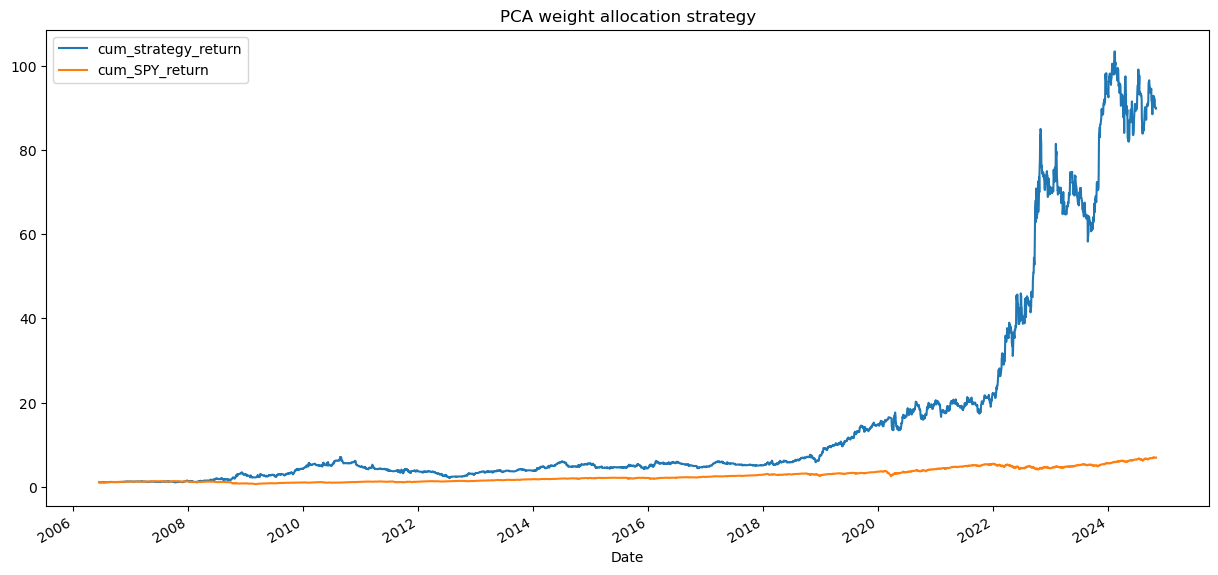

In [79]:
pca_strategy_df[['cum_strategy_return','cum_SPY_return']].plot(figsize = [15,7],
                                                              title = 'PCA weight allocation strategy')

### 7.1 PCA to ML model (for prediction, no strategy), just for trial

In [81]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

import pandas_datareader.data as web
from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(241001)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging (Bootstrap aggregation)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

# for data split (be careful if the regime that we choose is during market shift)
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [82]:
sma_result_df[['cum_strategy_return']]
ewma_result_df[['cum_strategy_return']]
time_series_result_df[['cum_strategy_return']]
time_series_2_result_df[['cum_strategy_return']]
logistic_regression_df[['cum_strategy_return']]
mean_reversion_result_df[['cum_strategy_return']]


cum_strategy_return
Date                           
2005-11-01                  NaN
2005-11-02             1.000000
2005-11-03             1.000000
2005-11-04             1.000000
2005-11-07             1.000000
...                         ...
2024-10-24             2.210533
2024-10-25             2.209770
2024-10-28             2.216601
2024-10-29             2.220188
2024-10-30             2.213472

[4781 rows x 1 columns]

In [83]:
stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)
df = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [84]:
df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df['cum_SPY_return'] = df[['return']].cumsum().apply(np.exp)
df['cum_SPY_pred_return'] = \
    (np
     .log(df['cum_SPY_return'])
     .diff(1)
     .shift(-1)
    )

In [85]:
df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-11-01  120.580002  120.900002  120.220001  120.489998   83.991135   
2005-11-02  120.169998  121.750000  120.129997  121.750000   84.869461   
2005-11-03  122.150002  122.660004  121.750000  122.269997   85.231956   
2005-11-04  122.400002  122.459999  121.550003  122.110001   85.120399   
2005-11-07  122.370003  122.620003  121.849998  122.230003   85.204063   
...                ...         ...         ...         ...         ...   
2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

              Volume    return  cum_SPY_return  cum_SPY_pred_return  
Date                                                                 
2005-11-01  66365100       NaN             NaN                  NaN  
2005-11-02  74012300  0.010403        1.010457             0.004262  
2005-11-03  84897600  0.004262        1.014773            -0.001310  
2005-11-04  59156000 -0.001310        1.013445             0.000982  
2005-11-07  46765400  0.000982        1.014441             0.000000  
...              ...       ...             ...                  ...  
2024-10-24  34979900  0.002160        6.896442            -0.000345  
2024-10-25  47268200 -0.000345        6.894061             0.003087  
2024-10-28  30174700  0.003087        6.915373             0.001617  
2024-10-29  42899700  0.001617        6.926565            -0.003030  
2024-10-30  41435800 -0.003030        6.905610                  NaN  

[4781 rows x 9 columns]

In [86]:
#Import Data
data = pd.concat([df[['cum_SPY_pred_return']],
                  sma_result_df[['cum_strategy_return']],
                  ewma_result_df[['cum_strategy_return']],
                  time_series_result_df[['cum_strategy_return']],
                  time_series_2_result_df[['cum_strategy_return']],
                  logistic_regression_df[['cum_strategy_return']],
                  mean_reversion_result_df[['cum_strategy_return']]], axis = 1)

data = data.dropna()

In [87]:
data.columns = ['SPY','SMA','EWMA','Time_Series_1','Time_Series_2','Logistic_Regression','Mean_Reversion']
data

SPY       SMA      EWMA  Time_Series_1  Time_Series_2  \
Date                                                                     
2005-11-30  0.010155  1.000000  1.000000       1.043537       1.043537   
2005-12-01  0.001262  1.000000  1.000000       1.032994       1.032994   
2005-12-02 -0.002131  1.000000  1.000000       1.034298       1.034298   
2005-12-05  0.001894  1.000000  1.000000       1.032097       1.032097   
2005-12-06 -0.005853  1.000000  1.000000       1.030144       1.030144   
...              ...       ...       ...            ...            ...   
2024-10-23  0.002160  3.609690  3.465308       0.257807       0.257807   
2024-10-24 -0.000345  3.619059  3.473433       0.257250       0.257250   
2024-10-25  0.003087  3.617560  3.472133       0.257161       0.257161   
2024-10-28  0.001617  3.630976  3.483768       0.256369       0.256369   
2024-10-29 -0.003030  3.638021  3.489878       0.256784       0.256784   

            Logistic_Regression  Mean_Reversion  
Date                                             
2005-11-30             0.994607        1.000000  
2005-12-01             1.004759        1.000000  
2005-12-02             1.006027        1.000000  
2005-12-05             1.003886        1.000000  
2005-12-06             1.005790        1.000000  
...                         ...             ...  
2024-10-23            23.003303        2.205763  
2024-10-24            23.053051        2.210533  
2024-10-25            23.045091        2.209770  
2024-10-28            23.116332        2.216601  
2024-10-29            23.153743        2.220188  

[4760 rows x 7 columns]

In [88]:
X7 = (
    pd
    .concat(
        [np.log(df['cum_SPY_return']).diff(i) for i in [1, 5, 10, 20]],
        axis=1
    ).apply(np.exp)
    .dropna()
)

X7.columns = ["SPY_lag1", "SPY_lag5", "SPY_lag10", "SPY_lag20"]


In [89]:
X7

SPY_lag1  SPY_lag5  SPY_lag10  SPY_lag20
Date                                                
2005-12-01  1.010206  0.997324   1.025913   1.040575
2005-12-02  1.001263  0.997798   1.017731   1.037458
2005-12-05  0.997872  1.002773   1.011588   1.036607
2005-12-06  1.001896  1.005790   1.008429   1.037552
2005-12-07  0.994165  1.005342   0.998258   1.031498
...              ...       ...        ...        ...
2024-10-24  1.002163  0.994660   1.005398   1.012127
2024-10-25  0.999655  0.990506   0.999068   1.013247
2024-10-28  1.003091  0.995202   0.994027   1.012322
2024-10-29  1.001618  0.997343   1.003432   1.023126
2024-10-30  0.996975  1.003495   0.996067   1.019601

[4760 rows x 4 columns]

In [90]:
data=\
(
    pd
    .concat([data,X7],
            axis = 1)
)

data.index = pd.to_datetime(data.index)

In [91]:
data = data.dropna()

In [92]:
Y = data[['SPY']]
Y = Y[1:]
Y

SPY
Date                
2005-12-02 -0.002131
2005-12-05  0.001894
2005-12-06 -0.005853
2005-12-07 -0.000634
2005-12-08  0.002615
...              ...
2024-10-23  0.002160
2024-10-24 -0.000345
2024-10-25  0.003087
2024-10-28  0.001617
2024-10-29 -0.003030

[4758 rows x 1 columns]

In [93]:
X = data.iloc[1:, 1:]
X['constant'] = 1
X

SMA      EWMA  Time_Series_1  Time_Series_2  \
Date                                                           
2005-12-02  1.000000  1.000000       1.034298       1.034298   
2005-12-05  1.000000  1.000000       1.032097       1.032097   
2005-12-06  1.000000  1.000000       1.030144       1.030144   
2005-12-07  1.000000  1.000000       1.024133       1.024133   
2005-12-08  1.000000  1.000000       1.024782       1.024782   
...              ...       ...            ...            ...   
2024-10-23  3.609690  3.465308       0.257807       0.257807   
2024-10-24  3.619059  3.473433       0.257250       0.257250   
2024-10-25  3.617560  3.472133       0.257161       0.257161   
2024-10-28  3.630976  3.483768       0.256369       0.256369   
2024-10-29  3.638021  3.489878       0.256784       0.256784   

            Logistic_Regression  Mean_Reversion  SPY_lag1  SPY_lag5  \
Date                                                                  
2005-12-02             1.006027        1.000000  1.001263  0.997798   
2005-12-05             1.003886        1.000000  0.997872  1.002773   
2005-12-06             1.005790        1.000000  1.001896  1.005790   
2005-12-07             0.999920        1.000000  0.994165  1.005342   
2005-12-08             0.999286        1.000000  0.999366  0.994554   
...                         ...             ...       ...       ...   
2024-10-23            23.003303        2.205763  0.990863  0.992598   
2024-10-24            23.053051        2.210533  1.002163  0.994660   
2024-10-25            23.045091        2.209770  0.999655  0.990506   
2024-10-28            23.116332        2.216601  1.003091  0.995202   
2024-10-29            23.153743        2.220188  1.001618  0.997343   

            SPY_lag10  SPY_lag20  constant  
Date                                        
2005-12-02   1.017731   1.037458         1  
2005-12-05   1.011588   1.036607         1  
2005-12-06   1.008429   1.037552         1  
2005-12-07   0.998258   1.031498         1  
2005-12-08   0.991892   1.029496         1  
...               ...        ...       ...  
2024-10-23   1.001473   1.013946         1  
2024-10-24   1.005398   1.012127         1  
2024-10-25   0.999068   1.013247         1  
2024-10-28   0.994027   1.012322         1  
2024-10-29   1.003432   1.023126         1  

[4758 rows x 11 columns]

In [94]:
validation_size = 0.20

train_size = int(len(X) * (1 - validation_size))

X_train, X_test = (X[0  : train_size] , X[train_size:len(X)])

Y_train, Y_test = (Y[0  : train_size] , Y[train_size:len(X)])

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)

In [96]:
# summarize transformed data
X_train.dropna(how = "any", inplace = True)
rescaledDataset.dropna(how = "any", inplace = True)
rescaledDataset.head(2)

SMA      EWMA  Time_Series_1  Time_Series_2  \
Date                                                           
2005-12-02 -1.191759 -0.995933        2.32048        2.32048   
2005-12-05 -1.191759 -0.995933        2.31142        2.31142   

            Logistic_Regression  Mean_Reversion  SPY_lag1  SPY_lag5  \
Date                                                                  
2005-12-02             -0.89491       -1.403794  0.064754 -0.174558   
2005-12-05             -0.89579       -1.403794 -0.204100  0.024359   

            SPY_lag10  SPY_lag20  constant  
Date                                        
2005-12-02   0.399353   0.618425       0.0  
2005-12-05   0.217049   0.600211       0.0

In [97]:
scaler2 = StandardScaler().fit(X_test)
rescaledDataset2 = pd.DataFrame(scaler2.fit_transform(X_test),columns = X_test.columns, index = X_test.index)

In [98]:
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import TruncatedSVD


Variance preserved by first 5 components == 94.70%


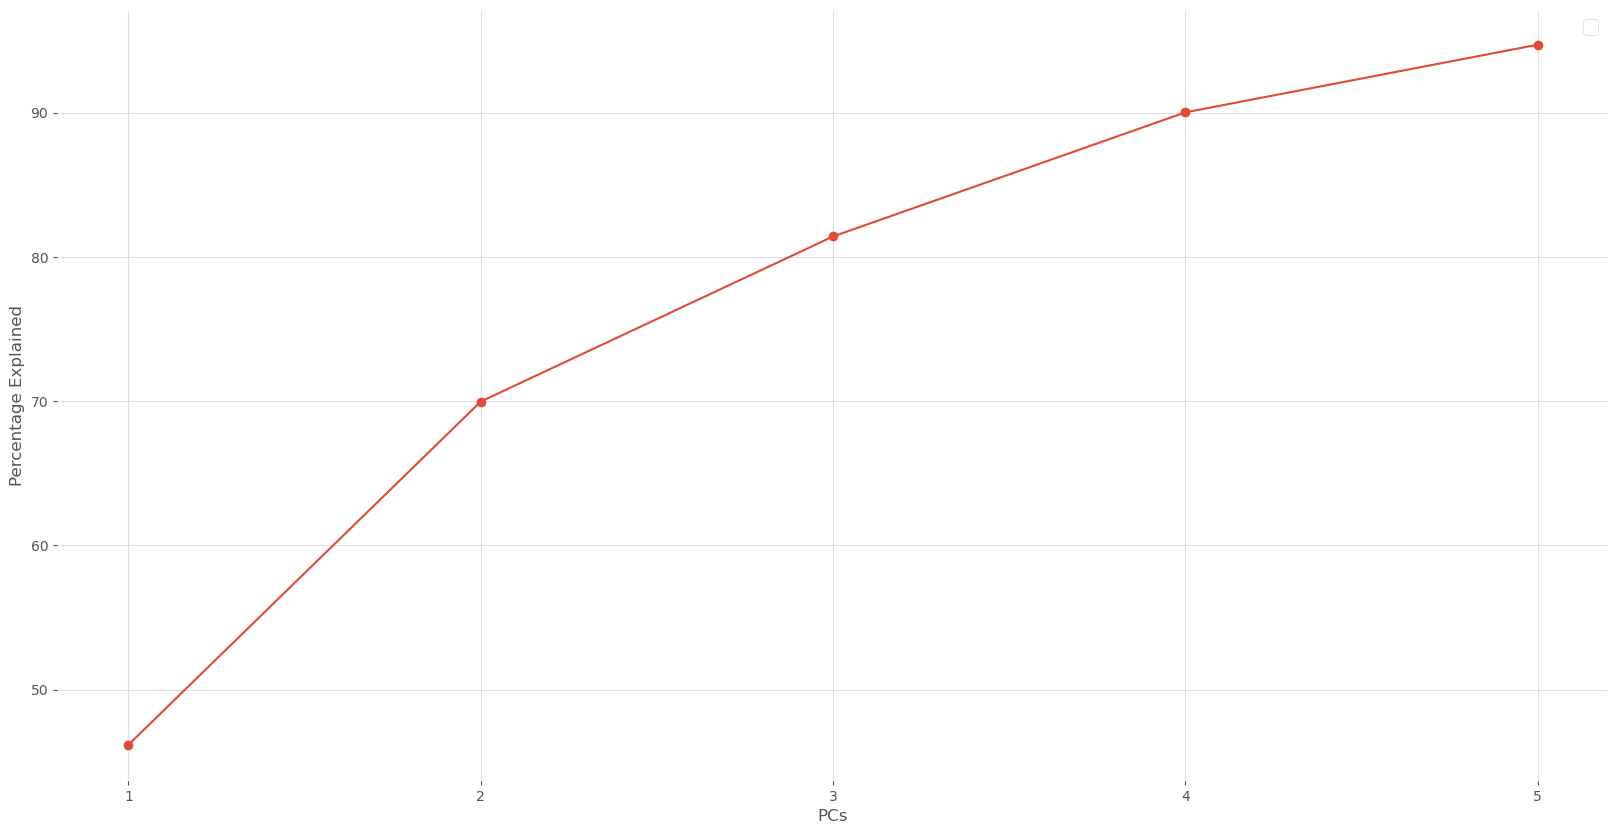

In [99]:
ncomps = 5

svd = TruncatedSVD(n_components=ncomps)

svd_fit = svd.fit(rescaledDataset)

plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)

plt_data.index = np.arange(1, len(plt_data) + 1)

Y_pred = svd.fit_transform(rescaledDataset)

ax = plt_data.plot(kind="line", figsize=(20, 10), style = "o-"
                  )
ax.xaxis.set_major_locator(MaxNLocator(integer = True)
                          )

ax.set_xlabel("PCs")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print("Variance preserved by first 5 components == {:.2%}".format(svd_fit.explained_variance_ratio_.cumsum()[-1]
                                                                 )
     )

In [100]:
dfsvd = pd.DataFrame(Y_pred, columns=["pc{}".format(c) for c in range(ncomps)], 
                     index = rescaledDataset.index)
print(dfsvd.shape)
dfsvd.tail()

(3806, 5)


pc0       pc1       pc2       pc3       pc4
Date                                                        
2021-01-11  5.620401  0.279722  2.338744 -0.673845  0.593072
2021-01-12  5.604192  0.201852  2.331024 -0.186077  0.151467
2021-01-13  5.640768  0.356891  2.348042 -0.139429 -0.099702
2021-01-14  5.511105 -0.481415  2.338198 -0.436787 -0.221950
2021-01-15  5.372413 -1.166909  2.319389 -0.571819 -0.387139

In [101]:
X_train = dfsvd

Variance preserved by first 5 components == 92.26%


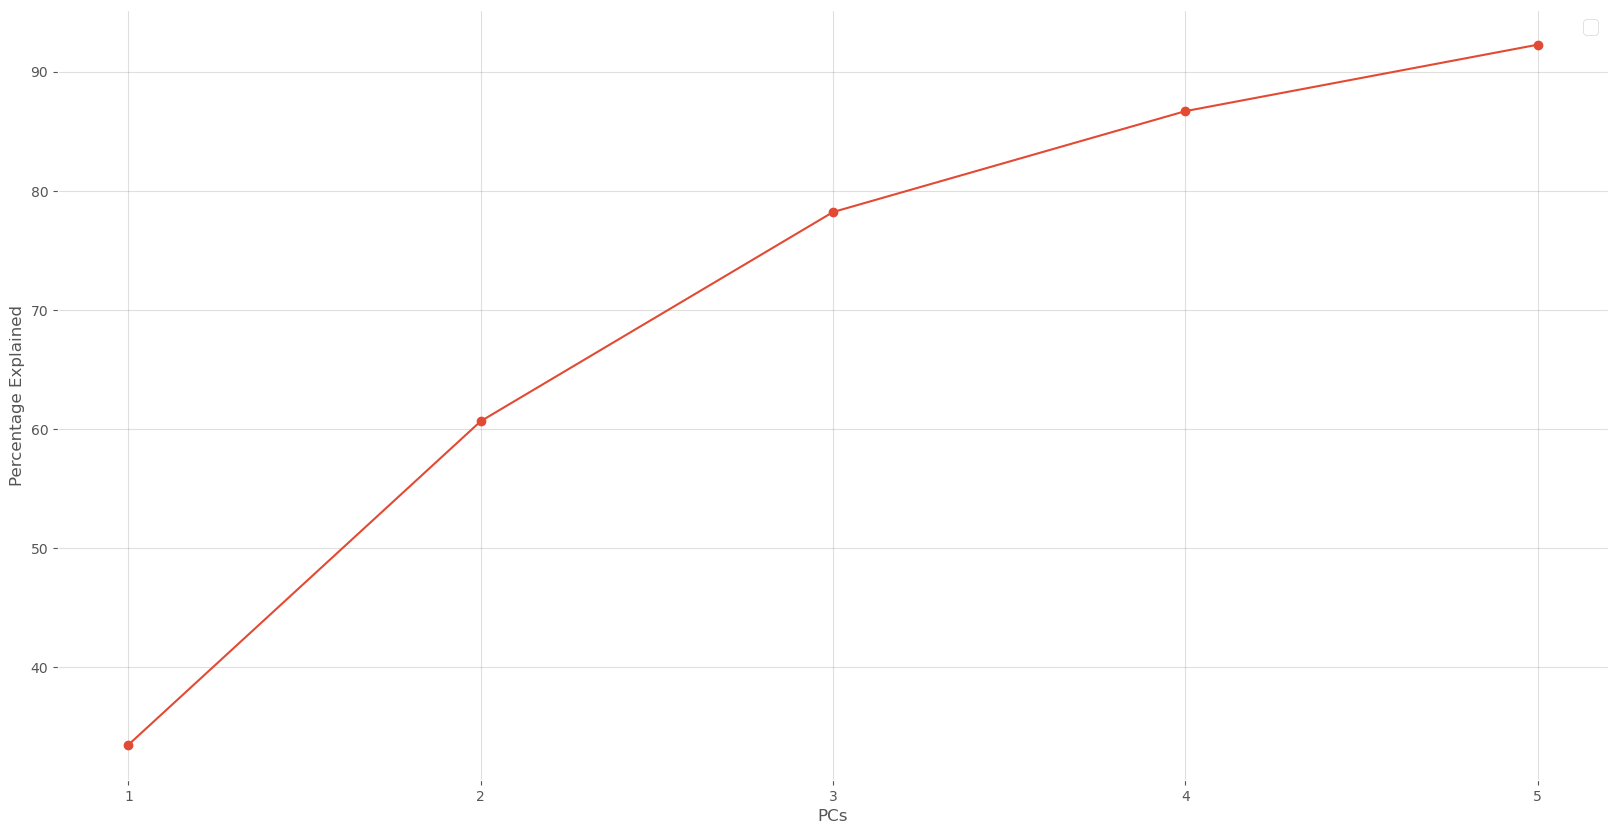

In [102]:
ncomps = 5

svd = TruncatedSVD(n_components=ncomps)

svd_fit2 = svd.fit(rescaledDataset2)

plt_data2 = pd.DataFrame(svd_fit2.explained_variance_ratio_.cumsum()*100)

plt_data2.index = np.arange(1, len(plt_data) + 1)

Y_pred2 = svd.fit_transform(rescaledDataset2)

ax = plt_data2.plot(kind="line", figsize=(20, 10), style = "o-"
                  )
ax.xaxis.set_major_locator(MaxNLocator(integer = True)
                          )

ax.set_xlabel("PCs")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print("Variance preserved by first 5 components == {:.2%}".format(svd_fit2.explained_variance_ratio_.cumsum()[-1]
                                                                 )
     )

In [103]:
dfsvd2 = pd.DataFrame(Y_pred2, columns=["pc{}".format(c) for c in range(ncomps)], 
                     index = rescaledDataset2.index)
print(dfsvd2.shape)
dfsvd2.tail()

(952, 5)


pc0       pc1       pc2       pc3       pc4
Date                                                        
2024-10-23  2.813599  0.687874  2.825608 -0.463024  0.041079
2024-10-24  2.855134  1.109635  2.528912  0.421489 -0.244219
2024-10-25  2.819721  0.873414  2.705238  0.241669 -0.286059
2024-10-28  2.831563  1.019894  2.676005  0.588776 -0.370167
2024-10-29  2.911034  1.288941  2.568865  0.298573 -0.274531

In [104]:
X_test = dfsvd2

In [105]:
#Fit model
models = []

In [106]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )
# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [107]:
num_folds = 10 
seed = 241001
scoring = "neg_mean_squared_error"

In [108]:
names = []
kfold_results = []
train_results = []
test_results = []

In [109]:
name = 'LinearRegression()'
model = LinearRegression()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_LN = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_LN.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_LN.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

LinearRegression()
Mean Cross Validation Score:  0.00015851733347926788
Std Cross Validation Score:  1.8958722774485594e-05
Train MSE: train_result:  0.00015706974444029627
Test MSE: test_result:  0.0001122949444444462


In [110]:
name = 'Lasso()'
model = Lasso()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_LS = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_LS.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_LS.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

Lasso()
Mean Cross Validation Score:  0.00015956980455933563
Std Cross Validation Score:  1.925206512367479e-05
Train MSE: train_result:  0.0001595015233388334
Test MSE: test_result:  0.00010971812179636104


In [111]:
name = 'ElasticNet()'
model = ElasticNet()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_EN = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_EN.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_EN.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

ElasticNet()
Mean Cross Validation Score:  0.00015956980455933563
Std Cross Validation Score:  1.925206512367479e-05
Train MSE: train_result:  0.0001595015233388334
Test MSE: test_result:  0.00010971812179636104


In [112]:
name = 'DecisionTreeRegressor()'
model = DecisionTreeRegressor()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_DTR = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_DTR.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_DTR.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

DecisionTreeRegressor()
Mean Cross Validation Score:  0.00032424600961241165
Std Cross Validation Score:  6.224409953989076e-05
Train MSE: train_result:  0.0
Test MSE: test_result:  0.00039794914323394546


In [113]:
name = 'KNeighborsRegressor()'
model = KNeighborsRegressor()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
   
kfold_results.append(cv_results)
  
res_KNR = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_KNR.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_KNR.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

KNeighborsRegressor()
Mean Cross Validation Score:  0.0001897243424553563
Std Cross Validation Score:  2.2204899135310043e-05
Train MSE: train_result:  0.00012846551755793317
Test MSE: test_result:  0.00013920559260108175


In [114]:
name = 'SVR()'
model = SVR()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_SVR = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_SVR.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_SVR.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

SVR()
Mean Cross Validation Score:  0.00018144160746130444
Std Cross Validation Score:  3.6856842902250704e-05
Train MSE: train_result:  0.000166824877030521
Test MSE: test_result:  0.00012003176444833972


In [115]:
name = 'RandomForestRegressor()'
model = RandomForestRegressor()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_RFR = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_RFR.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_RFR.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

RandomForestRegressor()
Mean Cross Validation Score:  0.00018714643270383854
Std Cross Validation Score:  1.963404598835981e-05
Train MSE: train_result:  2.6124533968108996e-05
Test MSE: test_result:  0.00013377894359785166


In [116]:
name = 'RandomForestRegressor()'
model = RandomForestRegressor()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_ETR = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_ETR.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_ETR.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

RandomForestRegressor()
Mean Cross Validation Score:  0.0001875920527464115
Std Cross Validation Score:  2.23892402797709e-05
Train MSE: train_result:  2.5161169187624087e-05
Test MSE: test_result:  0.00013315475954851796


In [117]:
name = 'RandomForestRegressor()'
model = RandomForestRegressor()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_GBR = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_GBR.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_GBR.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

RandomForestRegressor()
Mean Cross Validation Score:  0.00018628610027975872
Std Cross Validation Score:  2.0517215190174592e-05
Train MSE: train_result:  2.5849049445232325e-05
Test MSE: test_result:  0.0001347608852772899


In [118]:
name = 'RandomForestRegressor()'
model = RandomForestRegressor()
kfold = KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        
names.append(name)
cv_results = -1 * cross_val_score(model, 
                                  X_train, 
                                  Y_train,
                                  cv = kfold,
                                  scoring = scoring)
           
    
kfold_results.append(cv_results)
  
res_ABR = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

train_result = mean_squared_error(res_ABR.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_ABR.predict(X_test), Y_test)
    
test_results.append(test_result)

# message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
#                                      cv_results.std(), 
#                                      train_result, 
#                                      test_result)
print(name)
print('Mean Cross Validation Score: ', cv_results.mean())
print('Std Cross Validation Score: ', cv_results.std())
print('Train MSE: train_result: ', train_result)
print('Test MSE: test_result: ', test_result)

RandomForestRegressor()
Mean Cross Validation Score:  0.00018795206427346724
Std Cross Validation Score:  2.2748475089883747e-05
Train MSE: train_result:  2.5939365031529587e-05
Test MSE: test_result:  0.0001324931304366947


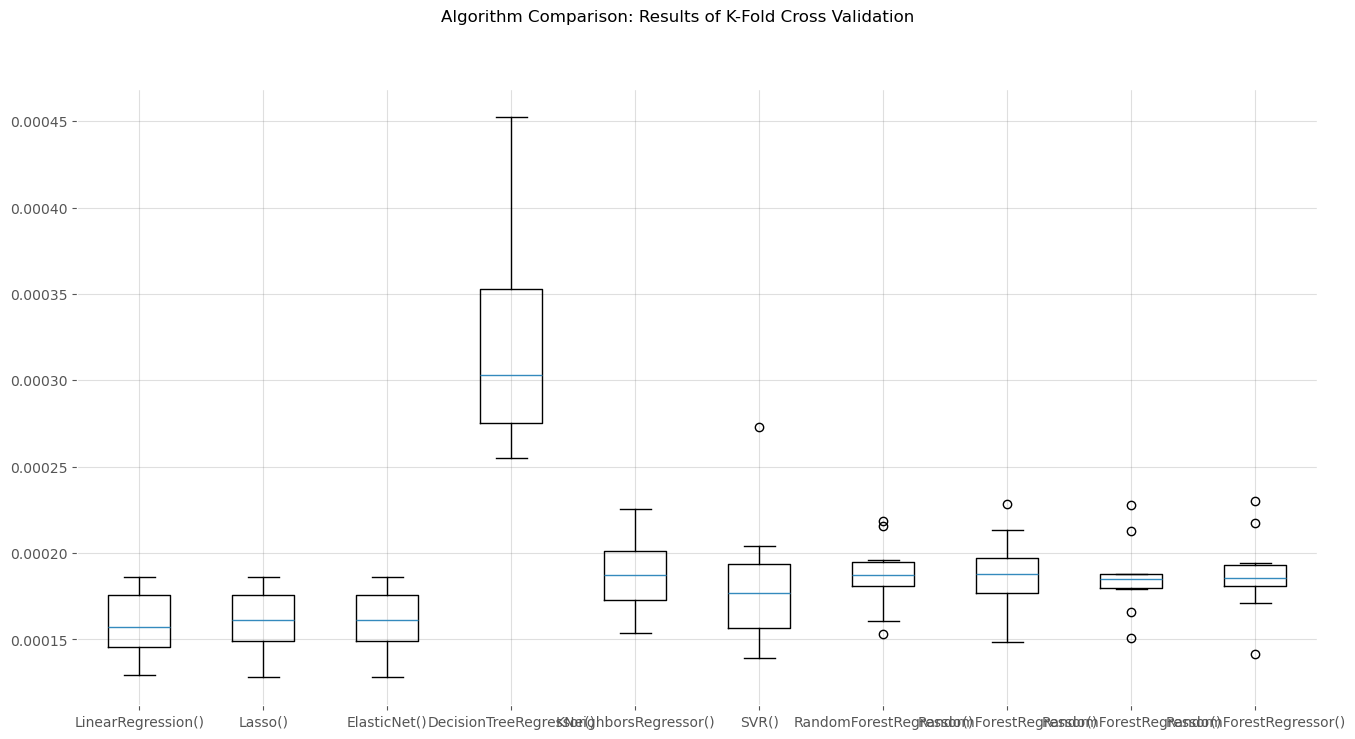

In [119]:
fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)  #from TRAINING result - THAT'S WHY THERE ARE 10

ax.set_xticklabels(names)

plt.show()

In [120]:
X_train_ARIMA = X_train

X_test_ARIMA = X_test

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)

In [121]:
X_train_ARIMA = X_train

X_test_ARIMA = X_test

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)

In [122]:
modelARIMA =\
(    stats
     .ARIMA(endog = Y_train,
                exog = X_train_ARIMA,
                order = [1, 0, 0]
            )
)

model_fit = modelARIMA.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [123]:
error_training_ARIMA =\
(    mean_squared_error(Y_train,
                       model_fit.fittedvalues)
)

predicted =\
(
    model_fit
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1: ]
)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [124]:
error_testing_ARIMA =\
(    mean_squared_error(Y_test,
                        predicted)
)

error_testing_ARIMA

0.00011221333254397177

In [125]:
train_results = [x for x in train_results if x is not None]
train_results

[0.00015706974444029627,
 0.0001595015233388334,
 0.0001595015233388334,
 0.0,
 0.00012846551755793317,
 0.000166824877030521,
 2.6124533968108996e-05,
 2.5161169187624087e-05,
 2.5849049445232325e-05,
 2.5939365031529587e-05]

In [126]:
test_results = [x for x in test_results if x is not None]
test_results

[0.0001122949444444462,
 0.00010971812179636104,
 0.00010971812179636104,
 0.00039794914323394546,
 0.00013920559260108175,
 0.00012003176444833972,
 0.00013377894359785166,
 0.00013315475954851796,
 0.0001347608852772899,
 0.0001324931304366947]

In [127]:
test_results.append(error_testing_ARIMA)

train_results.append(error_training_ARIMA)

names.append("ARIMA")

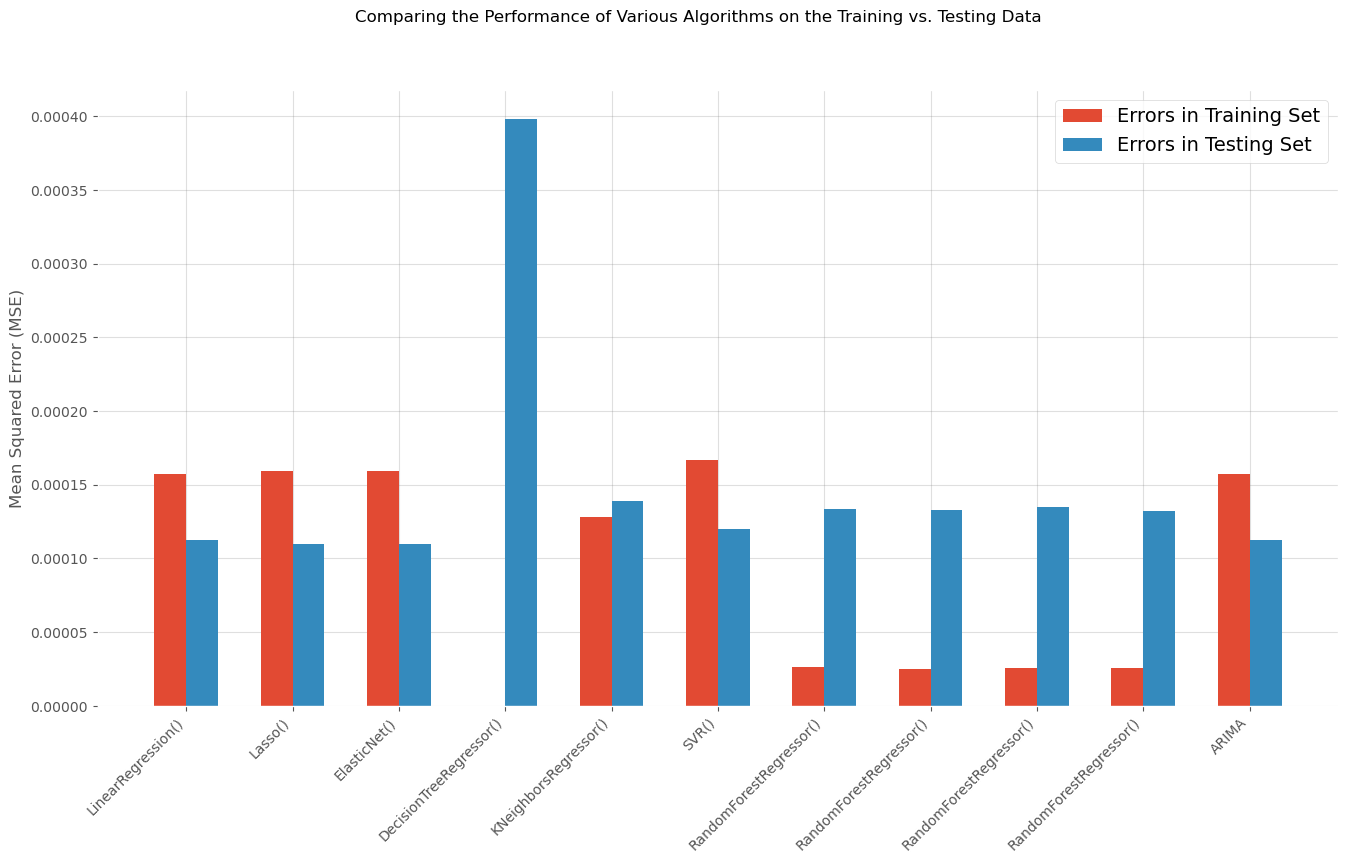

In [128]:
fig = plt.figure(figsize=[16, 8])

ind = np.arange(len(names))
width = 0.30

fig.suptitle("Comparing the Performance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

plt.bar(ind - width/2, train_results, width=width, label="Errors in Training Set")
plt.bar(ind + width/2, test_results, width=width, label="Errors in Testing Set")

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names, rotation=45, ha='right')  # Set rotation to 45 degrees

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

# Overfitting happens when the error in test set > train set
# Underfitting happens when the error in train set > test set
# Best result is when the test set (blue bar) has the smallest error


In [129]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_ARIMA_model(arima_order):
    
    modelARIMA = stats.ARIMA(endog = Y_train, 
                             exog = X_train_ARIMA,
                             order = arima_order)
    # Our model takes an arima_order as input, 
    # fits an ARIMA model to the training data Y_train 
    # with exogenous variables X_train_ARIMA, 
    
    model_fit = modelARIMA.fit()
    # and then calculates 

    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    
    # and returns the Mean Squared Error (MSE) 
    # between the true and the fitted values.

    return error

def assess_models(p_values, d_values, q_values):
    
    # Team, our function performs grid search 
    # over all combinations of provided p, d, and q values. 
    
    # For each combination, it calculates the MSE and prints it. 
    
    # If the MSE for the current combination 
    # is less than the best score encountered so far, 
    # it updates the best score and the corresponding configuration. 
    
    # At the end of the grid search, 
    # it prints the best configuration and its MSE.
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    
                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )
                    
                except:
                    continue
    print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
          )
    
# parameters to use for assessment

# Recall that the ARIMA model 
# is characterized by three parameters: 
# (p, d, q) which stand for the order of autoregression, 
# the degree of differencing, 
# and the order of the moving average, respectively.

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

In [130]:
assess_models(p_values, d_values, q_values)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) MSE = 0.0001571


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anacond

ARIMA(0, 0, 1) MSE = 0.0001571
ARIMA(0, 1, 0) MSE = 0.0002107


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anacond

ARIMA(0, 1, 1) MSE = 0.0001590
ARIMA(1, 0, 0) MSE = 0.0001571


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) MSE = 0.0001571


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0) MSE = 0.0001898


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anacond

ARIMA(1, 1, 1) MSE = 0.0001652
ARIMA(2, 0, 0) MSE = 0.0001570


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) MSE = 0.0001571


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anacond

ARIMA(2, 1, 0) MSE = 0.0001780
ARIMA(2, 1, 1) MSE = 0.0001748
Best ARIMA(2, 0, 0) MSE = 0.0001570


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [131]:
ARIMA_Tuned =\
    stats \
    .ARIMA(endog = Y_train,
           exog = X_train_ARIMA,
          order = [1,0,1] # Team, input optimal set of hyperparameters here
          )

ARIMA_Fit_Tuned = ARIMA_Tuned.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [132]:
Predicted_Tuned =\
    model_fit \
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1:]

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [133]:
test_result_arima = print(mean_squared_error(Y_test,
                         Predicted_Tuned)
     )

train_result_arima = print(mean_squared_error(Y_train,
                         model_fit.fittedvalues))

0.00011221333254397177
0.0001570680293476245


In [134]:
train_results.append(train_result_arima)

In [135]:
test_results.append(test_result_arima)

In [136]:
names = []

In [137]:
for name, model in models:
    names.append(name)

In [138]:
names.append('ARIMA-X')

In [139]:
 
train_results = [x for x in train_results if x is not None]
train_results

[0.00015706974444029627,
 0.0001595015233388334,
 0.0001595015233388334,
 0.0,
 0.00012846551755793317,
 0.000166824877030521,
 2.6124533968108996e-05,
 2.5161169187624087e-05,
 2.5849049445232325e-05,
 2.5939365031529587e-05,
 0.0001570680293476245]

In [140]:
test_results = [x for x in test_results if x is not None]
test_results

[0.0001122949444444462,
 0.00010971812179636104,
 0.00010971812179636104,
 0.00039794914323394546,
 0.00013920559260108175,
 0.00012003176444833972,
 0.00013377894359785166,
 0.00013315475954851796,
 0.0001347608852772899,
 0.0001324931304366947,
 0.00011221333254397177]

In [141]:
result_list = [res_LN, res_LS, res_EN, res_DTR, res_KNR, res_SVR, res_RFR, res_ETR, res_GBR, res_ABR, Predicted_Tuned]

In [142]:
names.append('OLS')

In [143]:
model_OLS = sm.OLS(Y_train, X_train)
res_OLS = model_OLS.fit()
print(res_OLS.summary())

train_result = mean_squared_error(res_OLS.predict(X_train), Y_train)
    
train_results.append(train_result)
    
test_result = mean_squared_error(res_OLS.predict(X_test), Y_test)
    
test_results.append(test_result)

                                 OLS Regression Results                                
Dep. Variable:                    SPY   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              11.76
Date:                Sat, 23 Nov 2024   Prob (F-statistic):                    2.64e-11
Time:                        05:12:03   Log-Likelihood:                          11266.
No. Observations:                3806   AIC:                                 -2.252e+04
Df Residuals:                    3801   BIC:                                 -2.249e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [144]:
df_result = pd.DataFrame()

df_result['models'] = names
df_result['train_MSE'] = train_results
df_result['test_MSE'] = test_results
df_result['RMSE'] = np.sqrt(np.array(test_results))
# df_result['result_list'] = result_list

df_result.sort_values(by='test_MSE')

models  train_MSE  test_MSE      RMSE
1     LASSO   0.000160  0.000110  0.010475
2        EN   0.000160  0.000110  0.010475
10  ARIMA-X   0.000157  0.000112  0.010593
0        LR   0.000157  0.000112  0.010597
11      OLS   0.000157  0.000113  0.010608
5       SVR   0.000167  0.000120  0.010956
9       ABR   0.000026  0.000132  0.011511
7       ETR   0.000025  0.000133  0.011539
6       RFR   0.000026  0.000134  0.011566
8       GBR   0.000026  0.000135  0.011609
4       KNN   0.000128  0.000139  0.011799
3      CART   0.000000  0.000398  0.019949

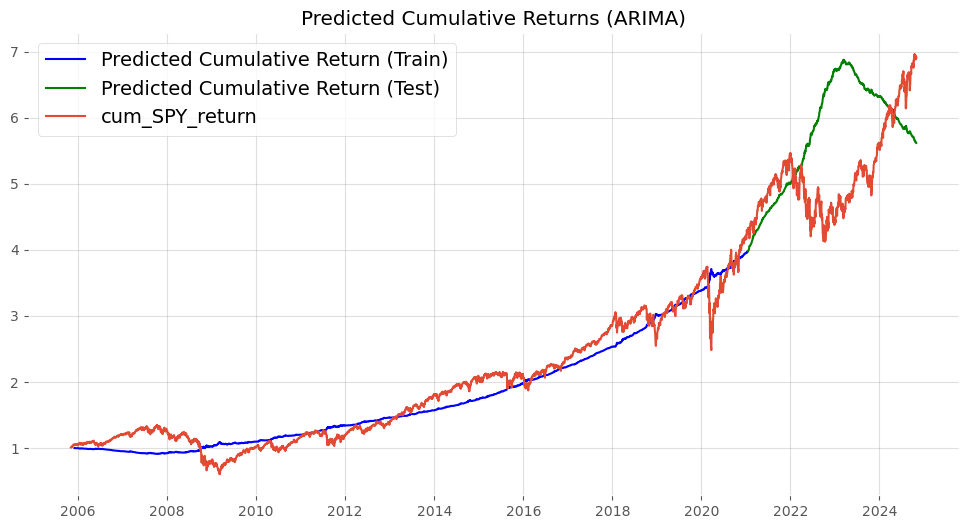

(Date
 2005-12-02   -0.000183
 2005-12-05   -0.000058
 2005-12-06   -0.000404
 2005-12-07    0.000110
 2005-12-08    0.000216
                 ...   
 2021-01-11    1.376624
 2021-01-12    1.377198
 2021-01-13    1.377550
 2021-01-14    1.378810
 2021-01-15    1.380667
 Length: 3806, dtype: float64,
 3806    0.001013
 3807    0.001286
 3808    0.003119
 3809    0.005431
 3810    0.006677
           ...   
 4753    0.349037
 4754    0.348063
 4755    0.347446
 4756    0.346295
 4757    0.345342
 Name: predicted_mean, Length: 952, dtype: float64)

In [145]:
# Predict cumulative return using the fitted ARIMA model
predicted_cum_return_train = model_fit.fittedvalues
predicted_cum_return_test = Predicted_Tuned

# Convert predictions to cumulative returns (if they're not already cumulative)
predicted_cum_return_train = np.cumsum(predicted_cum_return_train)
predicted_cum_return_test = np.cumsum(predicted_cum_return_test)

# Plot the predicted cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(np.exp(predicted_cum_return_train), label='Predicted Cumulative Return (Train)', color='blue')
plt.plot(Y_test.index, np.exp(predicted_cum_return_test+predicted_cum_return_train[-1]), label='Predicted Cumulative Return (Test)', color='green')
plt.plot(df['cum_SPY_return'], label ='cum_SPY_return')
plt.legend()
plt.title("Predicted Cumulative Returns (ARIMA)")
plt.show()

# Optionally return these values for further analysis
predicted_cum_return_train, predicted_cum_return_test


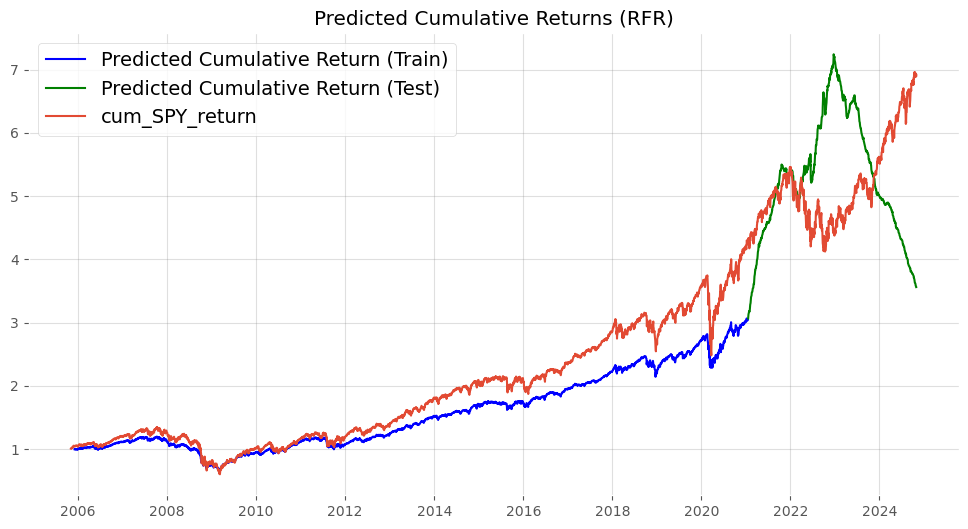

(array([-4.922e-04,  8.736e-04, -2.544e-03, ...,  1.115e+00,  1.110e+00,
         1.113e+00]),
 array([0.008, 0.016, 0.023, 0.029, 0.037, 0.043, 0.045, 0.042, 0.041,
        0.046, 0.053, 0.06 , 0.068, 0.076, 0.084, 0.092, 0.1  , 0.107,
        0.112, 0.119, 0.127, 0.132, 0.134, 0.136, 0.139, 0.145, 0.15 ,
        0.151, 0.153, 0.154, 0.161, 0.163, 0.171, 0.17 , 0.18 , 0.188,
        0.196, 0.204, 0.213, 0.22 , 0.227, 0.23 , 0.23 , 0.237, 0.24 ,
        0.239, 0.241, 0.249, 0.251, 0.254, 0.262, 0.269, 0.277, 0.282,
        0.288, 0.296, 0.302, 0.308, 0.314, 0.321, 0.327, 0.332, 0.327,
        0.323, 0.329, 0.336, 0.34 , 0.337, 0.337, 0.337, 0.34 , 0.346,
        0.346, 0.351, 0.355, 0.355, 0.351, 0.353, 0.356, 0.357, 0.361,
        0.364, 0.367, 0.372, 0.372, 0.376, 0.379, 0.38 , 0.38 , 0.379,
        0.381, 0.383, 0.385, 0.386, 0.389, 0.387, 0.387, 0.389, 0.391,
        0.391, 0.392, 0.392, 0.395, 0.4  , 0.403, 0.401, 0.408, 0.41 ,
        0.409, 0.41 , 0.411, 0.409, 0.412, 0.41 , 0.4

In [146]:
# Predict cumulative return using the fitted RFR model
predicted_cum_return_train = res_RFR.predict(X_train)
predicted_cum_return_test = res_RFR.predict(X_test)

# Convert predictions to cumulative returns (if they're not already cumulative)
predicted_cum_return_train = np.cumsum(predicted_cum_return_train)
predicted_cum_return_test = np.cumsum(predicted_cum_return_test)

# Plot the predicted cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(Y_train.index, np.exp(predicted_cum_return_train), label='Predicted Cumulative Return (Train)', color='blue')
plt.plot(Y_test.index, np.exp(predicted_cum_return_test + predicted_cum_return_train[-1]), label='Predicted Cumulative Return (Test)', color='green')
plt.plot(df['cum_SPY_return'], label ='cum_SPY_return')
plt.legend()
plt.title("Predicted Cumulative Returns (RFR)")
plt.show()

# Optionally return these values for further analysis
predicted_cum_return_train, predicted_cum_return_test


## 1.2. Strategies by Tan Wei Hao:

In [148]:
# Load the libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt

In [149]:
# Start date of Data: 01-November-2005
start =\
(
    dt
    .datetime(2005,
              11,
              1)
)

# End date of Data: 31-October-2024
end =\
(
    dt
    .datetime(2024,
              10,
              31)
)

# Downloading Data from Yahoo Finance
data =\
(
    yf
    .download("^GSPC",
              start,
              end)
)

[*********************100%%**********************]  1 of 1 completed


In [150]:
# DataFrame for S&P500 Adjusted Close Prices
df =\
(
    data
    [["Adj Close"]]
).rename(columns = {"Adj Close": "SP"}
        )

# Backtest Strategies on 80% of the Data
train_size = 0.8

# Training DataFrame containing the first 80%
df_train =\
(
    df
    [ : int(len(data) * 0.8)]
)

# Testing DataFrame containing the last 20%
df_test =\
(
    df
    [int(len(data) * 0.8) : ]
)

### 1.2.1. Trading Strategy 1 by Tan Wei Hao:
> Buy Signal: Short-term Moving Average cross `above` the Long-term Moving Average
> 
> Short Signal: Short-term Moving Average cross `below` the Long-term Moving Average
>
> Hyperparameter tuning for `MAXIMUM CUMMULATIVE RETURNS`:
> 1. Short-term time frame
> 2. Long-term time frame
> 3. Reversed signals for contra-trading

In [152]:
def ma(df, 
       short_period, 
       long_period, 
       reverse_position = False ,
       graph = False, 
       metrics = False):

    # Short-term Moving Average
    df["short"] =\
    (
        df["SP"]
        .rolling(short_period, 
                 min_periods = short_period)
        .mean()
    )

    # Long-term Moving Average
    df["long"] =\
    (
        df["SP"]
        .rolling(long_period, 
                 min_periods = long_period)
        .mean()
    )

    # Crossover
    df["diff"] =\
    (
        df["short"]
        -
        df["long"]
    )
    
    # Position Cross Identification
    df["position_cross"] =\
    (
        np
        .sign(df["diff"] * df["diff"].shift(1)
             ) == -1
    )

    # Position Direction
    df["position_direction"] =\
    (
        np
        .sign(df["long"]
              .diff()
             )
    )

    # Bullish Indicator
    bullish =\
    (
        (df["position_direction"] > 0) 
        &
        df["position_cross"]
    )

    # Bearish Indicator
    bearish =\
    (
        (df["position_direction"] < 0) 
        & 
        df["position_cross"]
    )

    # Positions
    df["position"] =\
    (
        np
        .where(bullish, 1,
               np.where(bearish, 
                        -1, np.nan)
              )
    )

    # Starting Position = 0
    df.iloc[0].loc["position"] = 0

    # Forward Fill for all positions
    df["position"] =\
    (
        df["position"]
        .ffill()
    )

    # Shift the positions to T+1
    df["position t+1"] =\
    (
        df
        ["position"]
        .shift(1)
    )

    # Calculate Log Returns
    df["log_return"] =\
    (
        np
        .log(df["SP"]
             /
             df["SP"].shift(1)
            )
    )

    # Calculate strategy returns with reversed positions if True.
    # Buy Signals = Short, Sell Signals = Long
    if reverse_position == True:
        df["strategy"] =\
        (
            df["log_return"]
            *
            -df["position t+1"]
        )
    else:
        df["strategy"] =\
        (
            df["log_return"]
            *
            df["position t+1"]
        )
        
    # Total Return Index (Cumulative Returns)
    df["tri"] =\
    (
        df["strategy"]
        .cumsum()
        .apply(np.exp)
    )

    # Total Returns at 31-October-2024
    total_returns = df["tri"][-1]

    # Plot the graph between market returns and strategy
    if graph == True:
        plt.plot(df["tri"])
        plt.plot(df["log_return"].cumsum().apply(np.exp))
        plt.legend(["Strategy Returns", "S&P 500 Returns"])

    if metrics == True:
        days =\
        (
            (df.index[-1] - df.index[0])
            .days
        )
        cagr =\
        (
            (total_returns
            **
            (1 / (days/365))
            ) - 1
        )
        print(f"CAGR: {cagr:.2%}")
        
        sharpe =\
        (
            df["strategy"].mean()
            /
            df["strategy"].std()
        )
        print(f"Sharpe: {sharpe:.2%}")
        
        dd =\
        (
            (df["tri"]
            /
            df["tri"].cummax()
            ) -1
        ).min()
        print(f"Drawdown: {dd:.2%}")
    return total_returns

In [153]:
def all_returns_ma(df, short_values, long_values):
    # Best Returns, Best Configurations Placeholder
    best_returns, best_cfg = float(1.0) , None
    
    # Worst Returns, Worst Configurations Placeholder
    worst_returns, worst_cfg = float(1.0), None

    # Try every combination
    for short in short_values:
        for long in long_values:
            try:
                order = (short, long)
                ret = ma(df, short, long)
                if ret > best_returns:
                    best_returns, best_cfg = ret, order
                elif ret < worst_returns:
                        worst_returns, worst_cfg = ret, order
            except:
                continue

    print((best_cfg, best_returns), (worst_cfg, worst_returns)
          )

In [154]:
# Hyperparameter Tuning
short_values = range(0, 61)
long_values = range(0, 121)

all_returns_ma(df_train, short_values, long_values)

((6, 75), 5.782466530479948) ((2, 1), 0.09548429109134028)


> From the Hyperparameter Tuning, we observe that
> - the best portfolio is: short period = 6, long period = 75, returns = 5.78
> - the worst portfolio is: short period = 2, long period = 1, returns = 0.095
> 
> Intuitively, if we reversed every single position for the worst portfolio, we would achieve positive returns.

In [156]:
# BEST MA PORTFOLIO

CAGR: 11.99%
Sharpe: 3.72%
Drawdown: -37.52%


8.600422378734113

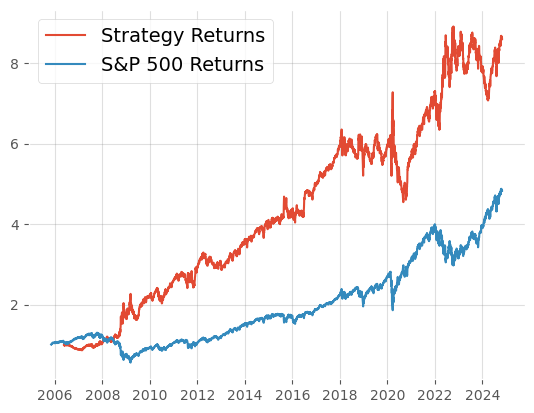

In [157]:
ma(df, 6, 75, 
   reverse_position = False, 
   graph = True,
   metrics = True)

In [158]:
# WORST MA PORTFOLIO (REVERSED)

CAGR: 14.41%
Sharpe: 4.35%
Drawdown: -31.35%


12.916418240831572

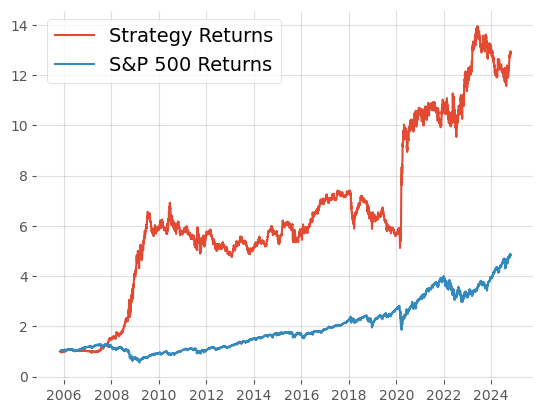

In [159]:
ma(df, 2, 1, 
   reverse_position = True, 
   graph = True,  
   metrics = True)

### 1.2.2. Trading Strategy 2 by Tan Wei Hao
> Buy Signal: Short-term Exponential Moving Average cross `above` the Long-term Exponential Moving Average
> 
> Short Signal: Short-term Exponential Moving Average cross `below` the Long-term Exponential Moving Average
>
> Hyperparameter tuning for `MAXIMUM CUMMULATIVE RETURNS`:
> 1. Short-term time frame
> 2. Long-term time frame
> 3. Reversed signals for contra-trading

In [161]:
def ema(df, 
       short_period, 
       long_period, 
       reverse_position = False ,
       graph = False, 
       metrics = False):

    # Short-term Moving Average
    df["short"] =\
    (
        df["SP"]
        .ewm(short_period, 
                 min_periods = short_period)
        .mean()
    )

    # Long-term Moving Average
    df["long"] =\
    (
        df["SP"]
        .ewm(long_period, 
                 min_periods = long_period)
        .mean()
    )

    # Crossover
    df["diff"] =\
    (
        df["short"]
        -
        df["long"]
    )
    
    # Position Cross Identification
    df["position_cross"] =\
    (
        np
        .sign(df["diff"] * df["diff"].shift(1)
             ) == -1
    )

    # Position Direction
    df["position_direction"] =\
    (
        np
        .sign(df["long"]
              .diff()
             )
    )

    # Bullish Indicator
    bullish =\
    (
        (df["position_direction"] > 0) 
        &
        df["position_cross"]
    )

    # Bearish Indicator
    bearish =\
    (
        (df["position_direction"] < 0) 
        & 
        df["position_cross"]
    )

    # Positions
    df["position"] =\
    (
        np
        .where(bullish, 1,
               np.where(bearish, 
                        -1, np.nan)
              )
    )

    # Starting Position = 0
    df.iloc[0].loc["position"] = 0

    # Forward Fill for all positions
    df["position"] =\
    (
        df["position"]
        .ffill()
    )

    # Shift the positions to T+1
    df["position t+1"] =\
    (
        df
        ["position"]
        .shift(1)
    )

    # Calculate Log Returns
    df["log_return"] =\
    (
        np
        .log(df["SP"]
             /
             df["SP"].shift(1)
            )
    )

    # Calculate strategy returns with reversed positions if True.
    # Buy Signals = Short, Sell Signals = Long
    if reverse_position == True:
        df["strategy"] =\
        (
            df["log_return"]
            *
            -df["position t+1"]
        )
    else:
        df["strategy"] =\
        (
            df["log_return"]
            *
            df["position t+1"]
        )
        
    # Total Return Index (Cumulative Returns)
    df["tri"] =\
    (
        df["strategy"]
        .cumsum()
        .apply(np.exp)
    )

    # Total Returns at 31-October-2024
    total_returns = df["tri"][-1]

    # Plot the graph between market returns and strategy
    if graph == True:
        plt.plot(df["tri"])
        plt.plot(df["log_return"].cumsum().apply(np.exp))
        plt.legend(["Strategy Returns", "S&P 500 Returns"])

    if metrics == True:
        days =\
        (
            (df.index[-1] - df.index[0])
            .days
        )
        cagr =\
        (
            (total_returns
            **
            (1 / (days/365))
            ) - 1
        )
        print(f"CAGR: {cagr:.2%}")
        
        sharpe =\
        (
            df["strategy"].mean()
            /
            df["strategy"].std()
        )
        print(f"Sharpe: {sharpe:.2%}")

        dd =\
        (
            (df["tri"]
            /
            df["tri"].cummax()
            ) -1
        ).min()
        print(f"Drawdown: {dd:.2%}")
        
    return total_returns

In [162]:
def all_returns_ema(df, short_values, long_values):
    # Best Returns, Best Configurations Placeholder
    best_returns, best_cfg = float(1.0) , None
    
    # Worst Returns, Worst Configurations Placeholder
    worst_returns, worst_cfg = float(1.0), None

    # Try every combination
    for short in short_values:
        for long in long_values:
            try:
                order = (short, long)
                ret = ema(df, short, long)
                if ret > best_returns:
                    best_returns, best_cfg = ret, order
                elif ret < worst_returns:
                        worst_returns, worst_cfg = ret, order
            except:
                continue

    print((best_cfg, best_returns), (worst_cfg, worst_returns)
          )

In [163]:
# Hyperparameter Tuning
short_values = range(0, 61)
long_values = range(0, 121)

all_returns_ema(df_train, short_values, long_values)

((11, 27), 3.4453234290638846) ((0, 2), 0.21019209914024253)


> From the Hyperparameter Tuning, we observe that
> - the best portfolio is: short period = 11, long period = 27, returns = 3.44
> - the worst portfolio is: short period = 0, long period = 2, returns = 0.21
> 
> Intuitively, if we reversed every single position for the worst portfolio, we would achieve positive returns.

In [165]:
#Best EMA Portfolio

CAGR: 7.20%
Sharpe: 2.28%
Drawdown: -33.00%


3.7466671597713277

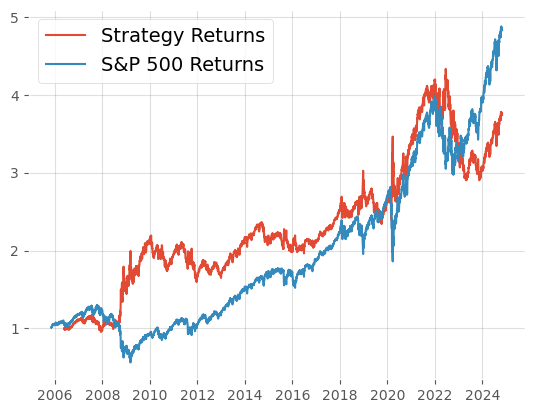

In [166]:
ema(df, 11, 27, 
   reverse_position = False, 
   graph = True,
   metrics = True)

In [167]:
#Worst EMA Portfolio (Reversed)

CAGR: 11.24%
Sharpe: 3.44%
Drawdown: -42.96%


7.570974591294655

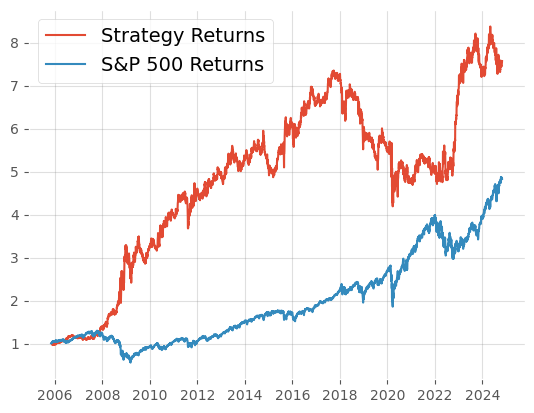

In [168]:
ema(df, 0, 2, 
   reverse_position = True, 
   graph = True,
   metrics = True)

### 1.2.3. Trading Strategy 3 (by Tan Wei Hao)
> Buy Signal: MACD cross `above` the MACD Signal Line
> 
> Short Signal: MACD cross `below` the MACD Signal Line
>
> Hyperparameter tuning for `MAXIMUM CUMMULATIVE RETURNS`:
> 1. Short-term time frame
> 2. Long-term time frame
> 3. Signal time frame
> 4. Possible reversed signals for contra-trading

In [170]:
def macd(df, 
         short_period, 
         long_period, 
         signal_period, 
         graph = False, 
         metrics = False):
    
    df["short"] =\
    (
        df["SP"]
        .ewm(span = short_period, 
             min_periods = short_period)
        .mean()
    )
    
    df["long"] =\
    (
        df["SP"]
        .ewm(span = long_period, 
             min_periods = long_period)
        .mean()
    )
    
    df["macd"] =\
    (
        df["short"] - df["long"]
    )
    
    df["macd_signal"] =\
    (
        df
        ["macd"]
        .ewm(span = signal_period)
        .mean()
    )
    
    df["diff"] =\
    (
        df["macd"]
        -
        df["macd_signal"]
    )
    
    # Position Cross Identification
    
    df["position_cross"] =\
    (
        np
        .sign(df["diff"] * df["diff"].shift(1)
             ) == -1
    )
    
    df["position_macd_direction"] =\
    (
        np
        .sign(df["macd"]
              .diff()
             )
    )
    
    bullish = (df["position_macd_direction"] > 0) & df["position_cross"]
    
    bearish = (df["position_macd_direction"] < 0) & df["position_cross"]
    
    df["position"] =\
    (
        np
        .where(bullish, 1,
               np.where(bearish, 
                        -1, np.nan)
              )
    )
    
    df.iloc[0].loc["position"] = 0
    
    df["position"] =\
    (
        df["position"]
        .ffill()
    )
    
    df["position t+1"] =\
    (
        df
        ["position"]
        .shift(1)
    )
    
    df["base_log_return"] =\
    (
        np
        .log(df["SP"]
             /
             df["SP"].shift(1)
            )
    )
    
    df["strategy"] =\
    (
        df["base_log_return"]
        *
        df["position t+1"]
    )
    
    df["tri"] =\
    (
        df["strategy"]
        .cumsum()
        .apply(np.exp)
    )
    
    total_returns = df["tri"][-1]

    if graph == True:
        plt.plot(df["tri"])
        plt.plot(df["base_log_return"].cumsum().apply(np.exp))
        plt.legend(["strat", "market"])

    if metrics == True:
        days =\
        (
            (df.index[-1] - df.index[0])
            .days
        )
        cagr =\
        (
            (total_returns
            **
            (1 / (days/365))
            ) - 1
        )
        print(f"CAGR: {cagr:.2%}")
        
        sharpe =\
        (
            df["strategy"].mean()
            /
            df["strategy"].std()
        )
        print(f"Sharpe: {sharpe:.2%}")

        dd =\
        (
            (df["tri"]
            /
            df["tri"].cummax()
            ) -1
        ).min()
        print(f"Drawdown: {dd:.2%}")
        
    return total_returns

In [171]:
def all_returns_macd(df, short_values, long_values, signal_values):
    best_returns, best_cfg = float(1.0) , None
    worst_returns, worst_cfg = float(1.0), None
    for short in short_values:
        for long in long_values:
            for signal in signal_values:
                try:
                    order = (short, long, signal)
                    ret = macd(df, short, long, signal)
                    if ret > best_returns:
                        best_returns, best_cfg = ret, order
                    elif ret < worst_returns:
                        worst_returns, worst_cfg = ret, order
                except:
                    continue

    print((best_cfg, best_returns), (worst_cfg, worst_returns)
          )

In [172]:
short_values = range(0, 32)
long_values = range(0, 32)
signal_values = range(0, 8)

all_returns_macd(df_train, short_values, long_values, signal_values)

((31, 1, 4), 18.183325205994507) ((1, 31, 4), 0.054995441629693206)


> From the Hyperparameter Tuning, we observe that
> - the best portfolio is: short period = 31, long period = 1, signal period = 4, returns = 18.18
> - the worst portfolio is: short period = 1, long period = 31, signal period = 4, returns = 0.055
> 
> Intuitively, it seems that the best portfolio and the worst portfolio are the inverse of each other.

In [174]:
#Best MACD Portfolio

CAGR: 17.29%
Sharpe: 5.18%
Drawdown: -24.61%


20.7265779279449

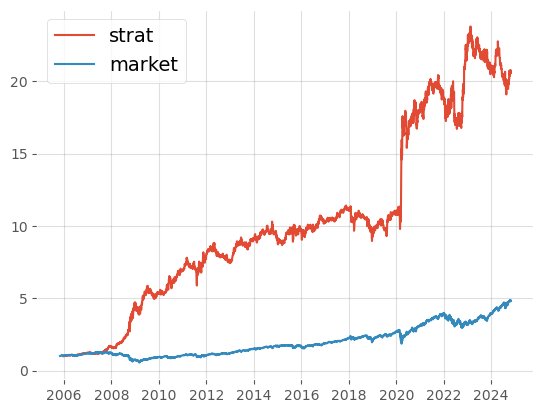

In [175]:
macd(df, 31, 1, 4, 
     graph = True,
     metrics = True)

### 1.2.4. Trading Strategy 4 (by Tan Wei Hao)
> Buy Signal: RSI cross `above` the High threshold
>
> Unwind (Neutral) Signal: RSI crosses the Middle threshold defined by (High + Low) / 2 for simplicity
> 
> Short Signal: RSI cross `below` the Low threshold
>
> Hyperparameter tuning for `MAXIMUM CUMMULATIVE RETURNS`:
> 1. Short-term time frame
> 2. Long-term time frame
> 3. Initial rolling time frame
> 4. Possible reversed signals for contra-trading

In [177]:
def rsi_returns(df, init, low, high, graph = False, metrics = False):
    df["price_change"] = df["SP"].diff()
    
    df["gain"], df["loss"] = df["price_change"].clip(lower = 0), df["price_change"].clip(upper = 0).abs()
    
    df["gain_roll"], df["loss_roll"] = df["gain"].rolling(init).mean(), df["loss"].rolling(init).mean()
    
    df["rs"] = df["gain_roll"] / df["loss_roll"]
    
    df["rsi"] = 100 - 100 / (1 + df["rs"])
    
    df["rsi_up"], df["rsi_down"] = df["rsi"].diff() > 0, df["rsi"].diff() < 0
    
    mid = (high + low)/ 2
    
    df["crossed_high"] = (np.sign((df["rsi"] - high) * (df["rsi"] - high).shift(1)).fillna(1) == -1)
    
    df["crossed_mid"] = (np.sign((df["rsi"] - mid) * (df["rsi"] - mid).shift(1)).fillna(1) == - 1)
    
    df["crossed_low"] = (np.sign((df["rsi"] - low) * (df["rsi"] - low).shift(1)).fillna(1) == -1)
    
    df["positions"] =\
    (
         np.where(df["rsi_up"] & df["crossed_low"], 1,
                  np.where(df["crossed_mid"], 0,
                           np.where(df["rsi_down"] & df["crossed_high"], -1,
                                    np.nan)
                          )
                 )
    )
    
    df["positions"] =\
    (
         np.where(df["rsi_up"] & df["crossed_low"], 1,
                  np.where(df["rsi_down"] & df["crossed_high"], -1,np.nan)
                 )
    )
    
    df["positions"] = df["positions"].ffill()
    
    df["log_return"] = np.log(df["SP"]/df["SP"].shift(1))
    
    df["strategy"] = df["positions"].shift(1) * df["log_return"]
    
    df["tri"] = df["strategy"].cumsum().apply(np.exp)
    total_returns = df["tri"].iloc[-1]
    
    if graph == True:
        plt.plot(df["tri"])
        plt.plot(df["log_return"].cumsum().apply(np.exp))
        plt.legend(["strategy", "SP"])

    if metrics == True:
        days =\
        (
            (df.index[-1] - df.index[0])
            .days
        )
        cagr =\
        (
            (total_returns
            **
            (1 / (days/365))
            ) - 1
        )
        print(f"CAGR: {cagr:.2%}")
        
        sharpe =\
        (
            df["strategy"].mean()
            /
            df["strategy"].std()
        )
        print(f"Sharpe: {sharpe:.2%}")

        dd =\
        (
            (df["tri"]
            /
            df["tri"].cummax()
            ) -1
        ).min()
        print(f"Drawdown: {dd:.2%}")
        
    return total_returns

In [178]:
def all_returns_rsi(df, init_values, low_values, high_values):
    best_returns, best_cfg = float(1.0) , None
    worst_returns, worst_cfg = float(1.0), None
    for init in init_values:
        for low in low_values:
            for high in high_values:
                try:
                    order = (init, low, high)
                    ret = rsi_returns(df, init, low, high)
                    if ret > best_returns:
                        best_returns, best_cfg = ret, order
                    elif ret < worst_returns:
                        worst_returns, worst_cfg = ret, order
                except:
                        continue
    print((best_cfg, best_returns), (worst_cfg, worst_returns)
          )

In [179]:
init_values = range(0, 15)
low_values = range(40, 50)
high_values = range(80, 91)

all_returns_rsi(df_train, init_values, low_values, high_values)

((13, 45, 90), 3.776341543424135) ((1, 40, 80), 0.09548429109134028)


> From the Hyperparameter Tuning, we observe that
> - the best portfolio is: rolling period = 13, lower bound = 45, upper bound = 90, returns = 3.776
> - the worst portfolio is: rolling period = 1, lower bound = 40, upper bound = 60, returns = 0.095
> 
> Intuitively, it seems that the worst portfolio is just whether yesterday's price was up / down. The returns can be replicated with SMA(1,2).

In [181]:
# Best RSI Portfolio

CAGR: 8.69%
Sharpe: 2.70%
Drawdown: -56.78%


4.8735266993006645

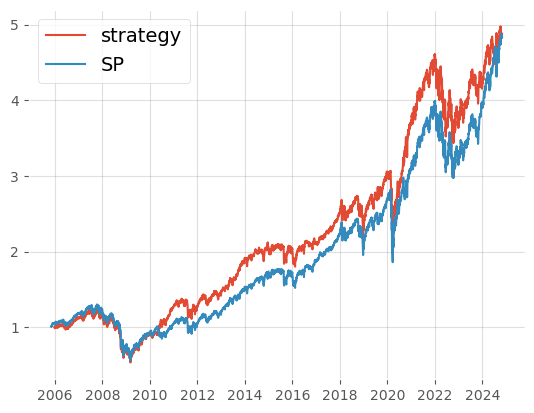

In [182]:
rsi_returns(df, 13, 45, 90, graph = True, metrics = True)

## 1.3. Strategies by Lim Fang Yi:

In [184]:
# !pip install mplfinance
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import mplfinance as mpf
import matplotlib.dates as dates
import seaborn as sns

### 1.3.1. Trading Strategy 1 (by Lim Fang Yi)
> Indicator used: `MFI`
> 
> Short Signal: MFI > `MFI_high` threshold suggests the asset is overbought, signaling a potential sell opportunity.
> 
> Buy Signal:  MFI < `MFI_low` threshold suggests the asset is underbought, signaling a potential buy opportunity.
>
> Hyperparameter tuning for `cumulative returns`:
> 1. Higher Threshold for `MFI_high`
> 2. Lower Threshold for `MFI_lower`
> 3. `window` Window to calculate moving average used in MFI computation

In [186]:
# Calculate money flow index
def mfi(high, low, close, volume, window=14):
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign

    # Calculate gain and loss using vectorized operations
    positive_mf = np.where(signed_mf > 0, signed_mf, 0)
    negative_mf = np.where(signed_mf < 0, -signed_mf, 0)

    mf_avg_gain = pd.Series(positive_mf).rolling(window, min_periods=1).sum()
    mf_avg_loss = pd.Series(negative_mf).rolling(window, min_periods=1).sum()

    return (100 - 100 / (1 + mf_avg_gain / mf_avg_loss)).to_numpy()

# Create indicators
def create_indicators(window, stock_df):
    stock_df['MFI'] = mfi(stock_df['High'], stock_df['Low'], stock_df['Close'], stock_df['Volume'], window)
    return stock_df

# Create signals and positions
def create_positions(stock_df, MFI_low, MFI_high):
    
# Define signals
# Buy signal if MFI_t < 20 & MFI_t-1 > = 20
# Sell signal if MFI_t > 20 & MFI_t-1 <= 80
    stock_df['Signal'] = np.where(
    (stock_df['MFI'] < MFI_low) & (stock_df['MFI'].shift(1) >= MFI_high), 
    1,  # Buy signal
    np.where(
        (stock_df['MFI'] > MFI_high) & (stock_df['MFI'].shift(1) <= MFI_high), 
        -1,  # Sell signal
        0    # No signal
    )
)
# Create Position
    stock_df['Position'] = np.nan
    stock_df['Position'] = np.where(stock_df['Signal'] == 1, 1, stock_df['Position'])
    stock_df['Position'] = np.where(stock_df['Signal'] == -1, -1, stock_df['Position'])
    stock_df.iloc[0, stock_df.columns.get_loc("Position")] = 0
    stock_df['Position'] = stock_df['Position'].ffill()
        
    return stock_df

# Calculate returns
def create_returns(stock_df):
    stock_df['returns'] = np.log(stock_df['Adj Close'] / stock_df['Adj Close'].shift(1))
    stock_df['strategy_returns'] = stock_df['returns'] * stock_df['Position'].shift(1)
    stock_df['cumulative_returns'] = stock_df['strategy_returns'].cumsum().apply(np.exp)
    stock_df["max_gross_performance"] =(stock_df["cumulative_returns"].cummax())
    stock_df['ending_balance'] = initial_capital * np.exp(stock_df['strategy_returns'].cumsum())
    return stock_df

# Evaluate the strategy
def evaluate_strategy(stock_df, MFI_low, MFI_high, window):
    stock_df = create_indicators(window, stock_df)
    stock_df = create_positions(stock_df, MFI_low, MFI_high)
    stock_df = create_returns(stock_df)
    return stock_df['cumulative_returns'].dropna().iloc[-1]

def create_drawdown(stock_df):
     stock_df[["cumulative_returns", "max_gross_performance"]].dropna().plot(figsize = [18, 8]
          )

     drawdown =\
     (
     stock_df["max_gross_performance"]
     -
     stock_df["cumulative_returns"]
     )
     
     max_dd = (drawdown / stock_df["max_gross_performance"]).max()

     drawdown_period_last =\
     (
     drawdown.index[-1]
     -
     drawdown[drawdown == 0].index.max()
     )
     
     
     dd_period = pd.DataFrame()

     period1 = drawdown[drawdown == 0].index

     dd_period['Period1'] = period1

     dd_period['Period2'] = dd_period.Period1.shift(1)

     dd_period['drawdown_period'] = dd_period.Period1 - dd_period.Period2

     longest_drawdown =\
     (
     max(drawdown_period_last,
          dd_period['drawdown_period'].max()
          )
     )
          
     display(f"Max Drawdown: {max_dd:.2%}")
     
     return max_dd
 
def create_Sharpe(stock_df):
     sharpe = (
     stock_df["strategy_returns"].mean() 
     / 
     stock_df["strategy_returns"].std()
     ) * np.sqrt(252)
     
     display(f"Sharpe:{sharpe}")
     
     return sharpe
 
def create_CAGR(stock_df):
    years =  len(stock_df) / 365
    CAGR =\
        np.exp(stock_df["strategy_returns"].sum())** (1/years) - 1
    display(f"CAGR:{CAGR}")

def hyperparameter_tuning(stock_df):
    param_grid = {
        'MFI_low': np.arange(1, 40, 2),
        'MFI_high': np.arange(1, 120, 2),
        'window': np.arange(1, 40, 1)
    }
    
    best_score = -np.inf
    best_params = None
    
    for params in ParameterGrid(param_grid):
        # Evaluate the strategy
        score = evaluate_strategy(
            stock_df.copy(),  # Use a copy to avoid modifying the original
            params['MFI_low'],
            params['MFI_high'],
            params['window']
        )
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score
    
     

In [187]:
ticker = ['SPY']
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 30)
stock = yf.download(ticker, start, end)

# Initial capital
initial_capital = 100000

# hyperparamters for tuning:
# window= 14
# MFI_low = 20
# MFI_high = 80

validation_size = 0.20

train_size =\
    int(len(stock) 
        * 
        (1 - validation_size)
       )

train, test =\
    (stock[0         :train_size], 
     stock[train_size:len(stock)    ]
    )

[*********************100%%**********************]  1 of 1 completed


In [188]:
# Load data
ticker = ['SPY']
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 30)
stock = yf.download(ticker, start, end)

# Initial capital
initial_capital = 100000

# hyperparamters for tuning:
# window= 14
# MFI_low = 20
# MFI_high = 80

validation_size = 0.20

train_size =\
    int(len(stock) 
        * 
        (1 - validation_size)
       )

train, test =\
    (stock[0         :train_size], 
     stock[train_size:len(stock)    ]
    )


# Run hyperparameter tuning
best_params, best_score = hyperparameter_tuning(train.copy())
print("Best Parameters:", best_params)
print("Best Score:", best_score)

[*********************100%%**********************]  1 of 1 completed


Best Parameters: {'MFI_high': 27, 'MFI_low': 29, 'window': 32}
Best Score: 17.54295106563688


<Axes: xlabel='Date'>

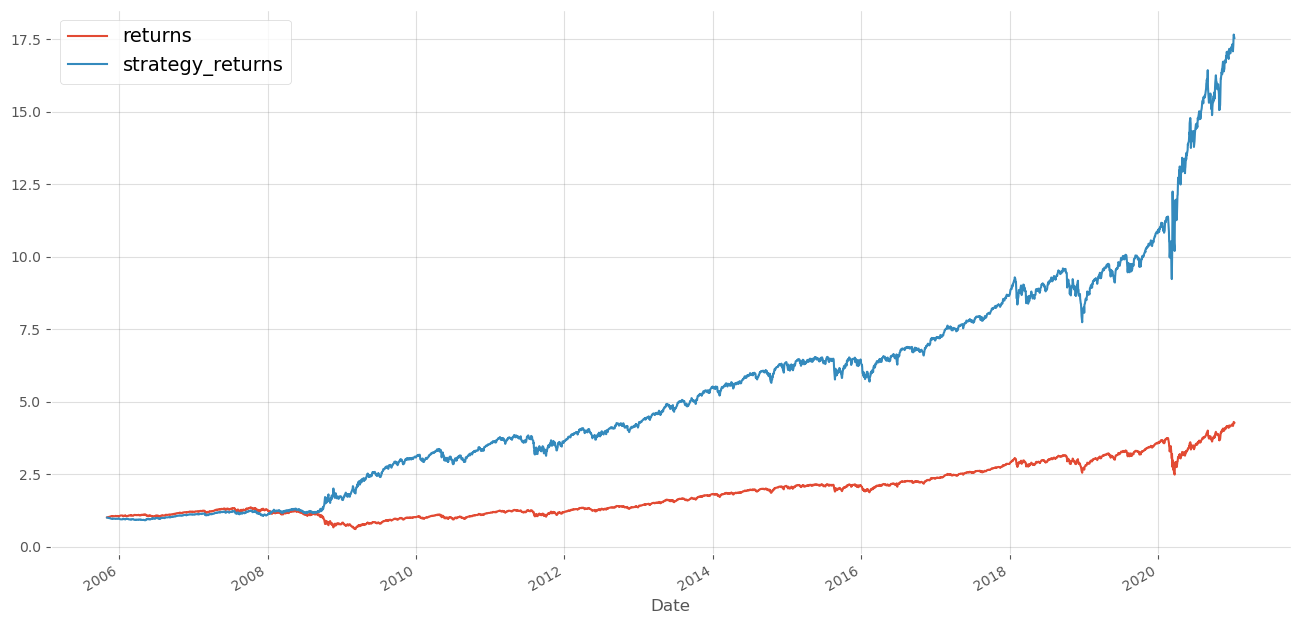

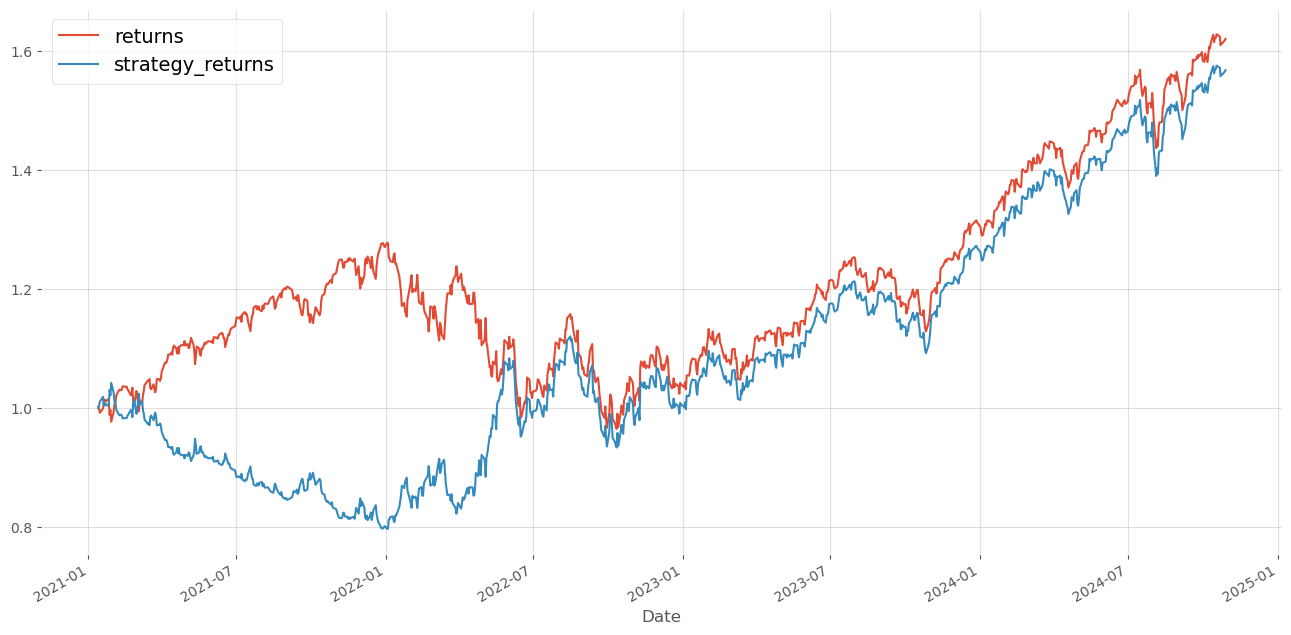

In [189]:
train_copy = create_indicators(window= 32, stock_df=train.copy())
train_copy = create_positions(stock_df=train_copy, MFI_low = 29, MFI_high= 27)
train_copy = create_returns(stock_df=train_copy)
train_copy[["returns", "strategy_returns"]].dropna().cumsum().apply(np.exp).plot(
        figsize=[16, 8]
)


test_copy = create_indicators(window= 32, stock_df=test.copy())
test_copy = create_positions(stock_df=test_copy, MFI_low = 29, MFI_high= 27)
test_copy = create_returns(stock_df=test_copy)
test_copy[["returns", "strategy_returns"]].dropna().cumsum().apply(np.exp).plot(
        figsize=[16, 8]
)




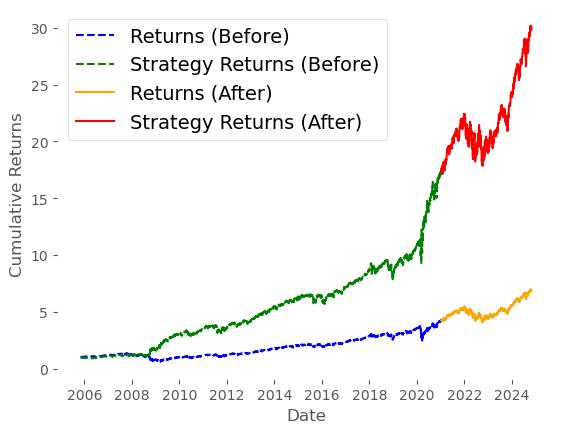

<Figure size 3200x1600 with 0 Axes>

<Figure size 3200x1600 with 0 Axes>

In [190]:
stock_copy = create_indicators(window= 32, stock_df=stock.copy())
stock_copy = create_positions(stock_df=stock_copy, MFI_low = 29, MFI_high= 27)
stock_copy = create_returns(stock_df=stock_copy)

# Calculate cumulative returns
cumulative_df = stock_copy[["returns", "strategy_returns"]].dropna().cumsum().apply(np.exp)

# Split data into before and after 2020
before = cumulative_df.loc[:train_copy.index[-1].strftime('%Y-%m-%d')]
after = cumulative_df.loc[test_copy.index[0].strftime('%Y-%m-%d'):]

plt.plot(before.index, before['returns'], label='Returns (Before)', linestyle='--', color='blue')
plt.plot(before.index, before['strategy_returns'], label='Strategy Returns (Before)', linestyle='--', color='green')

# Plot after 2020
plt.plot(after.index, after['returns'], label='Returns (After)', linestyle='-', color='orange')
plt.plot(after.index, after['strategy_returns'], label='Strategy Returns (After)', linestyle='-', color='red')

# Add labels, legend, and grid
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(32, 16))

### 1.3.2. Trading Strategy 2 - Ichimoku Cloud Momentum Strategy (by Lim Fang Yi)
> Indicator used: `Tenkan-Sen`, `Kijun-sen`, `Chiou Span`, `Senkou Span A`, `Senkou Span B`
> 
> Short Signal: MFI > `MFI_high` threshold suggests the asset is overbought, signaling a potential sell opportunity.
> 
> Buy Signal:  MFI < `MFI_low` threshold suggests the asset is underbought, signaling a potential buy opportunity.
>
> Hyperparameter tuning for `cumulative returns`:
> 1. Number of periods / candlesticks for tenkan-sen `period_tenkan`
> 2. Number of periods / candlesticks for kijun-sen `period_kijun`
> 3. Number of periods / price bars fpr Senkou Span B `period_senkou_span_b` 

In [192]:
def create_indicators(period_tenkan,
                      period_kijun,
                      period_senkou_span_b,
                      stock_df):


    # convert dates to integer values for later use with the 
    # matplotlib candlestick charting function (it doesn't accept datetimes)
    stock_df['Dates'] = dates.date2num(stock_df.index)

    # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
    nine_period_high = stock_df['High'].rolling(window= period_tenkan).max()
    nine_period_low = stock_df['Low'].rolling(window= period_tenkan).min()
    stock_df['tenkan_sen'] = (nine_period_high + nine_period_low) /2

    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    period26_high = stock_df['High'].rolling(window=period_kijun).max()
    period26_low = stock_df['Low'].rolling(window=period_kijun).min()
    stock_df['kijun_sen'] = (period26_high + period26_low) / 2

    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    stock_df['senkou_span_a'] = ((stock_df['tenkan_sen'] + stock_df['kijun_sen']) / 2).shift(period_kijun)

    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    period52_high = stock_df['High'].rolling(window=period_senkou_span_b).max()
    period52_low = stock_df['Low'].rolling(window=period_senkou_span_b).min()
    stock_df['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(period_kijun)

    # The most current closing price plotted 26 time periods behind (optional)
    stock_df['chikou_span'] = stock_df['Close'].shift(-period_kijun)

    # create a quick plot of the results to see what we have created
    # stock_df.drop(['Dates', 'Volume'], axis=1).plot(figsize=(15,7))

    return stock_df

def create_signals(stock_df):
    
    # First we drop any “Na” values from our DataFrame and 
    # then set the “regime marker” that will signify whether 
    # the prices are currently above, below 
    # or within the cloud structure
    # stock_df.dropna(inplace=True)
    stock_df['above_cloud'] = 0
    stock_df['above_cloud'] =\
        (np.where((stock_df['Low'] > stock_df['senkou_span_a'])
                  & (stock_df['Low'] > stock_df['senkou_span_b'] ), 
                  1, 
                  stock_df['above_cloud'])
            )
    stock_df['above_cloud'] = np.where(
        (stock_df['High'] < stock_df['senkou_span_a'])
        & (stock_df['High'] < stock_df['senkou_span_b']), 
        -1, stock_df['above_cloud']
        )
    
    # column signifying whether the Senkou Span A is above or
    # below the Senkou Span B
    stock_df['A_above_B'] = np.where(
        (stock_df['senkou_span_a'] > stock_df['senkou_span_b']), 
        1, -1
        )
    
    stock_df['tenkan_kiju_cross'] = np.NaN
    stock_df['tenkan_kiju_cross'] = np.where((stock_df['tenkan_sen'].shift(1) <= stock_df['kijun_sen'].shift(1)) & (stock_df['tenkan_sen'] > stock_df['kijun_sen']), 1, stock_df['tenkan_kiju_cross'])
    stock_df['tenkan_kiju_cross'] = np.where((stock_df['tenkan_sen'].shift(1) >= stock_df['kijun_sen'].shift(1)) & (stock_df['tenkan_sen'] < stock_df['kijun_sen']), -1, stock_df['tenkan_kiju_cross'])
    
    stock_df['price_tenkan_cross'] = np.NaN
    stock_df['price_tenkan_cross'] = np.where((stock_df['Open'].shift(1) <= stock_df['tenkan_sen'].shift(1)) & (stock_df['Open'] > stock_df['tenkan_sen']), 1, stock_df['price_tenkan_cross'])
    stock_df['price_tenkan_cross'] = np.where((stock_df['Open'].shift(1) >= stock_df['tenkan_sen'].shift(1)) & (stock_df['Open'] < stock_df['tenkan_sen']), -1, stock_df['price_tenkan_cross'])
    
    return stock_df

def create_positions(stock_df = train):
    
       
    stock_df['buy'] = np.NaN ## fill it with “np.NaN” values to act as a placeholder
    
    ## the value of a row in the ‘buy’ column is set to 1 if the first two criteria and met 
    ## (Prices are above the cloud AND Senkou Span A is above Senkou Span B), and EITHER of the final 2 criteria are met 
    ## (the Tenkan-sen crosses up through the Kijun-sen OR 4) prices cross up through the Tenkan-sen). 
    ## For any rows where these criteria are not met, the value on the ‘buy’ column remains as a np.NaN value.
    stock_df['buy'] =\
        (
            np.where((stock_df['above_cloud'].shift(1) == 1) & 
                   (stock_df['A_above_B'].shift(1) == 1) & 
                   ((stock_df['tenkan_kiju_cross'].shift(1) == 1)
                                                            | (stock_df['price_tenkan_cross'].shift(1) == 1)), 1, stock_df['buy'])
    )
    ## identify the rows in the ‘buy’column that correspond with a 
    ## positive instance of our closing criteria 
    ## (i.e. a crossing down of the Tenkan-sen through the Kijun-sen) 
    ## We fill these rows of the ‘buy’ column with a zero
    stock_df['buy'] =\
        (np.where
         (stock_df['tenkan_kiju_cross'].shift(1) == -1, 0, stock_df['buy'])
            )
    stock_df['buy'].ffill(inplace=True) 
    ## if 'buy' column = 1, we should in long posiiton. 'buy' column = 0, we should be in short position


    ## reverse the logic for 'sell' column
    stock_df['sell'] = np.NaN
    stock_df['sell'] = np.where((stock_df['above_cloud'].shift(1) == -1) & (stock_df['A_above_B'].shift(1) == -1) & ((stock_df['tenkan_kiju_cross'].shift(1) == -1) | (stock_df['price_tenkan_cross'].shift(1) == -1)), -1, stock_df['sell'])
    stock_df['sell'] = np.where(stock_df['tenkan_kiju_cross'].shift(1) == 1, 0, stock_df['sell'])
    stock_df['sell'].ffill(inplace=True)
    
    ## create position by summing sum the buy and sell
    stock_df['Position'] = stock_df['buy'] + stock_df['sell']
    
    return stock_df

# Evaluate the strategy
def evaluate_strategy(period_tenkan, period_kijun, period_senkou_span_b, stock_df):
    stock_df = create_indicators(period_tenkan,
                      period_kijun,
                      period_senkou_span_b ,
                      stock_df)
    stock_df = create_signals(stock_df)
    stock_df = create_positions(stock_df)
    stock_df = create_returns(stock_df)
    return stock_df['cumulative_returns'].iloc[-1]

def hyperparameter_tuning(stock_df):
    param_grid = {
        'period_tenkan': np.arange(9,60,2),
        'period_kijun': np.arange(9,60,2),
        'period_senkou_span_b': np.arange(9,60,2)
    }
    
    best_score = -np.inf
    best_params = None
    
    for params in ParameterGrid(param_grid):
        # Evaluate the strategy
        score = evaluate_strategy(
            params['period_tenkan'],
            params['period_kijun'],
            params['period_senkou_span_b'],
            stock_df.copy(),  # Use a copy to avoid modifying the original
        )
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score   

best_params, best_score = hyperparameter_tuning(train.copy())
print("Best Parameters:", best_params)
print("Best Score:", best_score)    

Best Parameters: {'period_kijun': 59, 'period_senkou_span_b': 23, 'period_tenkan': 57}
Best Score: 4.137943869241918


<Axes: xlabel='Date'>

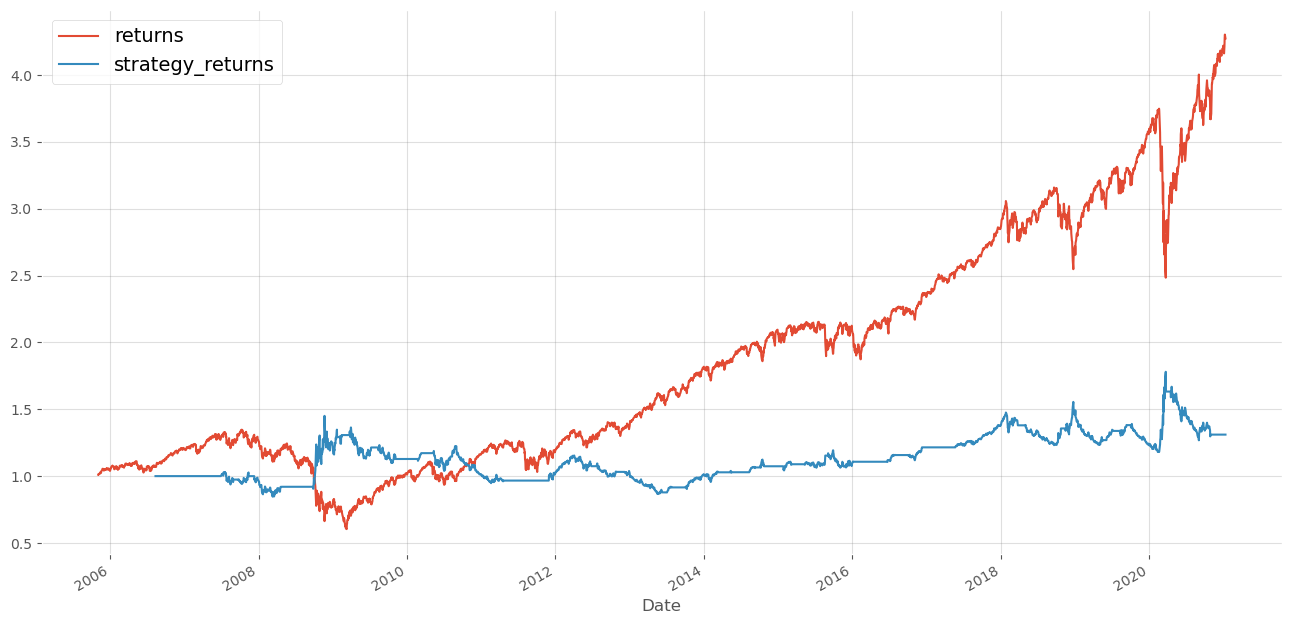

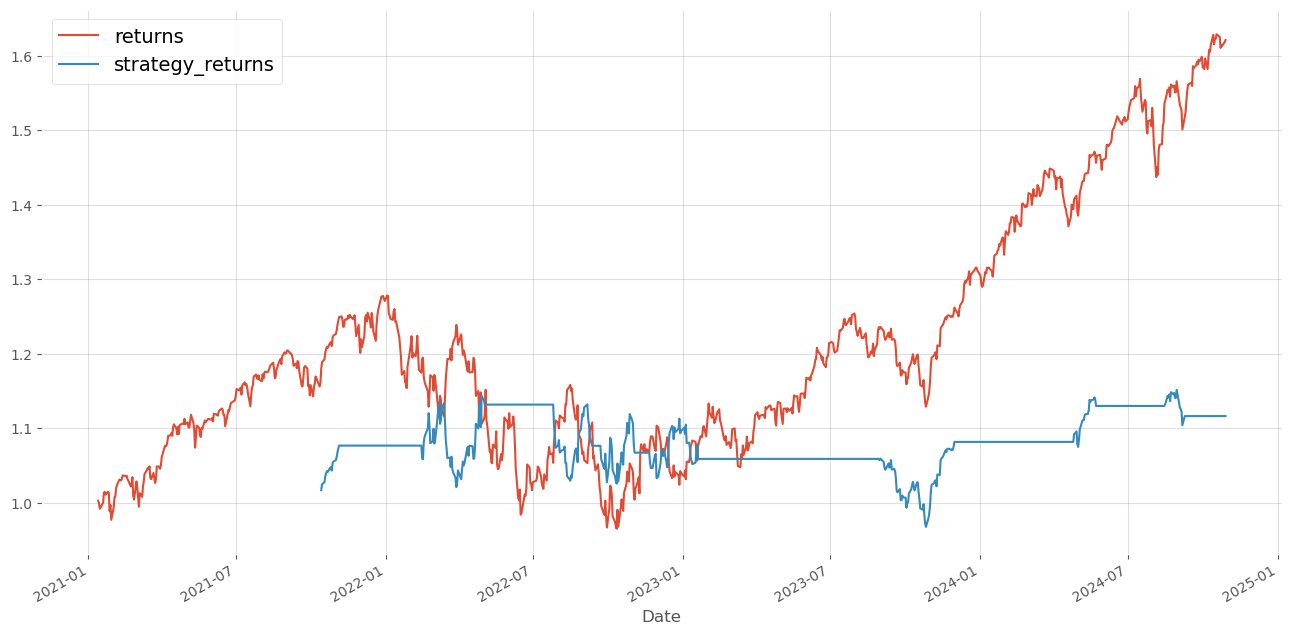

In [193]:
train_copy2 = create_indicators(period_tenkan = 59,
                      period_kijun = 23,
                      period_senkou_span_b = 57,
                      stock_df=train.copy())
train_copy2 = create_signals(train_copy2)
train_copy2 = create_positions(train_copy2)
train_copy2 = create_returns(train_copy2)
train_copy2[["returns", "strategy_returns"]].cumsum().apply(np.exp).plot(
        figsize=[16, 8]
)


test_copy2 = create_indicators(period_tenkan = 59,
                      period_kijun = 23,
                      period_senkou_span_b = 57,
                      stock_df=test.copy())
test_copy2 = create_signals(test_copy2)
test_copy2 = create_positions(test_copy2)
test_copy2 = create_returns(test_copy2)
test_copy2[["returns", "strategy_returns"]].cumsum().apply(np.exp).plot(
        figsize=[16, 8]
)

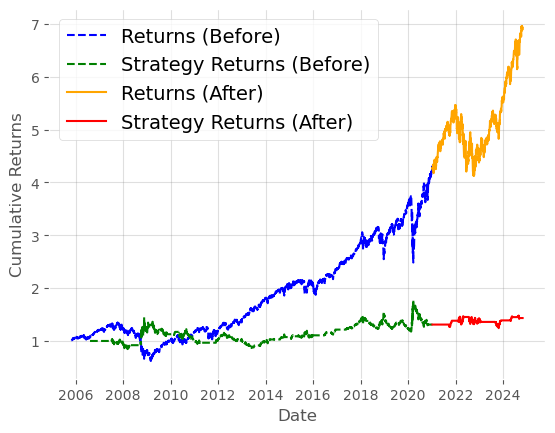

<Figure size 3200x1600 with 0 Axes>

<Figure size 3200x1600 with 0 Axes>

In [194]:
stock_copy2 = create_indicators(period_tenkan = 59,
                      period_kijun = 23,
                      period_senkou_span_b = 57,
                      stock_df=stock.copy())
stock_copy2 = create_signals(stock_copy2)
stock_copy2 = create_positions(stock_df=stock_copy2)
stock_copy2 = create_returns(stock_df=stock_copy2)

# Calculate cumulative returns
cumulative_df2 = stock_copy2[["returns", "strategy_returns"]].cumsum().apply(np.exp)

# Split data into before and after 2020
before2 = cumulative_df2.loc[:train_copy2.index[-1].strftime('%Y-%m-%d')]
after2 = cumulative_df2.loc[test_copy2.index[0].strftime('%Y-%m-%d'):]

plt.plot(before2.index, before2['returns'], label='Returns (Before)', linestyle='--', color='blue')
plt.plot(before2.index, before2['strategy_returns'], label='Strategy Returns (Before)', linestyle='--', color='green')

# Plot after 2020
plt.plot(after2.index, after2['returns'], label='Returns (After)', linestyle='-', color='orange')
plt.plot(after2.index, after2['strategy_returns'], label='Strategy Returns (After)', linestyle='-', color='red')

# Add labels, legend, and grid
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
# plt.grid()
plt.show()
plt.figure(figsize=(32, 16))

## 1.4. Strategies by Rahul:

In [196]:
def extract_all(stocks, start, end):
    def extract_single_ticker(ticker):
        return(web
               .get_data_yahoo(ticker, 
                               start,
                               end)
               )
    interim_df = map(extract_single_ticker, stocks)
    return(pd
           .concat(interim_df,
                  keys = stocks,
                  names = ["ticker", "date"]
                 )
          )

In [197]:
maang =\
    ["SPY"]

In [198]:
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)

In [199]:
SPY_prices =\
    extract_all(maang,
                start,
                end)

[*********************100%%**********************]  1 of 1 completed


In [200]:
SPY_prices

Open        High         Low       Close   Adj Close  \
ticker date                                                                     
SPY    2005-11-01  120.580002  120.900002  120.220001  120.489998   83.991135   
       2005-11-02  120.169998  121.750000  120.129997  121.750000   84.869461   
       2005-11-03  122.150002  122.660004  121.750000  122.269997   85.231956   
       2005-11-04  122.400002  122.459999  121.550003  122.110001   85.120399   
       2005-11-07  122.370003  122.620003  121.849998  122.230003   85.204063   
...                       ...         ...         ...         ...         ...   
       2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
       2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
       2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
       2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
       2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

                     Volume  
ticker date                  
SPY    2005-11-01  66365100  
       2005-11-02  74012300  
       2005-11-03  84897600  
       2005-11-04  59156000  
       2005-11-07  46765400  
...                     ...  
       2024-10-24  34979900  
       2024-10-25  47268200  
       2024-10-28  30174700  
       2024-10-29  42899700  
       2024-10-30  41435800  

[4781 rows x 6 columns]

In [201]:
DCP_WIDE =\
(
    SPY_prices # DF
    [["Adj Close"]] # DF
    .reset_index() # DF + 2 columns
    .pivot(index = "date", # from long format data to wide format data
           columns = "ticker",
           values = "Adj Close") 
)

In [202]:
DCP_WIDE

ticker             SPY
date                  
2005-11-01   83.991135
2005-11-02   84.869461
2005-11-03   85.231956
2005-11-04   85.120399
2005-11-07   85.204063
...                ...
2024-10-24  579.239990
2024-10-25  579.039978
2024-10-28  580.830017
2024-10-29  581.770020
2024-10-30  580.010010

[4781 rows x 1 columns]

In [203]:
SPY = DCP_WIDE[["SPY"]]
SPY

ticker             SPY
date                  
2005-11-01   83.991135
2005-11-02   84.869461
2005-11-03   85.231956
2005-11-04   85.120399
2005-11-07   85.204063
...                ...
2024-10-24  579.239990
2024-10-25  579.039978
2024-10-28  580.830017
2024-10-29  581.770020
2024-10-30  580.010010

[4781 rows x 1 columns]

In [204]:
SPY["mean"] =\
(
    DCP_WIDE
    [["SPY"]]
    .rolling(window = 22)
    .mean()
)

In [205]:
window = 22 # tunable hyper-parameters

In [206]:
# rolling minimum

SPY["min"] =\
(
    DCP_WIDE
    [["SPY"]]
    .rolling(window = window)
    .min()
)

In [207]:
# rolling maximum

SPY["max"] =\
(
    DCP_WIDE
    [["SPY"]]
    .rolling(window = window)
    .max()
)

In [208]:
# more robust rolling statistic (median)

SPY["median"] =\
(
    DCP_WIDE
    [["SPY"]]
    .rolling(window = window)
    .median()
)

In [209]:
SPY["EWMA"] =\
(
    DCP_WIDE
    [["SPY"]]
    .ewm(halflife = 10,
         min_periods = window)
    .mean()
)

<Axes: xlabel='date'>

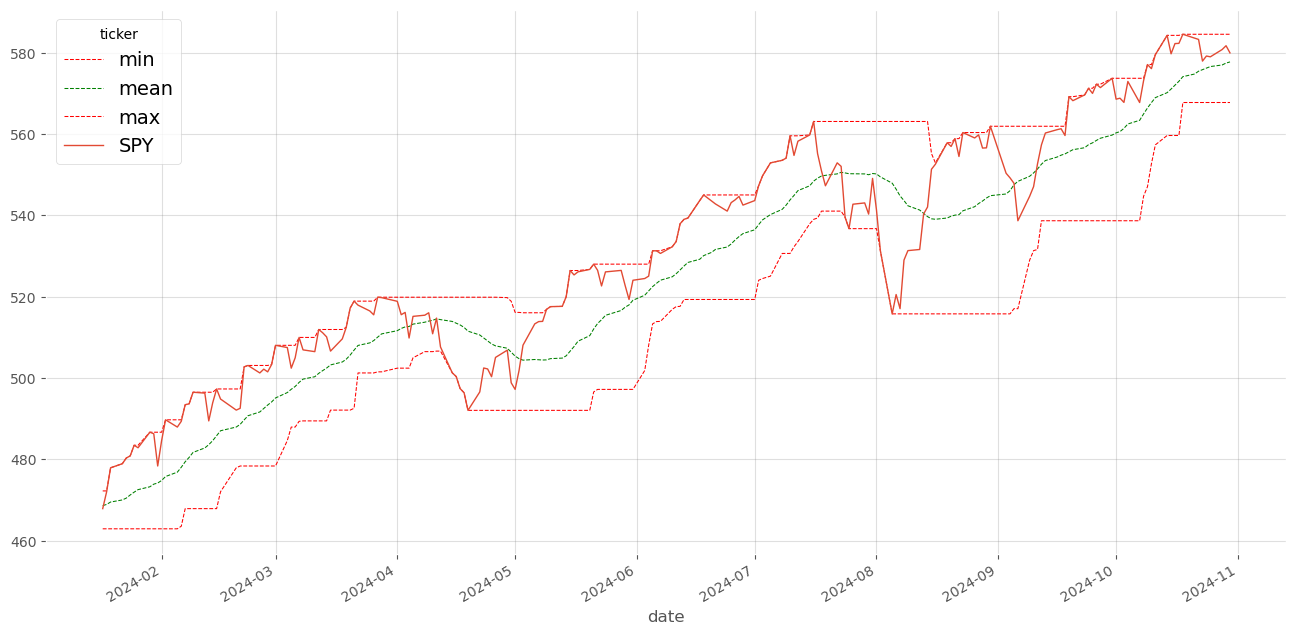

In [210]:
ax =\
(
    SPY
    [["min", "mean", "max"]]
    .iloc[-200: ] # most recent 200 days
    .plot(figsize = [16, 8],
          style = ["r--", "g--", "r--"],
          linewidth = 0.75)
)

(
    DCP_WIDE
    [["SPY"]]
    .iloc[-200: ]
    .plot(ax = ax,
          linewidth = 1)
)

In [211]:
DCP_WIDE["shorter_MA"] =\
(
    DCP_WIDE
    [["SPY"]]
    .rolling(window = 22) # look-back period
    .mean()
)

DCP_WIDE["longer_MA"] =\
(
    DCP_WIDE
    [["SPY"]]
    .rolling(window = 100)
    .mean()
)

<Axes: xlabel='date'>

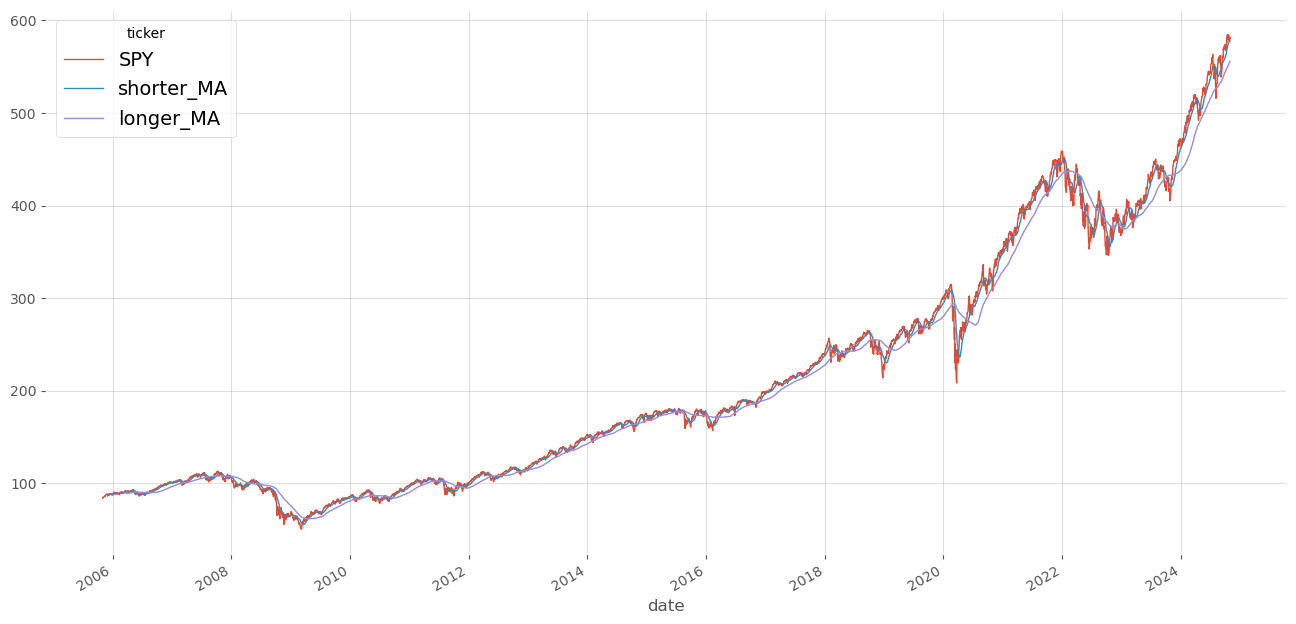

In [212]:
(
    DCP_WIDE
    [["SPY", "shorter_MA", "longer_MA"]]
    .plot(figsize = [16, 8],
          linewidth = 1)
)

In [213]:
DCP_WIDE =\
(
    DCP_WIDE
    .dropna()
)

In [214]:
DCP_WIDE["SPY_Trading_Positions"] =\
(
    np
    .where(DCP_WIDE["shorter_MA"] > DCP_WIDE["longer_MA"], 
           1, -1
          )
)

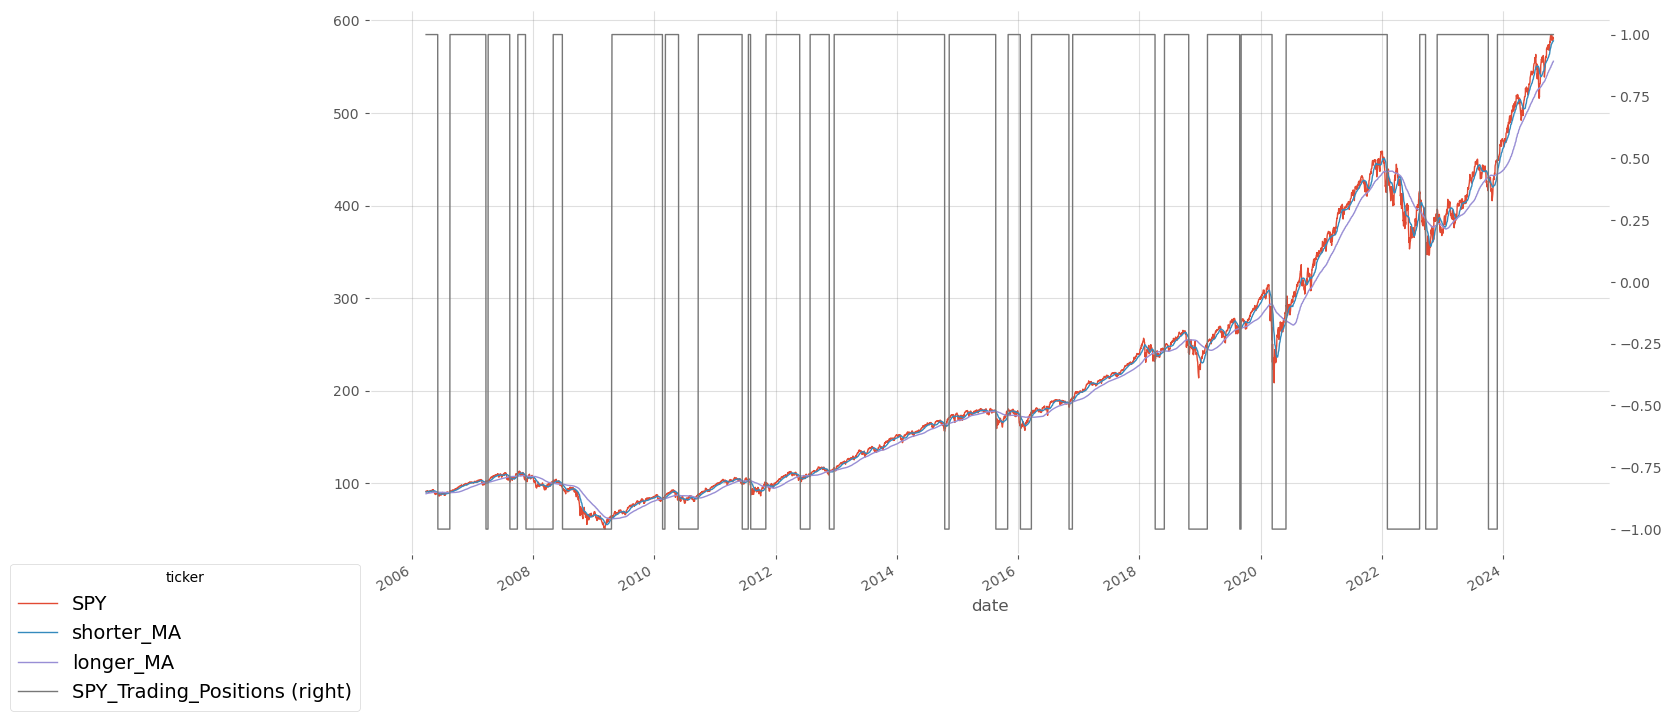

In [215]:
ax =\
(
    DCP_WIDE
    [["SPY", "shorter_MA", "longer_MA", "SPY_Trading_Positions"]]
    .plot(figsize = [16, 8],
          lw = 1,
          secondary_y = "SPY_Trading_Positions"
         )
)

(ax
 .get_legend()
 .set_bbox_to_anchor((.00, .00)
                    )
)

In [216]:
# stock = META

SPY1 =\
(
    web
    .get_data_yahoo("SPY",
                    start = dt.datetime(2005, 11, 1),
                    end = dt.datetime(2024, 10, 31)
                   )
)

SPY1

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-11-01  120.580002  120.900002  120.220001  120.489998   83.991135   
2005-11-02  120.169998  121.750000  120.129997  121.750000   84.869461   
2005-11-03  122.150002  122.660004  121.750000  122.269997   85.231956   
2005-11-04  122.400002  122.459999  121.550003  122.110001   85.120399   
2005-11-07  122.370003  122.620003  121.849998  122.230003   85.204063   
...                ...         ...         ...         ...         ...   
2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

              Volume  
Date                  
2005-11-01  66365100  
2005-11-02  74012300  
2005-11-03  84897600  
2005-11-04  59156000  
2005-11-07  46765400  
...              ...  
2024-10-24  34979900  
2024-10-25  47268200  
2024-10-28  30174700  
2024-10-29  42899700  
2024-10-30  41435800  

[4781 rows x 6 columns]

In [217]:
short = 20 # make this as tunable object
long = 60 # make this as tunable object

In [218]:
BUY_or_SELL =\
(
    pd
    .DataFrame(index = SPY1.index)
)

BUY_or_SELL

Empty DataFrame
Columns: []
Index: [2005-11-01 00:00:00, 2005-11-02 00:00:00, 2005-11-03 00:00:00, 2005-11-04 00:00:00, 2005-11-07 00:00:00, 2005-11-08 00:00:00, 2005-11-09 00:00:00, 2005-11-10 00:00:00, 2005-11-11 00:00:00, 2005-11-14 00:00:00, 2005-11-15 00:00:00, 2005-11-16 00:00:00, 2005-11-17 00:00:00, 2005-11-18 00:00:00, 2005-11-21 00:00:00, 2005-11-22 00:00:00, 2005-11-23 00:00:00, 2005-11-25 00:00:00, 2005-11-28 00:00:00, 2005-11-29 00:00:00, 2005-11-30 00:00:00, 2005-12-01 00:00:00, 2005-12-02 00:00:00, 2005-12-05 00:00:00, 2005-12-06 00:00:00, 2005-12-07 00:00:00, 2005-12-08 00:00:00, 2005-12-09 00:00:00, 2005-12-12 00:00:00, 2005-12-13 00:00:00, 2005-12-14 00:00:00, 2005-12-15 00:00:00, 2005-12-16 00:00:00, 2005-12-19 00:00:00, 2005-12-20 00:00:00, 2005-12-21 00:00:00, 2005-12-22 00:00:00, 2005-12-23 00:00:00, 2005-12-27 00:00:00, 2005-12-28 00:00:00, 2005-12-29 00:00:00, 2005-12-30 00:00:00, 2006-01-03 00:00:00, 2006-01-04 00:00:00, 2006-01-05 00:00:00, 2006-01-06 00:00:00, 2006-01-09 00:00:00, 2006-01-10 00:00:00, 2006-01-11 00:00:00, 2006-01-12 00:00:00, 2006-01-13 00:00:00, 2006-01-17 00:00:00, 2006-01-18 00:00:00, 2006-01-19 00:00:00, 2006-01-20 00:00:00, 2006-01-23 00:00:00, 2006-01-24 00:00:00, 2006-01-25 00:00:00, 2006-01-26 00:00:00, 2006-01-27 00:00:00, 2006-01-30 00:00:00, 2006-01-31 00:00:00, 2006-02-01 00:00:00, 2006-02-02 00:00:00, 2006-02-03 00:00:00, 2006-02-06 00:00:00, 2006-02-07 00:00:00, 2006-02-08 00:00:00, 2006-02-09 00:00:00, 2006-02-10 00:00:00, 2006-02-13 00:00:00, 2006-02-14 00:00:00, 2006-02-15 00:00:00, 2006-02-16 00:00:00, 2006-02-17 00:00:00, 2006-02-21 00:00:00, 2006-02-22 00:00:00, 2006-02-23 00:00:00, 2006-02-24 00:00:00, 2006-02-27 00:00:00, 2006-02-28 00:00:00, 2006-03-01 00:00:00, 2006-03-02 00:00:00, 2006-03-03 00:00:00, 2006-03-06 00:00:00, 2006-03-07 00:00:00, 2006-03-08 00:00:00, 2006-03-09 00:00:00, 2006-03-10 00:00:00, 2006-03-13 00:00:00, 2006-03-14 00:00:00, 2006-03-15 00:00:00, 2006-03-16 00:00:00, 2006-03-17 00:00:00, 2006-03-20 00:00:00, 2006-03-21 00:00:00, 2006-03-22 00:00:00, 2006-03-23 00:00:00, 2006-03-24 00:00:00, 2006-03-27 00:00:00, ...]

[4781 rows x 0 columns]

In [219]:
BUY_or_SELL["BUY_or_SELL"] = 0.0
BUY_or_SELL

BUY_or_SELL
Date                   
2005-11-01          0.0
2005-11-02          0.0
2005-11-03          0.0
2005-11-04          0.0
2005-11-07          0.0
...                 ...
2024-10-24          0.0
2024-10-25          0.0
2024-10-28          0.0
2024-10-29          0.0
2024-10-30          0.0

[4781 rows x 1 columns]

In [220]:
# shorter-term

BUY_or_SELL["shorter_SMA"] =\
(
    SPY1
    ["Close"]
    .rolling(window = short,
             min_periods = 1,
             center = False)
    .mean()
)

# longer-term

BUY_or_SELL["longer_SMA"] =\
(
    SPY1
    ["Close"]
    .rolling(window = long,
             min_periods = 1,
             center = False)
    .mean()
)

BUY_or_SELL

BUY_or_SELL  shorter_SMA  longer_SMA
Date                                            
2005-11-01          0.0   120.489998  120.489998
2005-11-02          0.0   121.119999  121.119999
2005-11-03          0.0   121.503332  121.503332
2005-11-04          0.0   121.654999  121.654999
2005-11-07          0.0   121.770000  121.770000
...                 ...          ...         ...
2024-10-24          0.0   576.742499  560.542665
2024-10-25          0.0   577.120999  561.143164
2024-10-28          0.0   577.474500  561.941997
2024-10-29          0.0   578.132001  563.015164
2024-10-30          0.0   578.689502  563.979497

[4781 rows x 3 columns]

In [221]:
BUY_or_SELL["BUY_or_SELL"][short: ] =\
(
    np
    .where(BUY_or_SELL["shorter_SMA"][short: ] > BUY_or_SELL["longer_SMA"][short: ],
           1.0, 0.0
          )
)

BUY_or_SELL

BUY_or_SELL  shorter_SMA  longer_SMA
Date                                            
2005-11-01          0.0   120.489998  120.489998
2005-11-02          0.0   121.119999  121.119999
2005-11-03          0.0   121.503332  121.503332
2005-11-04          0.0   121.654999  121.654999
2005-11-07          0.0   121.770000  121.770000
...                 ...          ...         ...
2024-10-24          1.0   576.742499  560.542665
2024-10-25          1.0   577.120999  561.143164
2024-10-28          1.0   577.474500  561.941997
2024-10-29          1.0   578.132001  563.015164
2024-10-30          1.0   578.689502  563.979497

[4781 rows x 3 columns]

In [222]:
BUY_or_SELL["Positions"] =\
(
    BUY_or_SELL["BUY_or_SELL"]
    .diff()
)

BUY_or_SELL

BUY_or_SELL  shorter_SMA  longer_SMA  Positions
Date                                                       
2005-11-01          0.0   120.489998  120.489998        NaN
2005-11-02          0.0   121.119999  121.119999        0.0
2005-11-03          0.0   121.503332  121.503332        0.0
2005-11-04          0.0   121.654999  121.654999        0.0
2005-11-07          0.0   121.770000  121.770000        0.0
...                 ...          ...         ...        ...
2024-10-24          1.0   576.742499  560.542665        0.0
2024-10-25          1.0   577.120999  561.143164        0.0
2024-10-28          1.0   577.474500  561.941997        0.0
2024-10-29          1.0   578.132001  563.015164        0.0
2024-10-30          1.0   578.689502  563.979497        0.0

[4781 rows x 4 columns]

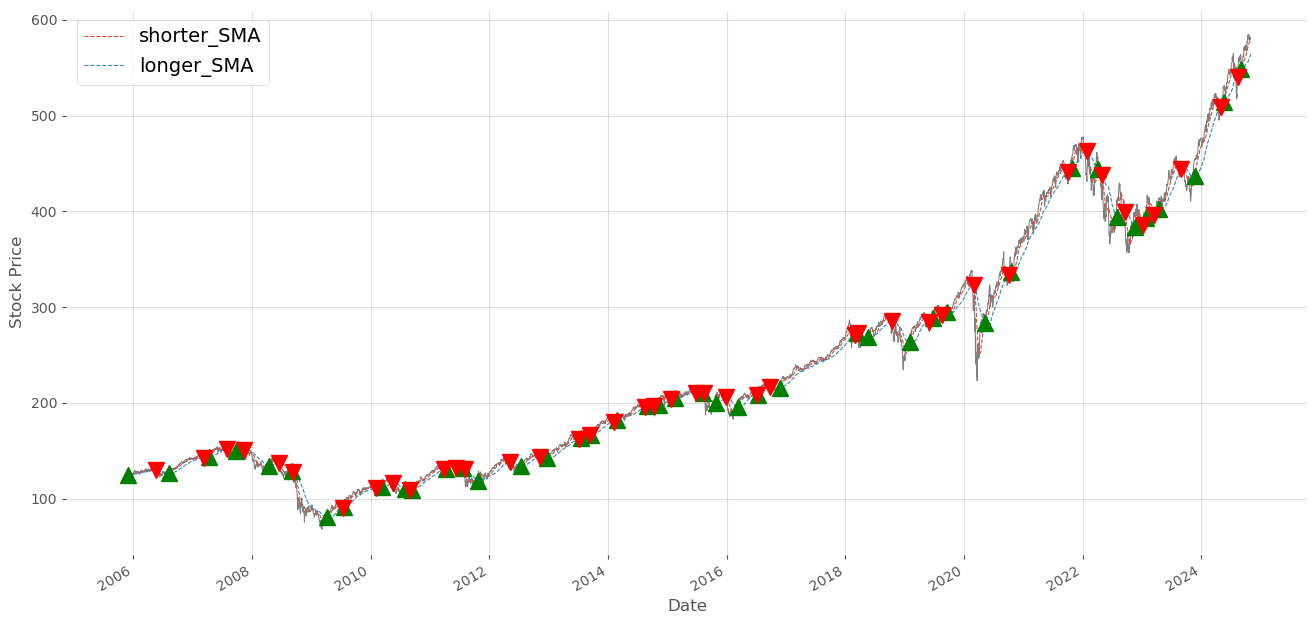

In [223]:
fig =\
(
    plt
    .figure(figsize = [16, 8]
           )
)

sub =\
(
    fig
    .add_subplot(111,
                 ylabel = "Stock Price")
)

(
    SPY1
    ["Close"]
    .plot(ax = sub,
          color = "grey",
          linewidth = 0.75)
)

(
    BUY_or_SELL
    [["shorter_SMA", "longer_SMA"]]
    .plot(ax = sub,
          style = ["--", "--"],
          linewidth = 0.80)
)

# BUY signal

(
    sub
    .plot(BUY_or_SELL.loc[BUY_or_SELL.Positions == 1.0].index,
          BUY_or_SELL.shorter_SMA[BUY_or_SELL.Positions == 1.0],
          "^",
          color = "green",
          markersize = 12)
)

# SELL signal

(
    sub
    .plot(BUY_or_SELL.loc[BUY_or_SELL.Positions == -1.0].index,
          BUY_or_SELL.shorter_SMA[BUY_or_SELL.Positions == -1.0],
          "v",
          color = "red",
          markersize = 12)
)

In [224]:
Capital = 100000

In [225]:
BUY_or_SELL

BUY_or_SELL  shorter_SMA  longer_SMA  Positions
Date                                                       
2005-11-01          0.0   120.489998  120.489998        NaN
2005-11-02          0.0   121.119999  121.119999        0.0
2005-11-03          0.0   121.503332  121.503332        0.0
2005-11-04          0.0   121.654999  121.654999        0.0
2005-11-07          0.0   121.770000  121.770000        0.0
...                 ...          ...         ...        ...
2024-10-24          1.0   576.742499  560.542665        0.0
2024-10-25          1.0   577.120999  561.143164        0.0
2024-10-28          1.0   577.474500  561.941997        0.0
2024-10-29          1.0   578.132001  563.015164        0.0
2024-10-30          1.0   578.689502  563.979497        0.0

[4781 rows x 4 columns]

In [226]:
Position = pd.DataFrame()
Position["SPY1"] =\
(
    200
    *
    BUY_or_SELL["BUY_or_SELL"]
)

Position

SPY1
Date             
2005-11-01    0.0
2005-11-02    0.0
2005-11-03    0.0
2005-11-04    0.0
2005-11-07    0.0
...           ...
2024-10-24  200.0
2024-10-25  200.0
2024-10-28  200.0
2024-10-29  200.0
2024-10-30  200.0

[4781 rows x 1 columns]

In [227]:
Portfolio =\
(
    Position
    .multiply(SPY1["Close"],
              axis = 0)
)

In [228]:
difference_in_shares_owned =\
(
    Position
    .diff()
)

difference_in_shares_owned

SPY1
Date            
2005-11-01   NaN
2005-11-02   0.0
2005-11-03   0.0
2005-11-04   0.0
2005-11-07   0.0
...          ...
2024-10-24   0.0
2024-10-25   0.0
2024-10-28   0.0
2024-10-29   0.0
2024-10-30   0.0

[4781 rows x 1 columns]

In [229]:
Portfolio["our_holdings"] =\
(
    Position
    .multiply(SPY1["Close"],
              axis = 0)
).sum(axis = 1)

In [230]:
Portfolio["our_cash"] =\
(
    Capital - (difference_in_shares_owned
               .multiply(SPY1["Close"],
                         axis = 0)
               .sum(axis = 1)
              ).cumsum()
)

Portfolio

SPY1   our_holdings       our_cash
Date                                                   
2005-11-01       0.000000       0.000000  100000.000000
2005-11-02       0.000000       0.000000  100000.000000
2005-11-03       0.000000       0.000000  100000.000000
2005-11-04       0.000000       0.000000  100000.000000
2005-11-07       0.000000       0.000000  100000.000000
...                   ...            ...            ...
2024-10-24  115847.998047  115847.998047   38237.982178
2024-10-25  115807.995605  115807.995605   38237.982178
2024-10-28  116166.003418  116166.003418   38237.982178
2024-10-29  116354.003906  116354.003906   38237.982178
2024-10-30  116002.001953  116002.001953   38237.982178

[4781 rows x 3 columns]

In [231]:
Portfolio["total"] =\
    Portfolio["our_cash"] + Portfolio["our_holdings"]

Portfolio

SPY1   our_holdings       our_cash          total
Date                                                                  
2005-11-01       0.000000       0.000000  100000.000000  100000.000000
2005-11-02       0.000000       0.000000  100000.000000  100000.000000
2005-11-03       0.000000       0.000000  100000.000000  100000.000000
2005-11-04       0.000000       0.000000  100000.000000  100000.000000
2005-11-07       0.000000       0.000000  100000.000000  100000.000000
...                   ...            ...            ...            ...
2024-10-24  115847.998047  115847.998047   38237.982178  154085.980225
2024-10-25  115807.995605  115807.995605   38237.982178  154045.977783
2024-10-28  116166.003418  116166.003418   38237.982178  154403.985596
2024-10-29  116354.003906  116354.003906   38237.982178  154591.986084
2024-10-30  116002.001953  116002.001953   38237.982178  154239.984131

[4781 rows x 4 columns]

In [232]:
Portfolio["returns"] =\
(
    Portfolio
    ["total"]
    .pct_change()
)

Portfolio

SPY1   our_holdings       our_cash          total  \
Date                                                                     
2005-11-01       0.000000       0.000000  100000.000000  100000.000000   
2005-11-02       0.000000       0.000000  100000.000000  100000.000000   
2005-11-03       0.000000       0.000000  100000.000000  100000.000000   
2005-11-04       0.000000       0.000000  100000.000000  100000.000000   
2005-11-07       0.000000       0.000000  100000.000000  100000.000000   
...                   ...            ...            ...            ...   
2024-10-24  115847.998047  115847.998047   38237.982178  154085.980225   
2024-10-25  115807.995605  115807.995605   38237.982178  154045.977783   
2024-10-28  116166.003418  116166.003418   38237.982178  154403.985596   
2024-10-29  116354.003906  116354.003906   38237.982178  154591.986084   
2024-10-30  116002.001953  116002.001953   38237.982178  154239.984131   

             returns  
Date                  
2005-11-01       NaN  
2005-11-02  0.000000  
2005-11-03  0.000000  
2005-11-04  0.000000  
2005-11-07  0.000000  
...              ...  
2024-10-24  0.001625  
2024-10-25 -0.000260  
2024-10-28  0.002324  
2024-10-29  0.001218  
2024-10-30 -0.002277  

[4781 rows x 5 columns]

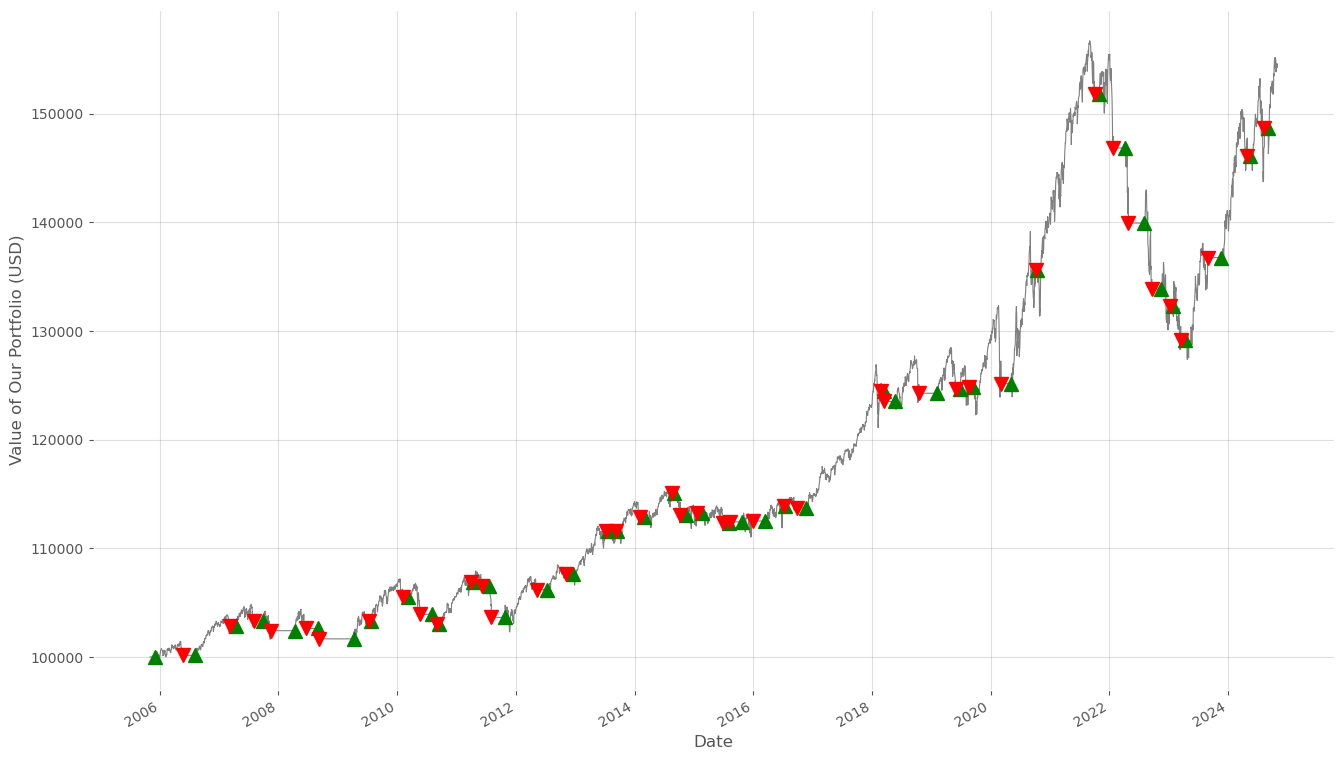

In [233]:
fig =\
(
    plt
    .figure(figsize = [16, 10]
           )
)

sub =\
(
    fig
    .add_subplot(111,
                 ylabel = "Value of Our Portfolio (USD)")
)

(
    Portfolio
    ["total"]
    .plot(ax = sub,
          color = "grey",
          linewidth = 0.80)
)

# Buy signal

(
    sub
    .plot(Portfolio.loc[BUY_or_SELL.Positions == 1.0].index,
          Portfolio.total[BUY_or_SELL.Positions == 1.0],
          "^",
          color = "green",
          markersize = 10
         )
)

# Sell signal

(
    sub
    .plot(Portfolio.loc[BUY_or_SELL.Positions == -1.0].index,
          Portfolio.total[BUY_or_SELL.Positions == -1.0],
          "v",
          color = "red",
          markersize = 10
         )
)

In [234]:
Sharpe =\
(
    (
     Portfolio["returns"].mean() 
     / 
     Portfolio["returns"].std()
    ) * np.sqrt(252)
)
Sharpe

0.49252487315898724

In [235]:
window = 252
rolling_max =\
(
    SPY1
    ["Close"] # returns Series
    .rolling(window = window,
             min_periods = 1)
    .max()
)

daily_drawdown =\
(
    SPY1["Close"] / rolling_max - 1.0
)

# we are calculating daily drawdown here
# = how much closing price has droppped from the rolling maximum

max_daily_drawdown =\
(
    daily_drawdown
    .rolling(window = window,
             min_periods = 1)
    .min()
)

# Team, we are calculating the rolling maximum drawdown over the previous window days.

In [236]:
days =\
(
    (SPY1
     .index[-1]
     - 
    SPY1
    .index[0]
    ).days
)

days

6938

In [237]:
CAGR =\
(
    (
    (
    (SPY1["Close"][-1] / SPY1["Close"][0])
    ) ** (365.0 / days)
    ) -1
)

CAGR

0.08618725965197771

In [238]:
Portfolio["strat_returns"] =\
(
    Portfolio
    ["total"]
    .pct_change()
)

Portfolio

SPY1   our_holdings       our_cash          total  \
Date                                                                     
2005-11-01       0.000000       0.000000  100000.000000  100000.000000   
2005-11-02       0.000000       0.000000  100000.000000  100000.000000   
2005-11-03       0.000000       0.000000  100000.000000  100000.000000   
2005-11-04       0.000000       0.000000  100000.000000  100000.000000   
2005-11-07       0.000000       0.000000  100000.000000  100000.000000   
...                   ...            ...            ...            ...   
2024-10-24  115847.998047  115847.998047   38237.982178  154085.980225   
2024-10-25  115807.995605  115807.995605   38237.982178  154045.977783   
2024-10-28  116166.003418  116166.003418   38237.982178  154403.985596   
2024-10-29  116354.003906  116354.003906   38237.982178  154591.986084   
2024-10-30  116002.001953  116002.001953   38237.982178  154239.984131   

             returns  strat_returns  
Date                                 
2005-11-01       NaN            NaN  
2005-11-02  0.000000       0.000000  
2005-11-03  0.000000       0.000000  
2005-11-04  0.000000       0.000000  
2005-11-07  0.000000       0.000000  
...              ...            ...  
2024-10-24  0.001625       0.001625  
2024-10-25 -0.000260      -0.000260  
2024-10-28  0.002324       0.002324  
2024-10-29  0.001218       0.001218  
2024-10-30 -0.002277      -0.002277  

[4781 rows x 6 columns]

# `PART 2`
> Computes Sharpe Ratio, CAGR, Maximum Drawdown, and Final Account Value.

### 1. SMA Strategy (Kevin) - Sharpe, CAGR, Max Drawdown, Final Acc Value

In [241]:
sma_result_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-11-01  120.580002  120.900002  120.220001  120.489998   83.991135   
2005-11-02  120.169998  121.750000  120.129997  121.750000   84.869461   
2005-11-03  122.150002  122.660004  121.750000  122.269997   85.231956   
2005-11-04  122.400002  122.459999  121.550003  122.110001   85.120399   
2005-11-07  122.370003  122.620003  121.849998  122.230003   85.204063   
...                ...         ...         ...         ...         ...   
2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

              Volume  shorter_SMA  longer_SMA  BUY_or_SELL  Positions  \
Date                                                                    
2005-11-01  66365100          NaN         NaN          0.0        NaN   
2005-11-02  74012300          NaN         NaN          0.0        0.0   
2005-11-03  84897600          NaN         NaN          0.0        0.0   
2005-11-04  59156000          NaN         NaN          0.0        0.0   
2005-11-07  46765400          NaN         NaN          0.0        0.0   
...              ...          ...         ...          ...        ...   
2024-10-24  34979900   579.381430  557.552929          1.0        0.0   
2024-10-25  47268200   580.184287  557.953929          1.0        0.0   
2024-10-28  30174700   580.731432  558.432769          1.0        0.0   
2024-10-29  42899700   581.062147  558.844427          1.0        0.0   
2024-10-30  41435800   581.339290  559.243332          1.0        0.0   

            shares_bought       holdings           cash          total  \
Date                                                                     
2005-11-01            0.0       0.000000  100000.000000  100000.000000   
2005-11-02            0.0       0.000000  100000.000000  100000.000000   
2005-11-03            0.0       0.000000  100000.000000  100000.000000   
2005-11-04            0.0       0.000000  100000.000000  100000.000000   
2005-11-07            0.0       0.000000  100000.000000  100000.000000   
...                   ...            ...            ...            ...   
2024-10-24          749.5  434140.372681  -72234.501873  361905.870808   
2024-10-25          749.5  433990.463531  -72234.501873  361755.961658   
2024-10-28          749.5  435332.097809  -72234.501873  363097.595936   
2024-10-29          749.5  436036.629639  -72234.501873  363802.127766   
2024-10-30          749.5  434717.502319  -72234.501873  362483.000446   

            strategy_returns  cum_strategy_return  SPY_return  SPY_cum_return  \
Date                                                                            
2005-11-01               NaN                  NaN         NaN             NaN   
2005-11-02          0.000000             1.000000    0.010403        1.010457   
2005-11-03          0.000000             1.000000    0.004262        1.014773   
2005-11-04          0.000000             1.000000   -0.001310        1.013445   
2005-11-07          0.000000             1.000000    0.000982        1.014441   
...                      ...                  ...         ...             ...   
2024-10-24          0.002592             3.619059    0.002160        6.896442   
2024-10-25         -0.000414             3.617560   -0.000345        6.894061   
2024-10-28          0.003702             3.630976    0.003087        6.915373   
2024-10-29          0.001938             3.638021    0.001617        6.926565   
2024-10-30         -0.003633             3.624830   -0.003030        6.905610   

            gross_max_performance  
Date                               
2005-11-01      

In [242]:
def calculate_performance_metrics(strategy_return, cum_strategy_return, gross_max_performance, initial_capital=100000):
    strategy_return = np.exp(strategy_return)
    # Calculate Sharpe Ratio
    risk_free_rate = 0  
    excess_return = strategy_return - risk_free_rate - 1
    sharpe_ratio = excess_return.mean() / excess_return.std() * np.sqrt(252)

    # Calculate CAGR
    total_periods = len(cum_strategy_return)
    total_years = total_periods / 252  # Assume 252 trading days in a year
    cagr = (cum_strategy_return.iloc[-1]) ** (1 / total_years) - 1

    # Calculate Max Drawdown
    drawdown = gross_max_performance - cum_strategy_return
    max_drawdown = (drawdown / gross_max_performance).max()

    # Calculate Final Account Value
    final_account_value = cum_strategy_return.iloc[-1] * initial_capital

    return {
        "Sharpe Ratio": sharpe_ratio,
        "CAGR": cagr,
        "Max Drawdown (%)": max_drawdown*100,
        "Final Account Value ($)": final_account_value,
    }


In [243]:
sma_metric = calculate_performance_metrics(strategy_return = sma_result_df['strategy_returns'],
                              cum_strategy_return = sma_result_df['cum_strategy_return'],
                              gross_max_performance = sma_result_df['gross_max_performance'],
                              initial_capital=100000)

sma_metric_df = pd.DataFrame(sma_metric, index=['SMA'])
sma_metric_df

Sharpe Ratio      CAGR  Max Drawdown (%)  Final Account Value ($)
SMA      0.757323  0.070235         23.440907            362483.000446

### 2. EWMA (Kevin) - Sharpe, CAGR, Max Drawdown, Final Acc Value

In [245]:
ewma_result_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-11-01  120.580002  120.900002  120.220001  120.489998   83.991135   
2005-11-02  120.169998  121.750000  120.129997  121.750000   84.869461   
2005-11-03  122.150002  122.660004  121.750000  122.269997   85.231956   
2005-11-04  122.400002  122.459999  121.550003  122.110001   85.120399   
2005-11-07  122.370003  122.620003  121.849998  122.230003   85.204063   
...                ...         ...         ...         ...         ...   
2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

              Volume  shorter_SMA  longer_SMA  BUY_or_SELL  Positions  ...  \
Date                                                                   ...   
2005-11-01  66365100          NaN         NaN          0.0        NaN  ...   
2005-11-02  74012300          NaN         NaN          0.0        0.0  ...   
2005-11-03  84897600          NaN         NaN          0.0        0.0  ...   
2005-11-04  59156000          NaN         NaN          0.0        0.0  ...   
2005-11-07  46765400          NaN         NaN          0.0        0.0  ...   
...              ...          ...         ...          ...        ...  ...   
2024-10-24  34979900   579.381430  557.552929          1.0        0.0  ...   
2024-10-25  47268200   580.184287  557.953929          1.0        0.0  ...   
2024-10-28  30174700   580.731432  558.432769          1.0        0.0  ...   
2024-10-29  42899700   581.062147  558.844427          1.0        0.0  ...   
2024-10-30  41435800   581.339290  559.243332          1.0        0.0  ...   

                 holdings           cash          total  strategy_returns  \
Date                                                                        
2005-11-01       0.000000  100000.000000  100000.000000               NaN   
2005-11-02       0.000000  100000.000000  100000.000000          0.000000   
2005-11-03       0.000000  100000.000000  100000.000000          0.000000   
2005-11-04       0.000000  100000.000000  100000.000000          0.000000   
2005-11-07       0.000000  100000.000000  100000.000000          0.000000   
...                   ...            ...            ...               ...   
2024-10-24  376505.993652  -29162.684631  347343.309021          0.002342   
2024-10-25  376375.985718  -29162.684631  347213.301086         -0.000374   
2024-10-28  377539.511108  -29162.684631  348376.826477          0.003345   
2024-10-29  378150.512695  -29162.684631  348987.828064          0.001752   
2024-10-30  377006.506348  -29162.684631  347843.821716         -0.003283   

            cum_strategy_return  shorter_EWMA  longer_EWMA  SPY_return  \
Date                                                                     
2005-11-01                  NaN           NaN          NaN         NaN   
2005-11-02             1.000000           NaN          NaN    0.010403   
2005-11-03             1.000000           NaN          NaN    0.004262   
2005-11-04             1.000000           NaN          NaN   -0.001310   
2005-11-07             1.000000           NaN          NaN    0.000982   
...                         ...           ...          ...         ...   
2024-10-24             3.473433    580.466891   540.965727    0.002160   
2024-10-25             3.472133    580.149799   541.476791   -0.000345   
2024-10-28             3.483768    580.300959   542.005022    0.003087   
2024-10-29             3.489878    580.627417   542.538781    0.001617   
2024-10-30             3.478438    580.490215   543.041750   -0.003030   

            SPY_cum_return  gross_max_performance  
Date                   

In [246]:
ewma_metric = calculate_performance_metrics(strategy_return = ewma_result_df['strategy_returns'],
                              cum_strategy_return = ewma_result_df['cum_strategy_return'],
                              gross_max_performance = ewma_result_df['gross_max_performance'],
                              initial_capital=100000)


ewma_metric_df = pd.DataFrame(ewma_metric, index=['EWMA'])
ewma_metric_df

Sharpe Ratio      CAGR  Max Drawdown (%)  Final Account Value ($)
EWMA      0.763582  0.067912         27.707293            347843.821716

### 3. Time Series (1 Parameter) Strategy (Kevin) - Sharpe, CAGR, Max Drawdown, Final Acc Value

In [248]:
time_series_result_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-11-01  120.580002  120.900002  120.220001  120.489998   83.991135   
2005-11-02  120.169998  121.750000  120.129997  121.750000   84.869461   
2005-11-03  122.150002  122.660004  121.750000  122.269997   85.231956   
2005-11-04  122.400002  122.459999  121.550003  122.110001   85.120399   
2005-11-07  122.370003  122.620003  121.849998  122.230003   85.204063   
...                ...         ...         ...         ...         ...   
2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

              Volume  shorter_SMA  longer_SMA  BUY_or_SELL  Positions  ...  \
Date                                                                   ...   
2005-11-01  66365100          NaN         NaN          0.0        NaN  ...   
2005-11-02  74012300          NaN         NaN          0.0        1.0  ...   
2005-11-03  84897600          NaN         NaN          0.0        1.0  ...   
2005-11-04  59156000          NaN         NaN          0.0       -1.0  ...   
2005-11-07  46765400          NaN         NaN          0.0        1.0  ...   
...              ...          ...         ...          ...        ...  ...   
2024-10-24  34979900   579.381430  557.552929          1.0        1.0  ...   
2024-10-25  47268200   580.184287  557.953929          1.0       -1.0  ...   
2024-10-28  30174700   580.731432  558.432769          1.0        1.0  ...   
2024-10-29  42899700   581.062147  558.844427          1.0        1.0  ...   
2024-10-30  41435800   581.339290  559.243332          1.0       -1.0  ...   

                     cash          total  strategy_returns  \
Date                                                         
2005-11-01  100000.000000  100000.000000               NaN   
2005-11-02  100000.000000  100000.000000               NaN   
2005-11-03  100000.000000  100000.000000          0.004262   
2005-11-04  100000.000000  100000.000000         -0.001310   
2005-11-07  100000.000000  100000.000000         -0.000982   
...                   ...            ...               ...   
2024-10-24  -29162.684631  347343.309021         -0.002160   
2024-10-25  -29162.684631  347213.301086         -0.000345   
2024-10-28  -29162.684631  348376.826477         -0.003087   
2024-10-29  -29162.684631  348987.828064          0.001617   
2024-10-30  -29162.684631  347843.821716         -0.003030   

            cum_strategy_return  shorter_EWMA  longer_EWMA    Return  \
Date                                                                   
2005-11-01                  NaN           NaN          NaN       NaN   
2005-11-02                  NaN           NaN          NaN  0.010403   
2005-11-03             1.004271           NaN          NaN  0.004262   
2005-11-04             1.002957           NaN          NaN -0.001310   
2005-11-07             1.001972           NaN          NaN  0.000982   
...                         ...           ...          ...       ...   
2024-10-24             0.257250    580.466891   540.965727  0.002160   
2024-10-25             0.257161    580.149799   541.476791 -0.000345   
2024-10-28             0.256369    580.300959   542.005022  0.003087   
2024-10-29             0.256784    580.627417   542.538781  0.001617   
2024-10-30             0.256007    580.490215   543.041750 -0.003030   

            SPY_return  SPY_cum_return  gross_max_performance  
Date                                                           
2005-11-01         NaN             NaN                    NaN  
2005-11-02    0.010403        1.010457                    NaN  
2005-11-03    0.004262        1.014773  

In [249]:
time_series_1 = calculate_performance_metrics(strategy_return = time_series_result_df['strategy_returns'],
                              cum_strategy_return = time_series_result_df['cum_strategy_return'],
                              gross_max_performance = time_series_result_df['gross_max_performance'],
                              initial_capital=100000)

time_series_1_df = pd.DataFrame(time_series_1, index=['Time_Series_1'])
time_series_1_df

Sharpe Ratio    CAGR  Max Drawdown (%)  Final Account Value ($)
Time_Series_1     -0.275606 -0.0693         82.077419             25600.685603

### 4. Time Series (2 Parameters) Strategy (Kevin) - Sharpe, CAGR, Max Drawdown, Final Acc Value

In [251]:
time_series_2_result_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-11-01  120.580002  120.900002  120.220001  120.489998   83.991135   
2005-11-02  120.169998  121.750000  120.129997  121.750000   84.869461   
2005-11-03  122.150002  122.660004  121.750000  122.269997   85.231956   
2005-11-04  122.400002  122.459999  121.550003  122.110001   85.120399   
2005-11-07  122.370003  122.620003  121.849998  122.230003   85.204063   
...                ...         ...         ...         ...         ...   
2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

              Volume  shorter_SMA  longer_SMA  BUY_or_SELL  Positions  ...  \
Date                                                                   ...   
2005-11-01  66365100          NaN         NaN          0.0        NaN  ...   
2005-11-02  74012300          NaN         NaN          0.0        1.0  ...   
2005-11-03  84897600          NaN         NaN          0.0        1.0  ...   
2005-11-04  59156000          NaN         NaN          0.0       -1.0  ...   
2005-11-07  46765400          NaN         NaN          0.0        1.0  ...   
...              ...          ...         ...          ...        ...  ...   
2024-10-24  34979900   579.381430  557.552929          1.0        1.0  ...   
2024-10-25  47268200   580.184287  557.953929          1.0       -1.0  ...   
2024-10-28  30174700   580.731432  558.432769          1.0        1.0  ...   
2024-10-29  42899700   581.062147  558.844427          1.0        1.0  ...   
2024-10-30  41435800   581.339290  559.243332          1.0       -1.0  ...   

            cum_strategy_return  shorter_EWMA  longer_EWMA    Return  \
Date                                                                   
2005-11-01                  NaN           NaN          NaN       NaN   
2005-11-02                  NaN           NaN          NaN  0.010403   
2005-11-03             1.004271           NaN          NaN  0.004262   
2005-11-04             1.002957           NaN          NaN -0.001310   
2005-11-07             1.001972           NaN          NaN  0.000982   
...                         ...           ...          ...       ...   
2024-10-24             0.257250    580.466891   540.965727  0.002160   
2024-10-25             0.257161    580.149799   541.476791 -0.000345   
2024-10-28             0.256369    580.300959   542.005022  0.003087   
2024-10-29             0.256784    580.627417   542.538781  0.001617   
2024-10-30             0.256007    580.490215   543.041750 -0.003030   

            ROLLING_RETURNS  positions   RETURNS  STRATEGY  \
Date                                                         
2005-11-01              NaN        NaN       NaN       NaN   
2005-11-02              NaN        NaN  0.010403       NaN   
2005-11-03              NaN        NaN  0.004262       NaN   
2005-11-04              NaN        NaN -0.001310       NaN   
2005-11-07              NaN        NaN  0.000982       NaN   
...                     ...        ...       ...       ...   
2024-10-24        -0.005255       -1.0  0.002160  0.002160   
2024-10-25        -0.005684       -1.0 -0.000345 -0.000345   
2024-10-28        -0.006432       -1.0  0.003087  0.003087   
2024-10-29        -0.003187       -1.0  0.001617  0.001617   
2024-10-30        -0.005674       -1.0 -0.003030 -0.003030   

            CUMULATIVE_SPY_RETURNS  CUMULATIVE_STRATEGY_RETURNS  
Date                                                             
2005-11-01                     NaN                          NaN  
2005-11-02                1.010457                          NaN  
2005-11-03                1.0147

In [252]:
time_series_2 = calculate_performance_metrics(strategy_return = time_series_2_result_df['STRATEGY'],
                              cum_strategy_return = time_series_2_result_df['CUMULATIVE_STRATEGY_RETURNS'],
                              gross_max_performance = time_series_2_result_df['CUMULATIVE_STRATEGY_RETURNS'].cummax(),
                              initial_capital=100000)

time_series_2_df = pd.DataFrame(time_series_2, index=['Time_Series_2'])
time_series_2_df

Sharpe Ratio      CAGR  Max Drawdown (%)  \
Time_Series_2      1.084166  0.205979         37.531839   

               Final Account Value ($)  
Time_Series_2             3.492970e+06

### 5. Logistic Regression Strategy (Kevin) - Sharpe, CAGR, Max Drawdown, Final Acc Value

In [254]:
logistic_regression_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-11-30  126.160004  126.519997  125.290001  125.410004   87.420807   
2005-12-01  126.019997  127.029999  125.980003  126.690002   88.313049   
2005-12-02  126.769997  127.080002  126.500000  126.849998   88.424568   
2005-12-05  126.699997  126.730003  126.180000  126.580002   88.236374   
2005-12-06  127.050003  127.739998  126.629997  126.820000   88.403671   
...                ...         ...         ...         ...         ...   
2024-10-24  579.979980  580.059998  576.570007  579.239990  579.239990   
2024-10-25  581.510010  584.460022  578.080017  579.039978  579.039978   
2024-10-28  582.580017  582.710022  580.520020  580.830017  580.830017   
2024-10-29  579.849976  582.909973  578.429993  581.770020  581.770020   
2024-10-30  581.289978  583.320007  579.289978  580.010010  580.010010   

              Volume    return     lag_1     lag_2     lag_3  ...    lag_14  \
Date                                                          ...             
2005-11-30  56007200 -0.005407 -0.001110 -0.007104  0.000786  ...  0.001308   
2005-12-01  65468200  0.010155 -0.005407 -0.001110 -0.007104  ...  0.007732   
2005-12-02  46699400  0.001262  0.010155 -0.005407 -0.001110  ...  0.003400   
2005-12-05  59273400 -0.002131  0.001262  0.010155 -0.005407  ... -0.000566   
2005-12-06  57935200  0.001894 -0.002131  0.001262  0.010155  ... -0.003645   
...              ...       ...       ...       ...       ...  ...       ...   
2024-10-24  34979900  0.002160 -0.009179 -0.000531 -0.001644  ...  0.009046   
2024-10-25  47268200 -0.000345  0.002160 -0.009179 -0.000531  ... -0.009082   
2024-10-28  30174700  0.003087 -0.000345  0.002160 -0.009179  ...  0.009413   
2024-10-29  42899700  0.001617  0.003087 -0.000345  0.002160  ...  0.006903   
2024-10-30  41435800 -0.003030  0.001617  0.003087 -0.000345  ... -0.001752   

              lag_15    lag_16    lag_17    lag_18    lag_19  prediction  \
Date                                                                       
2005-11-30  0.000000  0.000982 -0.001310  0.004262  0.010403         1.0   
2005-12-01  0.001308  0.000000  0.000982 -0.001310  0.004262         1.0   
2005-12-02  0.007732  0.001308  0.000000  0.000982 -0.001310         1.0   
2005-12-05  0.003400  0.007732  0.001308  0.000000  0.000982         1.0   
2005-12-06 -0.000566  0.003400  0.007732  0.001308  0.000000         1.0   
...              ...       ...       ...       ...       ...         ...   
2024-10-24 -0.001830  0.000422 -0.008999  0.003999 -0.001451         1.0   
2024-10-25  0.009046 -0.001830  0.000422 -0.008999  0.003999         1.0   
2024-10-28 -0.009082  0.009046 -0.001830  0.000422 -0.008999         1.0   
2024-10-29  0.009413 -0.009082  0.009046 -0.001830  0.000422         1.0   
2024-10-30  0.006903  0.009413 -0.009082  0.009046 -0.001830         1.0   

            strategy  cum_return  cum_strategy_return  
Date                                                   
2005-11-30 -0.005407    0.994607             0.994607  
2005-12-01  0.010155    1.004759             1.004759  
2005-12-02  0.001262    1.006027             1.006027  
2005-12-05 -0.002131    1.003886             1.003886  
2005-12-06  0.001894    1.005790             1.005790  
...              ...         ...                  ...  
2024-10-24  0.002160    6.590151            23.053051  
2024-10-25 -0.000345    6.587875            23.045091  
2024-10-28  0.003087    6.608241            23.116332  
2024-10-29  0.001617    6.618936            23.153743  
2024-10-30 -0.003030    6.598912            23.083697  

[4761 rows x 30 columns]

In [255]:
log_regression = calculate_performance_metrics(strategy_return = logistic_regression_df['strategy'],
                              cum_strategy_return = logistic_regression_df['cum_strategy_return'],
                              gross_max_performance = logistic_regression_df['cum_strategy_return'].cummax(),
                              initial_capital=100000)

log_regression_df = pd.DataFrame(log_regression, index=['Logistic_Regression'])
log_regression_df

Sharpe Ratio      CAGR  Max Drawdown (%)  \
Logistic_Regression      0.952242  0.180755         32.835651   

                     Final Account Value ($)  
Logistic_Regression             2.308370e+06

### 6. Mean Reversion Strategy (Kevin) - Sharpe, CAGR, Max Drawdown, Final Acc Value

In [257]:
mean_reversion_result_df

price         SMA  distance  position  SPY_return  \
Date                                                                 
2005-11-01   83.991135         NaN       NaN       0.0         NaN   
2005-11-02   84.869461         NaN       NaN       0.0    0.010403   
2005-11-03   85.231956         NaN       NaN       0.0    0.004262   
2005-11-04   85.120399         NaN       NaN       0.0   -0.001310   
2005-11-07   85.204063   84.883403  0.320660       0.0    0.000982   
...                ...         ...       ...       ...         ...   
2024-10-24  579.239990  581.754004 -2.514014       1.0    0.002160   
2024-10-25  579.039978  580.643994 -1.604016       1.0   -0.000345   
2024-10-28  580.830017  580.083997  0.746021       1.0    0.003087   
2024-10-29  581.770020  579.773999  1.996021       1.0    0.001617   
2024-10-30  580.010010  580.178003 -0.167993       1.0   -0.003030   

            strategy_return  cum_SPY_return  cum_strategy_return  
Date                                                              
2005-11-01              NaN             NaN                  NaN  
2005-11-02         0.000000        1.010457             1.000000  
2005-11-03         0.000000        1.014773             1.000000  
2005-11-04        -0.000000        1.013445             1.000000  
2005-11-07         0.000000        1.014441             1.000000  
...                     ...             ...                  ...  
2024-10-24         0.002160        6.896442             2.210533  
2024-10-25        -0.000345        6.894061             2.209770  
2024-10-28         0.003087        6.915373             2.216601  
2024-10-29         0.001617        6.926565             2.220188  
2024-10-30        -0.003030        6.905610             2.213472  

[4781 rows x 8 columns]

In [258]:
mean_reversion = calculate_performance_metrics(strategy_return = mean_reversion_result_df['strategy_return'],
                              cum_strategy_return = mean_reversion_result_df['cum_strategy_return'],
                              gross_max_performance = mean_reversion_result_df['cum_strategy_return'].cummax(),
                              initial_capital=100000)

mean_reversion_df = pd.DataFrame(mean_reversion, index=['Mean_Reversion'])
mean_reversion_df

Sharpe Ratio     CAGR  Max Drawdown (%)  \
Mean_Reversion      0.313246  0.04277         44.885542   

                Final Account Value ($)  
Mean_Reversion            221347.159359

### 7. PCA for weight allocation (Kevin) - Sharpe, CAGR, Max Drawdown, Final Acc Value

In [260]:
pca_strategy_df
#Choose strategy from Portfolio 2 because it has the highest cum return,
#but cum return is not realistic as it is too high

strategy_return  cum_strategy_return  cum_SPY_return
Date                                                            
2006-06-15         0.059556             1.061365        1.056460
2006-06-16        -0.020751             1.039568        1.048760
2006-06-19        -0.011459             1.027724        1.040515
2006-06-20         0.004922             1.032794        1.044049
2006-06-21         0.020956             1.054666        1.051790
...                     ...                  ...             ...
2024-10-24        -0.001023            90.088264        6.896442
2024-10-25        -0.000315            90.059896        6.894061
2024-10-28        -0.001460            89.928469        6.915373
2024-10-29         0.001475            90.061234        6.926565
2024-10-30        -0.002764            89.812657        6.905610

[4461 rows x 3 columns]

In [261]:
PCA_metric = calculate_performance_metrics(strategy_return = pca_strategy_df['strategy_return'],
                              cum_strategy_return = pca_strategy_df['cum_strategy_return'],
                              gross_max_performance = pca_strategy_df['cum_strategy_return'].cummax(),
                              initial_capital=100000)

PCA_df = pd.DataFrame(PCA_metric, index=['PCA'])
PCA_df

Sharpe Ratio      CAGR  Max Drawdown (%)  Final Account Value ($)
PCA      0.871879  0.289268         71.073244             8.981266e+06

### 8. Strategy 1 MA (Wei Hao) - Sharpe, CAGR, Max Drawdown, Final Acc Value

CAGR: 11.99%
Sharpe: 3.72%
Drawdown: -37.52%


8.600422378734113

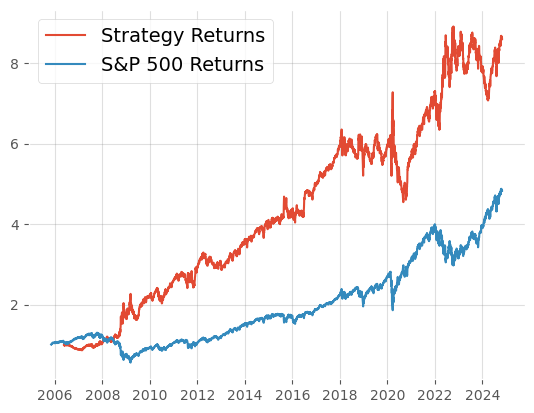

In [263]:
#MA Best
ma(df, 6, 75, 
   reverse_position = False, 
   graph = True,
   metrics = True)

In [264]:
MA_1_df = pd.DataFrame({'CAGR': 11.99/100,
              'Sharpe Ratio': 3.72/100,
              'Max Drawdown (%)': -37.52,
              'Final Account Value ($)': 8.600422378734113e5}, index = ['MA_1'])

MA_1_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
MA_1  0.1199        0.0372            -37.52            860042.237873

CAGR: 14.41%
Sharpe: 4.35%
Drawdown: -31.35%


12.916418240831572

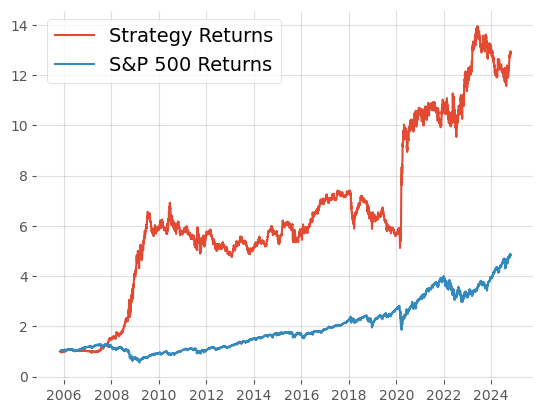

In [265]:
#MA Worst Reversed
ma(df, 2, 1, 
   reverse_position = True, 
   graph = True,  
   metrics = True)

In [266]:
MA_2_df = pd.DataFrame({'CAGR': 14.41/100,
              'Sharpe Ratio': 4.35/100,
              'Max Drawdown (%)': -31.35,
              'Final Account Value ($)': 12.916418240831572e5}, index = ['MA_2'])

MA_2_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
MA_2  0.1441        0.0435            -31.35             1.291642e+06

### 9. Strategy 2 EMA (Wei Hao) - Sharpe, CAGR, Max Drawdown, Final Acc Value

CAGR: 7.20%
Sharpe: 2.28%
Drawdown: -33.00%


3.7466671597713277

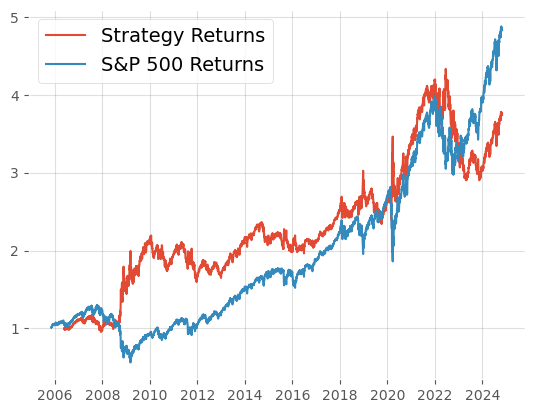

In [268]:
#EMA Best
ema(df, 11, 27, 
   reverse_position = False, 
   graph = True,
   metrics = True)

In [269]:
EMA_1_df = pd.DataFrame({'CAGR': 7.20/100,
              'Sharpe Ratio': 2.28/100,
              'Max Drawdown (%)': -33.00,
              'Final Account Value ($)': 3.7466671597713277e5}, index = ['EMA_1'])

EMA_1_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
EMA_1  0.072        0.0228             -33.0            374666.715977

CAGR: 11.24%
Sharpe: 3.44%
Drawdown: -42.96%


7.570974591294655

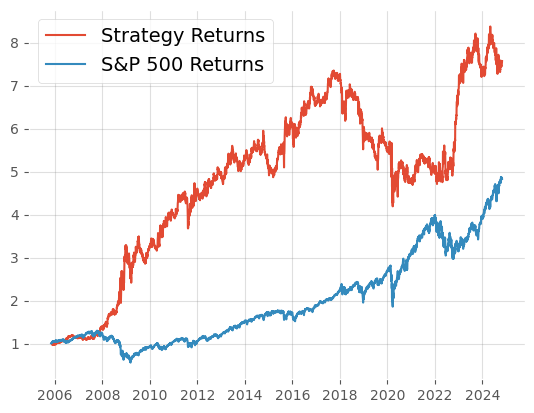

In [270]:
#EMA Worst Reversed
ema(df, 0, 2, 
   reverse_position = True, 
   graph = True,
   metrics = True)

In [271]:
EMA_2_df = pd.DataFrame({'CAGR': 11.24/100,
              'Sharpe Ratio': 3.44/100,
              'Max Drawdown (%)': -42.96,
              'Final Account Value ($)': 7.570974591294655e5}, index = ['EMA_2'])

EMA_2_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
EMA_2  0.1124        0.0344            -42.96            757097.459129

### 10. Strategy 3 MACD (Wei Hao) - Sharpe, CAGR, Max Drawdown, Final Acc Value

CAGR: 17.29%
Sharpe: 5.18%
Drawdown: -24.61%


20.7265779279449

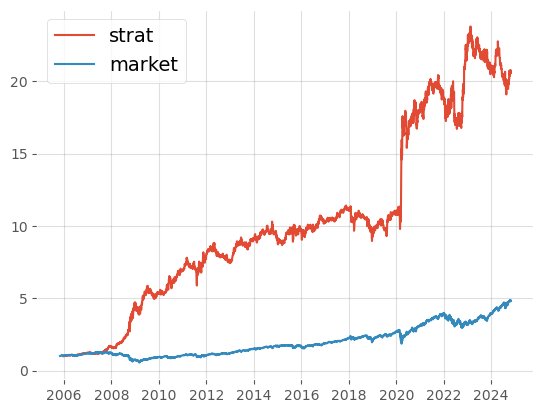

In [273]:
macd(df, 31, 1, 4, 
     graph = True,
     metrics = True)

In [274]:
MACD_df = pd.DataFrame({'CAGR': 17.29/100,
              'Sharpe Ratio': 5.18/100,
              'Max Drawdown (%)': -24.61,
              'Final Account Value ($)': 20.7265779279449e5}, index = ['MACD'])

MACD_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
MACD  0.1729        0.0518            -24.61             2.072658e+06

### 11. Strategy 4 RSI (Wei Hao) - Sharpe, CAGR, Max Drawdown, Final Acc Value

CAGR: 8.69%
Sharpe: 2.70%
Drawdown: -56.78%


4.8735266993006645

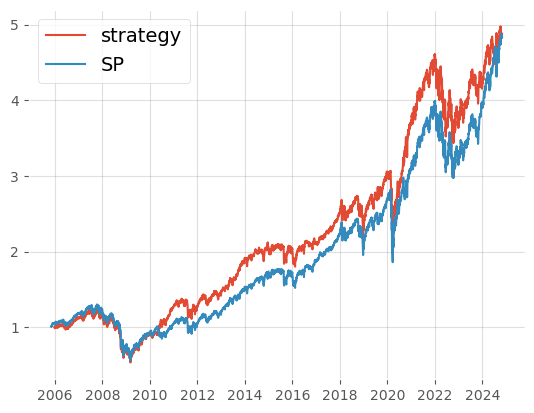

In [276]:
rsi_returns(df, 13, 45, 90, graph = True, metrics = True)

In [277]:
RSI_df = pd.DataFrame({'CAGR': 8.69/100,
              'Sharpe Ratio': 2.70/100,
              'Max Drawdown (%)': -56.78,
              'Final Account Value ($)': 4.8735266993006645e5}, index = ['RSI'])

RSI_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
RSI  0.0869         0.027            -56.78             487352.66993

### 12. Strategy 1 MFI (Fang Yi) - Sharpe, CAGR, Max Drawdown, Final Acc Value

'Max Drawdown: 20.32%'

0.20318491813548423

'Sharpe:0.9267391726664296'

0.9267391726664296

'CAGR:0.2966072580090384'

None

'Ending Balance: 3001422.1044066753'

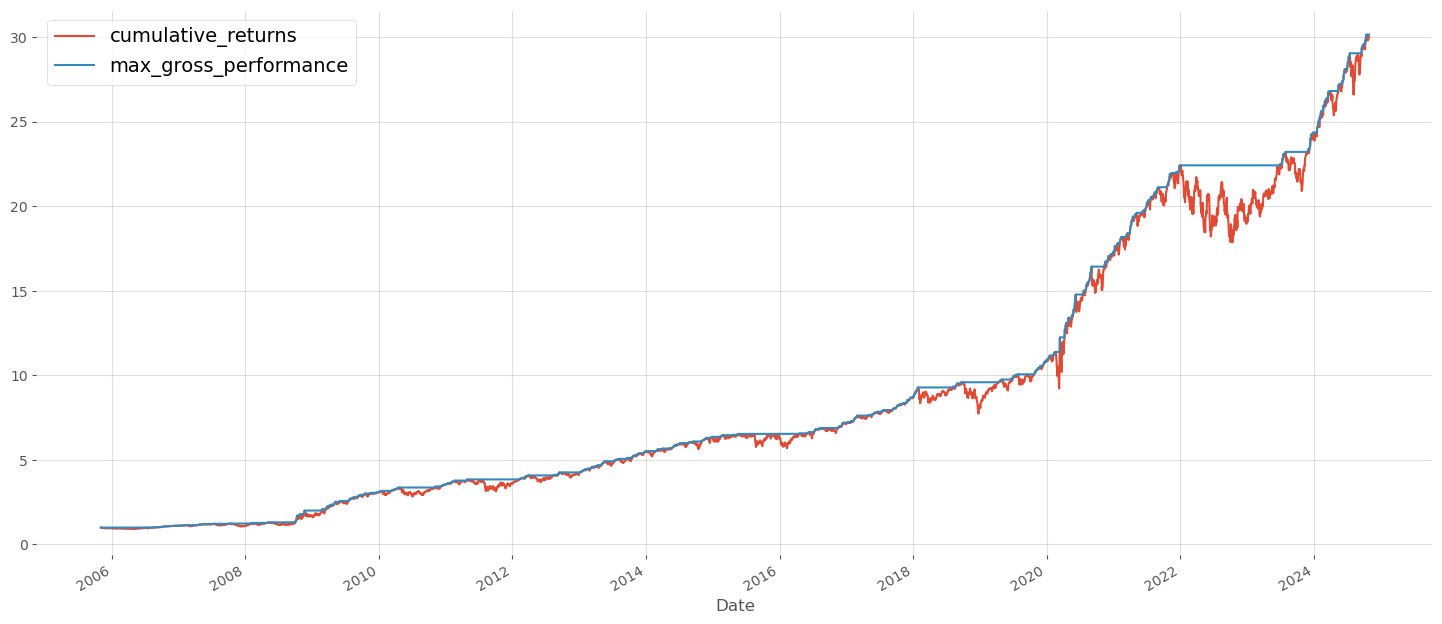

In [279]:
display(create_drawdown(stock_copy))
display(create_Sharpe(stock_copy))
display(create_CAGR(stock_copy))
display(f"Ending Balance: {stock_copy["ending_balance"].iloc[-1]}")

In [280]:
MFI_df = pd.DataFrame({'CAGR': 0.2966073988488718,
              'Sharpe Ratio': 0.9267398116855529,
              'Max Drawdown (%)': 20.32,
              'Final Account Value ($)': 3001426.3739305604}, index = ['MFI'])

MFI_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
MFI  0.296607       0.92674             20.32             3.001426e+06

### 13. Strategy 2 Ichimoku (Fang Yi) - Sharpe, CAGR, Max Drawdown, Final Acc Value

'Max Drawdown: 40.29%'

0.40289246169827

'Sharpe:0.126533357371552'

0.126533357371552

'CAGR:0.0279013417531786'

None

'Ending Balance: 143388.61050658263'

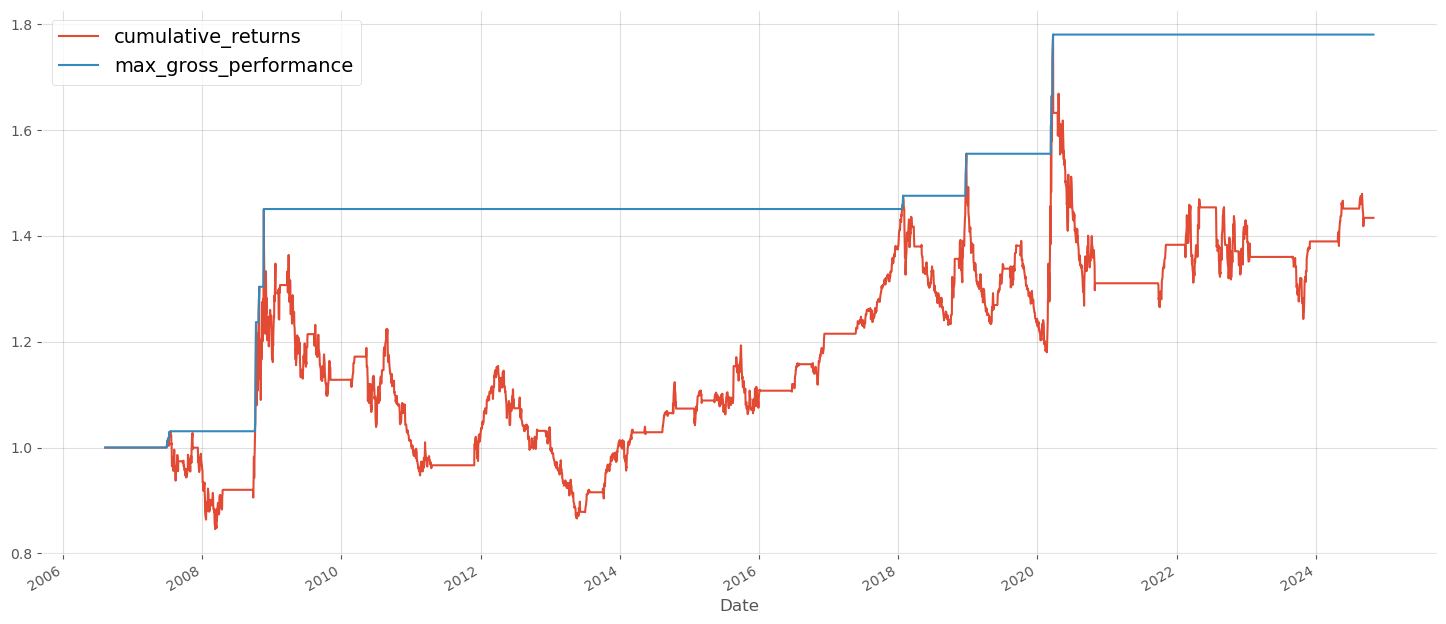

In [282]:
display(create_drawdown(stock_copy2))
display(create_Sharpe(stock_copy2))
display(create_CAGR(stock_copy2))
display(f"Ending Balance: {stock_copy2["ending_balance"].iloc[-1]}")

In [283]:
Ichimoku_df = pd.DataFrame({'CAGR': 0.027901592974357348,
              'Sharpe Ratio': 0.1265346396328252,
              'Max Drawdown (%)': 40.29,
              'Final Account Value ($)': 143389.0694457743}, index = ['Ichimoku'])

Ichimoku_df

CAGR  Sharpe Ratio  Max Drawdown (%)  Final Account Value ($)
Ichimoku  0.027902      0.126535             40.29            143389.069446

### SUMMARY TABLE AND BAR CHART

In [285]:
snp500 = calculate_performance_metrics(strategy_return = mean_reversion_result_df['SPY_return'],
                              cum_strategy_return = mean_reversion_result_df['cum_SPY_return'],
                              gross_max_performance = mean_reversion_result_df['cum_SPY_return'].cummax(),
                              initial_capital=100000)

snp500_df = pd.DataFrame(snp500, index=['S&P500 (BASELINE)'])
snp500_df

Sharpe Ratio      CAGR  Max Drawdown (%)  \
S&P500 (BASELINE)      0.623346  0.107218         55.189446   

                   Final Account Value ($)  
S&P500 (BASELINE)            690560.988641

In [286]:
all_metrics = pd.concat([sma_metric_df, 
           ewma_metric_df, 
           time_series_1_df, 
           time_series_2_df, 
           log_regression_df, 
           mean_reversion_df, 
           PCA_df,
           MA_1_df,
           MA_2_df,
           EMA_1_df,
           EMA_2_df,
           MACD_df,
           RSI_df,
           MFI_df,
           Ichimoku_df,
           snp500_df
])

all_metrics['Max Drawdown (%)'] = all_metrics['Max Drawdown (%)'].apply(lambda x: np.abs(x))
all_metrics['Final Account Value ($)'] = all_metrics['Final Account Value ($)']
all_metrics['S&P 500 Final Value ($)'] = (mean_reversion_result_df['cum_SPY_return'].iloc[-1] * 100000)
all_metrics['S&P 500 Final Value ($)'] = all_metrics['S&P 500 Final Value ($)']

# Sort by Sharpe Ratio (descending), then by CAGR and Max Drawdown (ascending)
sorted_strategies = all_metrics.sort_values(
    by=["Sharpe Ratio", "CAGR", "Max Drawdown (%)"], 
    ascending=[False, False, True]
)

# Display sorted DataFrame
sorted_strategies


Sharpe Ratio      CAGR  Max Drawdown (%)  \
Time_Series_2            1.084166  0.205979         37.531839   
Logistic_Regression      0.952242  0.180755         32.835651   
MFI                      0.926740  0.296607         20.320000   
PCA                      0.871879  0.289268         71.073244   
EWMA                     0.763582  0.067912         27.707293   
SMA                      0.757323  0.070235         23.440907   
S&P500 (BASELINE)        0.623346  0.107218         55.189446   
Mean_Reversion           0.313246  0.042770         44.885542   
Ichimoku                 0.126535  0.027902         40.290000   
MACD                     0.051800  0.172900         24.610000   
MA_2                     0.043500  0.144100         31.350000   
MA_1                     0.037200  0.119900         37.520000   
EMA_2                    0.034400  0.112400         42.960000   
RSI                      0.027000  0.086900         56.780000   
EMA_1                    0.022800  0.072000         33.000000   
Time_Series_1           -0.275606 -0.069300         82.077419   

                     Final Account Value ($)  S&P 500 Final Value ($)  
Time_Series_2                   3.492970e+06            690560.988641  
Logistic_Regression             2.308370e+06            690560.988641  
MFI                             3.001426e+06            690560.988641  
PCA                             8.981266e+06            690560.988641  
EWMA                            3.478438e+05            690560.988641  
SMA                             3.624830e+05            690560.988641  
S&P500 (BASELINE)               6.905610e+05            690560.988641  
Mean_Reversion                  2.213472e+05            690560.988641  
Ichimoku                        1.433891e+05            690560.988641  
MACD                            2.072658e+06            690560.988641  
MA_2                            1.291642e+06            690560.988641  
MA_1                            8.600422e+05            690560.988641  
EMA_2                           7.570975e+05            690560.988641  
RSI                             4.873527e+05            690560.988641  
EMA_1                           3.746667e+05            690560.988641  
Time_Series_1                   2.560069e+04            690560.988641

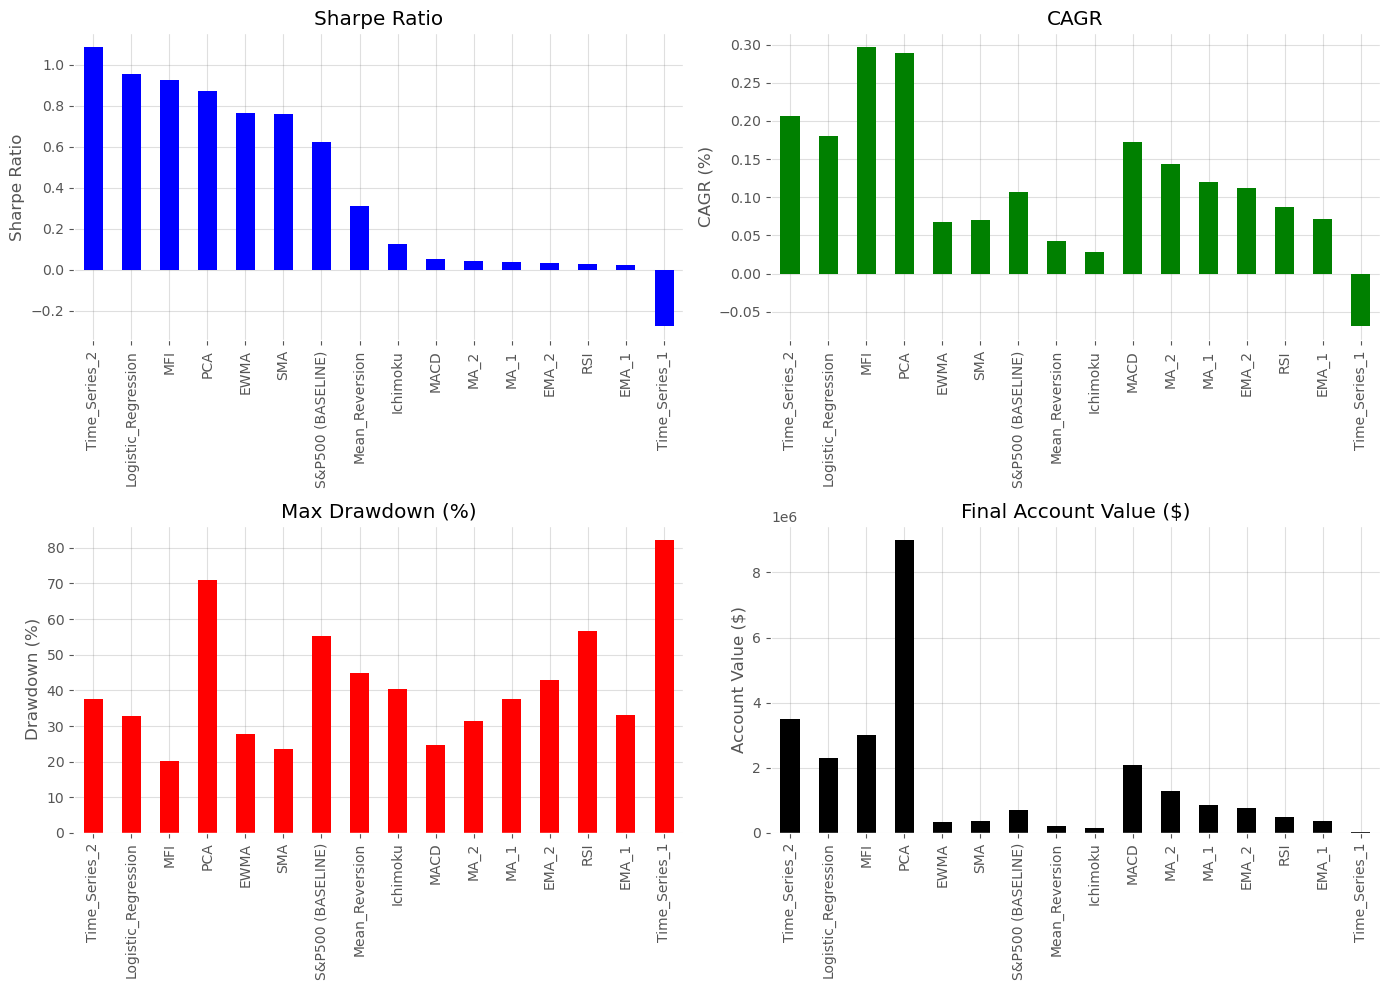

In [287]:
# Define figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots

# Plot Sharpe Ratio
sorted_strategies['Sharpe Ratio'].plot(kind='bar', ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Sharpe Ratio')
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].grid(True)

# Plot CAGR
sorted_strategies['CAGR'].plot(kind='bar', ax=axes[0, 1], color='green')
axes[0, 1].set_title('CAGR')
axes[0, 1].set_ylabel('CAGR (%)')
axes[0, 1].grid(True)

# Plot Max Drawdown (%)
sorted_strategies['Max Drawdown (%)'].plot(kind='bar', ax=axes[1, 0], color='red')
axes[1, 0].set_title('Max Drawdown (%)')
axes[1, 0].set_ylabel('Drawdown (%)')
axes[1, 0].grid(True)

# Plot Final Account Value ($)
sorted_strategies['Final Account Value ($)'].plot(kind='bar', ax=axes[1, 1], color='black')
axes[1, 1].set_title('Final Account Value ($)')
axes[1, 1].set_ylabel('Account Value ($)')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


# `Part 3`
> Third, you should write up an executive summary of your strategies and backtesting results. Please report at least your `top three strategies` (i.e., strategy A, strategy B, strategy C). In this summary, you should discuss Sharpe Ratio, compound annual growth rate, and maximum drawdown, comparing your results for strategies A, B, and C. For each of the three sections, please provide a bookmark in your Jupyter Notebook file (for easy access).

> Criteria:
> 1. `Amount of Money Left`: The higher the better, since the objective is to have maximum returns.
> 2. `Sharpe Ratio`: The higher the better, since it maximises the amount of reward-to-risk ratio.
> 3. `CAGR`: The higher the better, for higher compounded returns rate.
> 4. `Maximum Drawdown`: The lower the better for risk management.

In [290]:
sorted_strategies['Max Drawdown (%)'] = sorted_strategies['Max Drawdown (%)']
sorted_strategies['Final Account Value ($)'] = sorted_strategies['Final Account Value ($)'].apply(lambda x: f"{x:,.2f}")
sorted_strategies['S&P 500 Final Value ($)'] = sorted_strategies['S&P 500 Final Value ($)'].apply(lambda x: f"{x:,.2f}")

sorted_strategies

Sharpe Ratio      CAGR  Max Drawdown (%)  \
Time_Series_2            1.084166  0.205979         37.531839   
Logistic_Regression      0.952242  0.180755         32.835651   
MFI                      0.926740  0.296607         20.320000   
PCA                      0.871879  0.289268         71.073244   
EWMA                     0.763582  0.067912         27.707293   
SMA                      0.757323  0.070235         23.440907   
S&P500 (BASELINE)        0.623346  0.107218         55.189446   
Mean_Reversion           0.313246  0.042770         44.885542   
Ichimoku                 0.126535  0.027902         40.290000   
MACD                     0.051800  0.172900         24.610000   
MA_2                     0.043500  0.144100         31.350000   
MA_1                     0.037200  0.119900         37.520000   
EMA_2                    0.034400  0.112400         42.960000   
RSI                      0.027000  0.086900         56.780000   
EMA_1                    0.022800  0.072000         33.000000   
Time_Series_1           -0.275606 -0.069300         82.077419   

                    Final Account Value ($) S&P 500 Final Value ($)  
Time_Series_2                  3,492,969.67              690,560.99  
Logistic_Regression            2,308,369.69              690,560.99  
MFI                            3,001,426.37              690,560.99  
PCA                            8,981,265.67              690,560.99  
EWMA                             347,843.82              690,560.99  
SMA                              362,483.00              690,560.99  
S&P500 (BASELINE)                690,560.99              690,560.99  
Mean_Reversion                   221,347.16              690,560.99  
Ichimoku                         143,389.07              690,560.99  
MACD                           2,072,657.79              690,560.99  
MA_2                           1,291,641.82              690,560.99  
MA_1                             860,042.24              690,560.99  
EMA_2                            757,097.46              690,560.99  
RSI                              487,352.67              690,560.99  
EMA_1                            374,666.72              690,560.99  
Time_Series_1                     25,600.69              690,560.99

### Top 3 Strategies:

`1. Time Series Momentum Strategy with 2 Hyperparameters` (Section 1.1.4.)

- Sharpe Ratio (1.084): **The highest among all strategies**, indicating the best risk-adjusted returns.
- CAGR (20.57%): Strong annualized growth.
- Max Drawdown (37.52%): not low, but still lower than S&P 500 drawdown (55%), so it is still acceptable given the high Sharpe Ratio.
- Final Account Value: **$3.49M, around 5 times S&P500 final balance**. Second highest final balance.
> Why: Time_Series_2 combines strong risk-adjusted returns with good long-term growth, making it the top choice. Overall winner for return and risk combined metrics, suitable for almost every investor.

`2. Money Flow Index (MFI)` (Section 1.3.1)
- Sharpe Ratio (0.927): Number 3 highest compared to all strategies.
- CAGR (29.66%): The highest CAGR from all strategies, best annualized returns.
- Max Drawdown (20.32%): The best among all strategies, showing strong capital preservation, great for risk-averse inverstors.
- Final Account Value: **$3.01M, around 4-5 times S&P500 final balance.**
>Why: MFI is one of the most balanced strategies, offering high returns, low risk, and the best drawdown metric. It’s ideal for risk-conscious investors. **Even though the Sharpe Ratio is a bit lower than Logistic Regression (Rank 3), but it has lower risk as shown in the lower max drawdown, thus I rank it as number 2.**

`3. Logistic_Regression` (Section 1.1.5)
- Sharpe Ratio (0.952): **The second-best risk-adjusted return**, just below the time series momentum 2.
- CAGR (18.08%): Still a decent CAGR with around 8% higher than S&P500 CAGR. Eventhough other strategies can deliver better annualized return.
- Max Drawdown (32.84%): Moderate, better than Time_Series_2 and S&P500, but not as good as MFI.
- Final Account Value: **$2.38M, around 3-4 times S&P500 final balance.**
> Why: Logistic_Regression balances risk-adjusted returns and long-term growth, making it a solid choice, but just fall below time series momentum 2, in terms of return, growth, with similar risk exposure.

### Honorable Mentions:
`4. Principal Component Analysis (PCA)` (Section 1.1.7)
- Sharpe Ratio (0.871): Strong but slightly below MFI and Logistic_Regression.
- CAGR (28.29%): Very high, even higher than the number 1 (time series momentum 2), indicating excellent growth.
- Max Drawdown (71.08%): **Very high, making this strategy riskier than others, especially the baseline S&P500 (55%)**. Which is the reason why we remove it from the top 3.
- Final Account Value: **$8.93M, the highest among all strategies.**
> Why: High risk high return, but **PCA has extremely high growth but also at the cost of very high drawdown**. It’s suitable for aggressive investors with lots of risk appetite that can tolerate significant risk and can wait through the drawdown.

`5. Moving Average Convergence/Divergence (MACD)` (Section 1.2.3)
- Sharpe Ratio (0.051800): Quite low, in fact lower than most strategies, especially compared to S&P 500 Sharpe Ratio (0.62).
- CAGR (17.29%): Above average growth, better than S&P500 (10%)
- Max Drawdown (24.61%): One of the lowest drawdown out of all, showing good risk control, and more than half of S&P500 (55%).
- Final Account Value: $2.07M, one of the highest.
> Why: MACD offers a **high growth rate with one of the lowest drawdown**. However, it has one of the lowest sharpe ratio which means that its high return is also accompanied by an even higher volatility or risk relative to the other strategies. Making it less attractive for risk-averse investors despite its strong growth and low drawdown. **The low Sharpe Ratio suggests that the returns are not consistent or stable, which is a key drawback compared to other strategies.**

# `PART 4` 
> Self-Critique of Your Team's Trading Strategies


1. Hyperparameter Tuning
> For the strategies that we have employed, we have tuned the parameters to achieve the maximum cumulative returns. However, historical performance might not be indicative of future performance. Hence, some of the strategies that have performed well during the training set, failed to continue performing when applied to the test set.
>
> A possible way to mitigate this might be to add more criterias to tune for, eg. Max Drawdown, or Standard Deviations, etc.

2. Market Regime Shifts
> As the market regime is unpredictable, some of the strategies that performed well might be overestimated as most of their returns are from the market downturns like the 2008 and 2020 Financial Crises. Moreover, during the bull-market, they have been losing money.
>
> A possible way to mitigate this might be to remove extreme outliers through winsorization. This would eliminate most of the days where there are huge market movements. We can also add a kill switch/stoploss for days with wild movements. Else, we could use machine learning techniques, like Hidden Markov Models, to determine the market regimes then train and switch the strategies according to the regimes.

3. Stability of the Returns
> From what we have observed, most of the strategies have very volatile movements that is closedly linked to market volatility. This might not be ideal for quantitative strategies as our objective is to achieve consistent returns instead of a one-time win that is akin to lottery.
>
> Similar to the previous few points, we can mitigate using more criterias when tuning the model.

4. Strategy Selection Criteria
> For our strategy selection, the criteria for "Amount of Money Left" should not have been calculated since the start of the backtesting strategy for the whole time horizon as that would include the training-set's maximised returns. This would greatly skew the returns and is not reflective of the model's performance.
>
> Instead, the metrics for strategy selection should have been a comparison of the strategies' performance between in-sample and out-of-sample data separately to prevent data leakage.

5. Interesting Pointers to Note:
> An interesting phenomenon is that for some of the strategies, like SMA, MACD, EMA, and RSI, they have periods that are = 1. This means that the buy/sell signal to crossover is basically the price itself. An intuition might be due to the prevalence of investors using these indicators to trade since they are the most commonly used indicators. Furthermore, the chances are that the result would be a contrarian trade where we short at the buy signal and long at the sell signal.

6. Possible Data Leakage / Lookahead Bias Impact to Metrics 
> Sharpe ratio, CAGR, and final account balance value might be inflated due to the data leakage that we introduced during the training data period. This is because the metrics that we calculated includes the time period not only from test dataset, but also from train dataset. This means that whatever information that is available tomorrow has been captured in the trading day, which leads to a better result.
> 
> Possible mitigation is to isolate the test data set and only use the test dataset period to calculate the metrics for a more realistic outcome.

# `CONTRIBUTION STATEMENT`

**`Kevin Montana Wongso:`** 

- For Part 1, I developed, tuned the hyperparameters, amd implemented the following strategies:
  - SMA 
  - EWMA
  - Time Series with 1 hyperparameter
  - Time Series with 2 hyperparameters
  - Logistic regression
  - Mean reversion strategy
  - PCA for weight allocation for all those strategies above
- For Part 2 , I calculated and compiled all the Sharpe Ratio, CAGR, Max Drawdown, and Final Values for comparison into a dataframe. Plotted the bar chart for visualization.
- For Part 3, I choose the top 3 strategies and the honorable mentions due to some outstanding features. Based on the criteria given, I give my reasonings for my choices.
- For Part 4, I added some minor pointers in addition to Wei Hao's main analysis, such as data leakage / lookahead bias.


**`Tan Wei Hao:`** 
- For Part 1 and 2, I developed and implemented the following strategies: Moving Average Strategy, Exponential Moving Average Strategy, MACD Strategy, and RSI Strategy. This included coding, testing, and hyperparameter-tuning of the strategies to ensure they aligned with the assignment requirements.

- For Part 4, I helped author the self-critique section, analyzing our strategies through issues stemming from hyperparameter tuning, market regime shifts, stability of the returns, problems with strategy selection criteria, and providing additional insights to what we have found. I have also provided recommendations to address the above issues.

- Additionally, I helped guide the team in their research direction, proposed several ideas on probable strategies and shared insights on how to improve their strategies' performances.

**`Lim Fang Yi:`** 
- Tried a few (discarded approaches) e.g. using prophet model to forecast prices and use the difference as a trade signal, using SMA crossover (discarded because there were better one). Tried the failed (included) ichimoku cloud which failed.

- Then tried MFI signal under teammate recommendation which works. Then evaluated performance and limitations in the methodology in my critque

**`Rahul:`**
- For Part 4, as self-critique, I played a role in assessing the performance of our strategies and pinpointing several key issues. These included challenges with hyperparameter tuning, applying different strategies and the overall stability of our returns. I also identified some shortcomings in our strategy selection criteria. I offered insights into what might be the cause and provided actionable recommendations to help improve our approach and address these problems effectively.